<div style="background-color: RED; color: BLACK; padding: 8px;text-align: center;">
    <h3> KI INSURANCE ANALYSIS </h3>
</div>

![Ki Insurance Banner](https://drive.google.com/uc?id=1bHWaM7Eu1ieFvEF3l5IEW9w4Cm1FT3vU)

## Project Overview


**Description:**
The project aims to investigate the viability and value of using longitude and latitude data in risk assessment for property insurance quotes on the Ki platform.

## Project Details

**Background:**
Ki's platform allows brokers to get insurance quotes for their clients by inputting necessary data. For property insurance, which is a significant part of Ki's business, data enrichment is performed using third-party sources to enhance user experience without overburdening brokers with data input.

**Current Challenge:**
Ki is exploring the integration of longitude and latitude data for better risk assessment. However, there's a concern that requiring brokers to provide this data may deter them. A third-party API (zip-api.eu) is suggested to fetch this data instead.

## Goals

1. Implement a Python script to fetch, transform, and store longitude and latitude data using the third-party API.
2. Analyze the value of this data in enhancing risk assessment for property insurance.

## Objectives and Scope

**Part 1: Script Development**
- Develop a Python script that interacts with the zip-api.eu API.
- Transform and clean the data as necessary.
- Store the data in a local data store.
- Ensure the script is simple and efficient.

**Part 2: Data Analysis**
- Frame an analysis with general insights about Ki's property portfolio.
- Address specific questions related to claims and properties.
- Provide recommendations for improving profitability based on the analysis.

## Deliverables

1. **Python Script:**
   - Fetches and transforms data from zip-api.eu.
   - Stores data in a local instance of KiDB.
   - Outputs JSON with required attributes.

2. **Analysis Report:**
   - General insights on the 2018 property portfolio.
   - Answers to specific questions regarding claims and properties.
   - Recommendations for improving portfolio profitability.
   - Presentation of findings (Jupyter notebook or dashboard).

## Potential Obstacles

- **Data Quality:** Ensuring the accuracy and cleanliness of the data fetched from the API.
- **API Limitations:** Handling any limitations or errors from the third-party API.
- **Time Constraint:** Completing the task within the suggested 2-3 hours.
- **Technical Challenges:** Integrating the new data into the existing KiDB and ensuring smooth data transformation.

## Additional Information

**Ki Data Analyst Role: Take-home Exercise**

**Background:**
Ki’s platform helps brokers get insurance quotes by inputting data about clients and their properties. For property insurance, this includes enriching broker-provided data with third-party data.

**Exercise:**
Implement a solution to fetch and use longitude and latitude data for risk assessment using the zip-api.eu API.

**Part 1: Script Requirements:**
- Create a Python script to fetch and transform data.
- Store the data in KiDB.
- Ensure a simple, efficient implementation.

**Part 2: Analysis Requirements:**
- Analyze the 2018 property portfolio enriched with longitude and latitude data.
- Provide general insights and specific answers regarding claims.
- Recommend changes to improve profitability.

**Questions for Analysis:**
1. What percentage of properties had a claim?
2. What percentage of policies had a claim?
3. What percentage of properties with a construction type of "Wood" had a claim?
4. Which zip code has the highest number of properties?
5. What (if any) value does longitude and latitude data provide?

**Analysis and Presentation:**
- Prepare a report highlighting key insights.
- Recommend areas for portfolio improvement.
- Present findings in a 5-10 minute presentation.

**Data Provided:**
- A CSV file with property and claims data for the 2018 portfolio.

**Disclaimer:**
- Use the provided data only for the recruitment task.
- Delete the data after the task.
- Keep the data secure and do not share it.


<div style="background-color: RED; color: BLACK; padding: 8px;text-align: center;">
    <h3> Start </h3>
</div>

## Part 1: Implementing the Data Fetching Script

In this section, I will develop a Python script to fetch longitude and latitude data from the **zip-api.eu API**. The script will transform and clean the data, then store it in a local data store for further analysis.

### Step 1: Define the KiDB Class

First, I will define a class `KiDB` that will act as an abstraction layer for our data store.


In [1]:
import json
import requests

class KiDB:
    """
    Abstraction layer to allow interaction with data stored in _data.
    """

    def __init__(self):
        self._data = {}
        self._next_id = 0  # one table can have multiple rows

    def add_table(self, table_name: str) -> None:
        """
        Adds table to database under name table_name.
        """
        if table_name in self._data:
            raise ValueError(f"{table_name} already exists in database")

        self._data[table_name] = {}

    def add_row(self, table_name: str, row_data: dict) -> dict:
        """
        Adds row (containing row_data) to the table.
        """
        if table_name not in self._data:
            raise ValueError(f"{table_name} does not exist in the database")

        row_id = self._next_id
        self._next_id += 1

        self._data[table_name][row_id] = row_data
        return self._data[table_name][row_id]

    def get_rows(self, table_name: str, matching_criteria: dict = {}) -> list[dict]:
        """
        Returns relevant rows of table as a list of dictionaries.
        If no matching rows are found, an empty list is returned.
        """
        if table_name not in self._data:
            raise ValueError(f"{table_name} does not exist in the database")

        records = self._data[table_name].values()
        filtered_records = []

        for record in records:
            match = True
            for key, (operator, value) in matching_criteria.items():
                if key not in record:
                    match = False
                    break

                if operator == "==":
                    if not record[key] == value:
                        match = False
                        break
                elif operator == "!=":
                    if not record[key] != value:
                        match = False
                        break
                elif operator == ">":
                    if not record[key] > value:
                        match = False
                        break
                elif operator == "<":
                    if not record[key] < value:
                        match = False
                        break
                elif operator == ">=":
                    if not record[key] >= value:
                        match = False
                        break
                elif operator == "<=":
                    if not record[key] <= value:
                        match = False
                        break
                else:
                    raise ValueError(f"Unsupported operator: {operator}")

            if match:
                filtered_records.append(record)
        return filtered_records


### Step 2: Initialise the Database
Next, I initialise the database instance and add a table for storing the data.

In [2]:
# Initialize db instance and add table
db_instance = KiDB()
db_instance.add_table("PostCodeData")

### Step 3: Implement the Lambda Handler

The lambda handler function will fetch data from the zip-api.eu API based on the input JSON, transform the data, store it in the KiDB, and return the transformed data.

In [3]:
def lambda_handler(json_input: str) -> dict:
    """
    Takes JSON input with attributes CountryCode and PostalCode.
    Fetches data from https://zip-api.eu/en/.
    Cleans and transforms as required.
    Stores data in global db_instance of KiDB.
    Returns relevant JSON output with additional attributes PlaceName, State, Latitude, Longitude.
    """
    global db_instance
    input_data = json.loads(json_input)
    country_code = input_data.get("CountryCode")
    postal_code = input_data.get("PostCode")

    url = f"https://zip-api.eu/api/v1/info/{country_code}-{postal_code}"
    response = requests.get(url)

    if response.status_code != 200:
        return {"error": "Failed to fetch data from API"}

    data = response.json()

    # Extract relevant attributes and store in db_instance
    transformed_data = {
        "CountryCode": country_code,
        "PostCode": postal_code,
        "PlaceName": data.get("place name"),
        "State": data.get("state"),
        "Latitude": data.get("latitude"),
        "Longitude": data.get("longitude")
    }

    db_instance.add_row('PostCodeData', transformed_data)

    return transformed_data


### Step 4: Testing the Lambda Handler

We will test the lambda handler with various inputs and verify that the data is correctly stored in the KiDB instance.

In [5]:
lambda_handler(json.dumps({"CountryCode": "US", "PostCode": "96086"}))
lambda_handler(json.dumps({"CountryCode": "US", "PostCode": "93638"}))
lambda_handler(json.dumps({"CountryCode": "US", "PostCode": "9352"}))
lambda_handler(json.dumps({"CountryCode": "GB", "PostCode": "CB8"}))
lambda_handler(json.dumps({"CountryCode": "US", "PostCode": "96141"}))
lambda_handler(json.dumps({"CountryCode": "GB", "PostCode": "BT 47"}))
lambda_handler(json.dumps({"CountryCode": "US", "PostCode": "92070"}))
lambda_handler(json.dumps({"CountryCode": "US", "PostCode": "95503"}))
lambda_handler(json.dumps({"CountryCode": "USA", "PostCode": "95659"}))
lambda_handler(json.dumps({"CountryCode": "US", "PostCode": "92122"}))
lambda_handler(json.dumps({"CountryCode": "US", "PostCode": "95554"}))
lambda_handler(json.dumps({"CountryCode": "UK", "PostCode": "96141"}))
lambda_handler(json.dumps({"CountryCode": "US", "PostCode": "96086"}))


{'CountryCode': 'US',
 'PostCode': '96086',
 'PlaceName': None,
 'State': 'California',
 'Latitude': None,
 'Longitude': None}

### Step 5: Querying the Database

Finally, we will query the KiDB instance to return all rows which are in the state of California.

In [6]:
# Query db_instance to return all rows which are in the state of California
matching_criteria = {"State": ("==", "California")}
print(db_instance.get_rows("PostCodeData", matching_criteria))

[{'CountryCode': 'US', 'PostCode': '96086', 'PlaceName': None, 'State': 'California', 'Latitude': None, 'Longitude': None}, {'CountryCode': 'US', 'PostCode': '93638', 'PlaceName': None, 'State': 'California', 'Latitude': None, 'Longitude': None}, {'CountryCode': 'US', 'PostCode': '96141', 'PlaceName': None, 'State': 'California', 'Latitude': None, 'Longitude': None}, {'CountryCode': 'US', 'PostCode': '92070', 'PlaceName': None, 'State': 'California', 'Latitude': None, 'Longitude': None}, {'CountryCode': 'US', 'PostCode': '95503', 'PlaceName': None, 'State': 'California', 'Latitude': None, 'Longitude': None}, {'CountryCode': 'US', 'PostCode': '92122', 'PlaceName': None, 'State': 'California', 'Latitude': None, 'Longitude': None}, {'CountryCode': 'US', 'PostCode': '95554', 'PlaceName': None, 'State': 'California', 'Latitude': None, 'Longitude': None}, {'CountryCode': 'US', 'PostCode': '96086', 'PlaceName': None, 'State': 'California', 'Latitude': None, 'Longitude': None}]


## Part 2: Data Analysis

In this section, we will analyze the enriched dataset with longitude and latitude data to answer specific questions and provide insights on the 2018 US property insurance portfolio.

### Questions to Answer

1. What percentage of properties had a claim?
2. What percentage of policies had a claim?
3. What percentage of properties with a construction type of "Wood" had a claim?
4. Which zip code has the highest number of properties?
5. What (if any) value does longitude and latitude data provide?

### Analysis and Presentation

We will perform the analysis and present the findings in a report, which includes the answers to the above questions and recommendations for improving profitability.


<div style="background-color: RED; color: BLACK; padding: 8px;text-align: center;">
    <h3> Libraries </h3>
</div>

- `import pandas as pd`: Imports the pandas library for data manipulation and analysis, aliased as `pd`.
- `import numpy as np`: Imports the numpy library for numerical computations, aliased as `np`.
- `from sklearn.preprocessing import MinMaxScaler`: Imports the MinMaxScaler class from scikit-learn for feature scaling.
- `import matplotlib.pyplot as plt`: Imports the pyplot module from matplotlib for plotting data visualizations.
- `import seaborn as sns`: Imports the seaborn library for statistical data visualization, providing enhanced aesthetics and built-in themes.


In [9]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns


<div style="background-color: RED; color: BLACK; padding: 8px;text-align: center;">
    <h3> Directory Structure </h3>
</div>

`!tree` is a command used to display a directory tree structure in Markdown or command line interfaces.


In [2]:
!tree

.
├── Claims Distribution by Construction Type.png
├── code.ipynb
├── Correlation Matrix of Risk Factors.png
├──  data set from a company
│   └── _assessment_data (1).csv
├── Distribution of Properties by State.png
├── Earth quake
│   └── EQ_PML_RPT_2011_2018.pdf
├── Flood Insurance 
│   └── Finance_flood_insurance_program.xlsx
├── Insurance Industry 
│   ├── Availability-and-Affordability-Report-Appendix-C.pdf
│   ├── Data-by-State-Q2-2017.csv
│   ├── Data-by-State-Q2-2017.pdf
│   ├── Data-by-State-Q2-2017_removed.pdf
│   ├── EQEXP2018SummaryWA.pdf
│   ├── Insurance lloyds of london.png
│   └── National Association of Insurance Commisioners 2018.pdf
├── merged_dataset.csv
├── merged_dataset_with_risk_scores.csv
├── miscellaneous.docx
├── Number of Policies by State.png
├── Percentage of Properties and Policies with Claims.png
├── Police_crime
│   └── Crime Data.xlsx
├── Property Locations with Number of Claims.png
├── Property Locations with Risk Scores 2.png
├── Property Locations wi


<div style="background-color: RED; color: BLACK; padding: 8px;text-align: center;">
    <h3> Load Datasets To Merge </h3>
</div>


     - Crime index
     - Wildfire risk
     - Toxic releases
     - House prices


<div style="background-color: RED; color: BLACK; padding: 8px;text-align: center;">
    <h3> Property Claims Data </h3>
</div>

In [10]:
property_claim=pd.read_csv('../Insurance Dataset/ data set from a company/_assessment_data (1).csv')
property_claim.head()

Longitude   Latitude  YearBuilt    zip          county Stories  \
0 -122.286001  37.780235  1981-1990  94501  Alameda County       1   
1 -122.265457  37.769702    pre1900  94501  Alameda County       0   
2 -122.276098  37.782756  2001-2010  94501  Alameda County       1   
3 -122.317500  37.793864  1901-1950  94501  Alameda County       1   
4 -122.269589  37.766860  1981-1990  94501  Alameda County       1   

                Occupancy Construction state  QualMorgPrem     TotInc  \
0              Government         Wood    CA         200.0  3047833.0   
1              Commercial      Unknown    CA         200.0  3047833.0   
2              Commercial         Wood    CA         200.0  3047833.0   
3  Religion and Nonprofit         Wood    CA         200.0  3047833.0   
4              Industrial      Masonry    CA         200.0  3047833.0   

   Property.crime   id  property_id   YOA  numClaims  
0             819  478            1  2018          0  
1             819    7            2  2018          0  
2             819  657            3  2018          0  
3             819  172            4  2018          0  
4             819  480            5  2018          0

#  Specific Questions
<div style="background-color: RED; color: BLACK; padding: 8px;text-align: center;">
    <h3> 1 </h3>
</div>

## Percentage of Properties with a Claim
   - Method: Calculate the ratio of properties with a `numClaims` greater than 0 to the total number of properties.
   - Formula: `(Number of Properties with numClaims > 0) / (Total Number of Properties)  100`

In [3]:
# Step 1: Total number of properties
total_properties = len(property_claim)

# Step 2: Number of properties with numClaims > 0
properties_with_claims = len(property_claim[property_claim['numClaims'] > 0])

# Step 3: Calculate the ratio
ratio = properties_with_claims / total_properties

# Step 4: Convert to percentage
percentage_with_claims = ratio * 100

round(percentage_with_claims,2)

4.06

# Percentage of Policies with a Claim
<div style="background-color: RED; color: BLACK; padding: 8px;text-align: center;">
    <h3> 2 </h3>
</div>

   - Method: Calculate the ratio of policies with a `numClaims` greater than 0 to the total number of policies.
   - Formula: `(Number of Policies with numClaims > 0) / (Total Number of Policies)  100`


In [4]:
# prompt: Percentage of Policies with a Claim
#     Method: Calculate the ratio of policies with a numClaims greater than 0 to the total number of policies.
#     Formula: (Number of Policies with numClaims > 0) / (Total Number of Policies) 100

# Step 1: Total number of policies
total_policies = len(property_claim["Property.crime"])

# Step 2: Number of policies with numClaims > 0
policies_with_claims = len(property_claim[property_claim['numClaims'] > 0])

# Step 3: Calculate the ratio
ratio = policies_with_claims / total_policies

# Step 4: Convert to percentage
percentage_with_claims = ratio * 100

round(percentage_with_claims,2)


4.06

### Implications of 4%

- **Low Claim Rate**: A 4% ratio indicates a relatively low claim rate among the policies. This could suggest that the properties insured are generally low-risk, or that the underwriting criteria are stringent.
- **Risk Assessment**: For the insurance company, this low ratio might mean fewer payouts and potentially higher profitability.
- **Premium Pricing**: It might also influence how premiums are priced. If the risk of claims is low, the company might adjust premiums accordingly.
- **Policy Holder Behavior**: It could reflect the behavior of policyholders, such as good maintenance practices or lower exposure to risks.


# Percentage of Wood-Constructed Properties with a Claim
<div style="background-color: RED; color: BLACK; padding: 8px;text-align: center;">
    <h3> 3 </h3>
</div>

   - Method: Calculate the ratio of wood-constructed properties with a `numClaims` greater than 0 to the total number of wood-constructed properties.
   - Formula: `(Number of Wood Properties with numClaims > 0) / (Total Number of Wood Properties)  100`


In [5]:
# Step 1: Total number of wood properties
total_wood_properties = len(property_claim[property_claim['Construction'] == 'Wood'])

# Step 2: Number of wood properties with numClaims > 0
wood_properties_with_claims = len(property_claim[(property_claim['Construction'] == 'Wood') & (property_claim['numClaims'] > 0)])

# Step 3: Calculate the ratio
ratio = wood_properties_with_claims / total_wood_properties

# Step 4: Convert to percentage
percentage_with_claims = ratio * 100

rounded_percentage_with_claims = f"{round(percentage_with_claims, 2)}%"

rounded_percentage_with_claims


'5.5%'

# Zip Code with the Highest Number of Properties
<div style="background-color: RED; color: BLACK; padding: 8px;text-align: center;">
    <h3> 4 </h3>
</div>

   - Method: Identify the `zip` with the maximum count of properties.
   - Formula: `zip with MAX(Count of Properties)`


In [6]:
#  Zip Code with the Highest Number of Properties
#    - Method: Identify the `zip` with the maximum count of properties.
#    - Formula: `zip with MAX(Count of Properties)

# Get the count of properties for each zip code
zip_counts = property_claim['zip'].value_counts()

# Find the zip code with the highest count
most_common_zip = zip_counts.index[0]

# Print the result
print(f"Zip code with the highest number of properties: {most_common_zip}")

Zip code with the highest number of properties: 94565


# Value of Longitude and Latitude Data

<div style="background-color: RED; color: BLACK; padding: 8px;text-align: center;">
    <h3> 5 </h3>
</div>

   - Method: Assess the spatial distribution of claims and correlate with geographic risk factors (e.g., proximity to wildfire zones, fault lines).
   - Insights: Determine if properties in certain geographic areas are more prone to claims, which can inform risk-based pricing and underwriting.


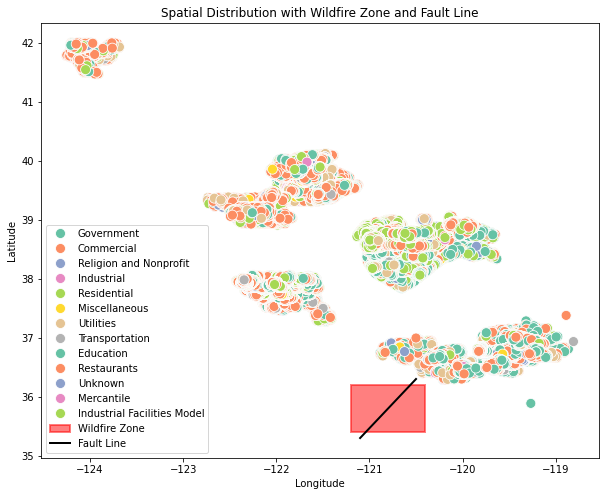

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon, LineString
# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(property_claim['Longitude'], property_claim['Latitude'])]
geo_property_claim = gpd.GeoDataFrame(property_claim, geometry=geometry)

# Create hypothetical wildfire zone and fault line for demonstration
wildfire_zone = Polygon([(-121.2, 35.4), (-120.4, 35.4), (-120.4, 36.2), (-121.2, 36.2)])
fault_line = LineString([(-121.1, 35.3), (-120.5, 36.3)])

# Plot using Seaborn for non-geospatial data
plt.figure(figsize=(10, 8))

# Plot properties
sns.scatterplot(x='Longitude', y='Latitude', data=property_claim, s=100, hue='Occupancy', palette='Set2', legend='full')

# Plot wildfire zone and fault line (not using Seaborn for these)
wildfire_exterior = np.array(wildfire_zone.exterior.xy)
plt.fill(wildfire_exterior[0], wildfire_exterior[1], color='red', alpha=0.5, edgecolor='red', linewidth=2, label='Wildfire Zone')

fault_line_coords = np.array(fault_line.xy)
plt.plot(fault_line_coords[0], fault_line_coords[1], color='black', linewidth=2, label='Fault Line')

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution with Wildfire Zone and Fault Line')

# Display legend
plt.legend()

# Save and show the plot
plt.savefig("Spatial_Distribution_with_Wildfire_Zone_and_Fault_Line.png")
plt.show()

<div style="background-color: RED; color: BLACK; padding: 8px;text-align: center;">
    <h3> Wild Fire Dataset </h3>
</div>

In [5]:
# Path to your Excel file
file_path = '../Insurance Dataset/Wild Fire/Wild fire dataset.xlsx'

state_usa_df = pd.read_excel(file_path, sheet_name='State across USA')
california_counties_df = pd.read_excel(file_path, sheet_name='California Counties')

print("\nCalifornia Counties Section:")
california_counties_df.head()


California Counties Section:


GEOID STUSPS                  NAME  STATE_NAME  STATEFP  COUNTYFP  \
0   6001     CA    Alameda County, CA  California        6         1   
1   6003     CA     Alpine County, CA  California        6         3   
2   6005     CA     Amador County, CA  California        6         5   
3   6007     CA      Butte County, CA  California        6         7   
4   6009     CA  Calaveras County, CA  California        6         9   

   COUNTYNS      POP  TOTAL_BUILDINGS  BUILDINGS_FRACTION_ME  \
0   1675839  1663823           459757                 0.6289   
1   1675840     1515             1643                 0.0024   
2   1675841    40577            26925                 0.0007   
3   1675842   213605           102060                 0.2065   
4   1675885    45674            42602                 0.0029   

   BUILDINGS_FRACTION_IE  BUILDINGS_FRACTION_DE  BP_STATE_RANK  \
0                 0.3168                 0.0543          0.649   
1                 0.0791                 0.9184          0.491   
2                 0.2589                 0.7404          0.719   
3                 0.3426                 0.4509          0.333   
4                 0.1577                 0.8394          0.772   

   BP_NATIONAL_RANK  RISK_STATE_RANK  RISK_NATIONAL_RANK  
0             0.969            0.561               0.966  
1             0.943            0.421               0.948  
2             0.973            0.719               0.981  
3             0.926            0.404               0.946  
4             0.979            0.772               0.986

<div style="background-color: RED; color: BLACK; padding: 8px;text-align: center;">
    <h3> Crime Dataset </h3>
</div>

In [6]:
crime_arson=pd.read_excel("../Insurance Dataset/Police_crime/Crime Data.xlsx",sheet_name="Arson")

In [7]:
crime_arrest=pd.read_excel("../Insurance Dataset/Police_crime/Crime Data.xlsx",sheet_name="Arrests ")

In [8]:
crime_ten_year=pd.read_excel("../Insurance Dataset/Police_crime/Crime Data.xlsx",sheet_name="Ten-Year Arrest Trends")

# crime_ten_year
- Make own "crime_ten_year" to better data cleaning and understanding

In [9]:
# Creating the DataFrame from the provided data
crime_ten_year = {
    "Offense Charged": [
        "TOTAL", "Murder and nonnegligent manslaughter", "Rape2", "Robbery", "Aggravated assault", "Burglary",
        "Larceny-theft", "Motor vehicle theft", "Arson", "Violent crime3", "Property crime3", "Other assaults",
        "Forgery and counterfeiting", "Fraud", "Embezzlement", "Stolen property", "Vandalism",
        "Weapons; carrying, possessing, etc.", "Prostitution and commercialized vice",
        "Sex offenses (except rape and prostitution)", "Drug abuse violations", "Gambling",
        "Offenses against the family and children", "Driving under the influence", "Liquor laws", "Drunkenness",
        "Disorderly conduct", "Vagrancy", "All other offenses (except traffic)", "Suspicion",
        "Curfew and loitering law violations"
    ],
    "Total All Ages 2009": [
        8420343, 7090, 13283, 72891, 263780, 190903, 854270, 47668, 7931, 357044, 1100772, 813030, 52864,
        136146, 12041, 64345, 170327, 99142, 29952, 46517, 993930, 3054, 71110, 929190, 368918, 386727,
        405286, 13737, 2315382, 665, 50829
    ],
    "Total All Ages 2018": [
        6576654, 6764, 15482, 50348, 245339, 112742, 584573, 54231, 6041, 317933, 757587, 667143, 33532,
        77251, 9660, 61063, 115493, 97287, 14236, 29447, 1069744, 1486, 55726, 628654, 112654, 218226,
        213562, 13489, 2071036, 330, 11445
    ],
    "Percent Change Total All Ages": [
        -21.9, -4.6, None, -30.9, -7.0, -40.9, -31.6, 13.8, -23.8, -11.0, -31.2, -17.9, -36.6, -43.3,
        -19.8, -5.1, -32.2, -1.9, -52.5, -36.7, 7.6, -51.3, -21.6, -32.3, -69.5, -43.6, -47.3, -1.8,
        -10.6, -50.4, -77.5
    ],
    "Under 18 Years 2009": [
        1135569, 650, 2010, 17667, 30860, 47546, 208987, 11403, 3627, 51187, 271563, 137442, 1404, 4238,
        406, 11572, 58118, 21173, 681, 8669, 105523, 312, 3176, 9071, 76006, 9578, 106528, 901, 207192,
        86, 50829
    ],
    "Under 18 Years 2018": [
        471641, 526, 2600, 9659, 17746, 14121, 62521, 8547, 1204, 30531, 86393, 80588, 730, 2457, 391,
        5971, 20602, 10298, 120, 4992, 59598, 79, 2168, 3468, 18263, 2263, 38148, 468, 92668, 29, 11445
    ],
    "Percent Change Under 18 Years": [
        -58.5, -19.1, None, -45.3, -42.5, -70.3, -70.1, -25.0, -66.8, -40.4, -68.2, -41.4, -48.0, -42.0,
        -3.7, -48.4, -64.6, -51.4, -82.4, -42.4, -43.5, -74.7, -31.7, -61.8, -76.0, -76.4, -64.2, -48.1,
        -55.3, -66.3, -77.5
    ],
    "18 Years and Over 2009": [
        7284774, 6440, 11273, 55224, 232920, 143357, 645283, 36265, 4304, 305857, 829209, 675588, 51460,
        131908, 11635, 52773, 112209, 77969, 29271, 37848, 888407, 2742, 67934, 920119, 292912, 377149,
        298758, 12836, 2108190, 579, None
    ],
    "18 Years and Over 2018": [
        6105013, 6238, 12882, 40689, 227593, 98621, 522052, 45684, 4837, 287402, 671194, 586555, 32802,
        74794, 9269, 55092, 94891, 86989, 14116, 24455, 1010146, 1407, 53558, 625186, 94391, 215963,
        175414, 13021, 1978368, 301, None
    ],
    "Percent Change 18 Years and Over": [
        -16.2, -3.1, None, -26.3, -2.3, -31.2, -19.1, 26.0, 12.4, -6.0, -19.1, -13.2, -36.3, -43.3,
        -20.3, 4.4, -15.4, 11.6, -51.8, -35.4, 13.7, -48.7, -21.2, -32.1, -67.8, -42.7, -41.3, 1.4,
        -6.2, -48.0, None
    ]
}

crime_ten_year = pd.DataFrame(crime_ten_year)


In [10]:
crime_estimated_arrests=pd.read_excel("../Insurance Dataset/Police_crime/Crime Data.xlsx",sheet_name="Estimated Number of Arrests in ")

<div style="background-color: RED; color: BLACK; padding: 8px;text-align: center;">
    <h3> House Prices Extracted From PDF Dataset </h3>
</div>

In [11]:
house_prices=pd.read_csv("../Insurance Dataset/Insurance Industry /Data-by-State-Q2-2017.csv")

<div style="background-color: RED; color: BLACK; padding: 8px;text-align: center;">
    <h3> TRI TOXIC Tracker Dataset</h3>
</div>

In [12]:
tri_toxic=pd.read_excel("../Insurance Dataset/Toxic waste Facilities/TRI Toxics Tracker.xlsx",sheet_name="0c85a899-d08b-4a94-9dee-5325b24")

# Each Dataset Features One By One After Loading Dataset Sections

In [24]:
property_claim.columns

Index(['Longitude', 'Latitude', 'YearBuilt', 'zip', 'county', 'Stories',
       'Occupancy', 'Construction', 'state', 'QualMorgPrem', 'TotInc',
       'Property.crime', 'id', 'property_id', 'YOA', 'numClaims'],
      dtype='object')

In [25]:
state_usa_df.columns

Index(['GEOID', 'STUSPS', 'NAME', 'STATEFP', 'STATENS', 'POP',
       'TOTAL_BUILDINGS', 'BUILDINGS_FRACTION_ME', 'BUILDINGS_FRACTION_IE',
       'BUILDINGS_FRACTION_DE', 'BP_NATIONAL_RANK', 'RISK_NATIONAL_RANK'],
      dtype='object')

In [26]:
california_counties_df.columns

Index(['GEOID', 'STUSPS', 'NAME', 'STATE_NAME', 'STATEFP', 'COUNTYFP',
       'COUNTYNS', 'POP', 'TOTAL_BUILDINGS', 'BUILDINGS_FRACTION_ME',
       'BUILDINGS_FRACTION_IE', 'BUILDINGS_FRACTION_DE', 'BP_STATE_RANK',
       'BP_NATIONAL_RANK', 'RISK_STATE_RANK', 'RISK_NATIONAL_RANK'],
      dtype='object')

In [27]:
crime_arson.columns

Index(['Property classification', 'Number of \n arson \n offenses',
       'Percent \n distribution1', 'Percent not \n in use', 'Average\n damage',
       'Total \n clearances', 'Percent of \n arsons \n cleared2',
       'Percent of \n clearances \n under 18'],
      dtype='object')

In [28]:
crime_arrest.columns

Index(['State', 'Unnamed: 1', 'Total\n all \n classes1', 'Violent\n crime2',
       'Property\n crime2', 'Murder and\n nonnegligent\n manslaughter',
       'Rape3', 'Robbery', 'Aggravated\n assault', 'Burglary',
       'Larceny-\n theft', 'Motor\n vehicle\n theft', 'Arson',
       'Other\n assaults', 'Forgery and\n counterfeiting', 'Fraud',
       'Embezzlement',
       'Stolen\n property;\n buying,\n receiving,\n possessing', 'Vandalism',
       'Weapons;\n carrying,\n possessing,\n etc.',
       'Prostitution and\n commercialized\n vice',
       'Sex offenses\n (except\n rape and\n prostitution)',
       'Drug \n abuse\n violations', 'Gambling',
       'Offenses\n against\n the family\n and\n children',
       'Driving\n under the\n influence', 'Liquor\n laws', 'Drunkenness4',
       'Disorderly\n conduct', 'Vagrancy',
       'All other\n offenses\n (except\n traffic)', 'Suspicion',
       'Curfew\n and\n loitering\n law\n violations', 'Number\n of\n agencies',
       '2018\n estimat

In [29]:
crime_ten_year.columns

Index(['Offense Charged', 'Total All Ages 2009', 'Total All Ages 2018',
       'Percent Change Total All Ages', 'Under 18 Years 2009',
       'Under 18 Years 2018', 'Percent Change Under 18 Years',
       '18 Years and Over 2009', '18 Years and Over 2018',
       'Percent Change 18 Years and Over'],
      dtype='object')

In [30]:
crime_estimated_arrests.columns

Index(['TOTAL1', 10310960], dtype='object')

In [31]:
house_prices.columns

Index(['State', 'AlCaobuanmtay Name', 'Median\rHome Price\rQ2 2017',
       'Monthly\rPayment\r(r=3.5%)', 'Monthly\rPayment\r(r=4.2%)',
       'Monthly\rPayment\r(r=5.0%)'],
      dtype='object')

In [32]:
tri_toxic.columns

Index(['TRI Facility Name', 'TRI Facility ID', 'FRSID', 'Year', 'County',
       'State', 'Latitude', 'Longitude', 'Chemical', 'DocCtrlNum', 'MPOU',
       'Industry Sector', 'Parent Company', 'Federal Facility Agency Name',
       'Releases (lb)', 'Air Releases (lb)', 'Water Releases (lb)',
       'Land Releases (lb)', 'Off-Site Releases (lb)', 'Waste Managed (lb)',
       'RSEI Hazard', 'Number of Forms',
       'Number of Source Reduction Activities', '# of TRI Facilities'],
      dtype='object')

<div style="background-color: RED; color: BLACK; padding: 8px;text-align: center;">
    <h3> Dataset Merging </h3>
</div>

### Merging DataFrames on State and STUSPS

This process involves merging two DataFrames, `property_claim` and `state_usa_df`, based on specific columns. The `property_claim` DataFrame contains a column named `state`, and the `state_usa_df` DataFrame contains a corresponding column named `STUSPS`.

The merge is performed using a left join, which means:
- All rows from the `property_claim` DataFrame will be included in the resulting DataFrame.
- Only the matching rows from the `state_usa_df` DataFrame will be included, based on the specified columns.

By merging these DataFrames, you can enrich the `property_claim` data with additional information from `state_usa_df` where the `state` values in `property_claim` correspond to the `STUSPS` values in `state_usa_df`.


In [13]:
# Merge property_claim with state_usa_df on state and STUSPS
merged_df = pd.merge(property_claim, state_usa_df, left_on='state', right_on='STUSPS', how='left')

### Merging DataFrames on County, NAME, State, and STATE_NAME

This process involves merging the previously merged DataFrame (`merged_df`) with another DataFrame, `california_counties_df`, based on multiple columns. Specifically, the merge is performed using the following columns:
- The `county` column in `merged_df` with the `NAME` column in `california_counties_df`.
- The `state` column in `merged_df` with the `STATE_NAME` column in `california_counties_df`.

The merge is conducted using a left join, which means:
- All rows from `merged_df` will be included in the resulting DataFrame.
- Only the matching rows from `california_counties_df` will be included, based on the specified columns.

By performing this merge, you can combine data from `merged_df` with additional county-level information from `california_counties_df`, enriching the dataset with more detailed geographic and demographic data.


In [14]:
# Merge the result with california_counties_df on county and NAME and state with STATE_NAME
merged_df = pd.merge(merged_df, california_counties_df, left_on=['county', 'state'], right_on=['NAME', 'STATE_NAME'], how='left')

### Merging DataFrames on State Columns

This process involves merging the `merged_df` DataFrame with the `house_prices` DataFrame based on the state columns:
- The `state` column in `merged_df`.
- The `State` column in `house_prices`.

The merge is performed using a left join, which means:
- All rows from `merged_df` are included in the resulting DataFrame.
- Only the matching rows from `house_prices` are included, based on the specified columns.

By performing this merge, you can enrich `merged_df` with additional information from the `house_prices` DataFrame, combining state-level data with house price data to provide a more detailed and informative dataset.


In [15]:
# Merge the result with house_prices on state and State
merged_df = pd.merge(merged_df, house_prices, left_on='state', right_on='State', how='left')

### Merging DataFrames on County and State

This process involves merging the `merged_df` DataFrame with the `tri_toxic` DataFrame based on the following columns:
- The `county` column in `merged_df` with the `County` column in `tri_toxic`.
- The `state` column in `merged_df` with the `State` column in `tri_toxic`.

The merge is performed using a left join, which means:
- All rows from `merged_df` are included in the resulting DataFrame.
- Only the matching rows from `tri_toxic` are included, based on the specified columns.

By performing this merge, you can combine data from `merged_df` with additional information from `tri_toxic`, enriching your dataset with detailed environmental data related to toxic releases by county and state.


In [16]:
# Merge the result with tri_toxic on county and state
merged_df = pd.merge(merged_df, tri_toxic, left_on=['county', 'state'], right_on=['County', 'State'], how='left')

### Aggregating Crime Arrest Data by State

This process involves grouping the `crime_arrest` DataFrame by the `State` column and then summing the values for each group. The result is stored in a new DataFrame, `crime_arrest_agg`, with the index reset for better readability.

- **Grouping by State**: The `crime_arrest` DataFrame is grouped based on the `State` column, which means all rows with the same state value are combined into a single group.
- **Summing Values**: For each group, the sum of the numerical columns is calculated.
- **Resetting Index**: The resulting aggregated DataFrame has its index reset to turn the grouped state information back into a column.

This operation produces `crime_arrest_agg`, a DataFrame that contains the total sum of all numerical values for each state, providing a summarized view of crime and arrest data by state.


In [17]:
crime_arrest_agg = crime_arrest.groupby('State').sum().reset_index()

### Merging DataFrames on State and Dropping Duplicate Column

#### Merging DataFrames:
This step involves merging the `merged_df` DataFrame with the `crime_arrest_agg` DataFrame based on the `state` column:
- The `state` column in `merged_df`.
- The `State` column in `crime_arrest_agg`.

The merge is performed using a left join, which means:
- All rows from `merged_df` are included in the resulting DataFrame.
- Only the matching rows from `crime_arrest_agg` are included, based on the specified columns.

#### Dropping Duplicate Column:
After merging, there will be a duplicate `State` column in `merged_df`, which came from `crime_arrest_agg`.
- To remove this duplicate column, `merged_df.drop(columns=['State'], inplace=True)` is used.
- This ensures that the final DataFrame, `merged_df`, contains only one `State` column from the original `merged_df` DataFrame.

By performing these steps, you can integrate aggregated crime and arrest data (`crime_arrest_agg`) with the existing dataset (`merged_df`), enhancing your analysis with summarized crime statistics at the state level.


In [18]:
# Merge the result with crime_arrest_agg on state
merged_df = pd.merge(merged_df, crime_arrest_agg, left_on='state', right_on='State', how='left')

# Drop the duplicate 'State' column that came from crime_arrest_agg merge
merged_df.drop(columns=['State'], inplace=True)

### Preview of Merged DataFrame (`merged_df`)

After merging and processing various datasets, here is a preview of the `merged_df` DataFrame:

- Display the first few rows of `merged_df` to provide an initial glimpse into the combined dataset.



In [21]:
merged_df.head()

Longitude_x  Latitude_x  YearBuilt    zip          county Stories  \
0  -122.286001   37.780235  1981-1990  94501  Alameda County       1   
1  -122.265457   37.769702    pre1900  94501  Alameda County       0   
2  -122.276098   37.782756  2001-2010  94501  Alameda County       1   
3  -122.317500   37.793864  1901-1950  94501  Alameda County       1   
4  -122.269589   37.766860  1981-1990  94501  Alameda County       1   

                Occupancy Construction state  QualMorgPrem  ...  \
0              Government         Wood    CA         200.0  ...   
1              Commercial      Unknown    CA         200.0  ...   
2              Commercial         Wood    CA         200.0  ...   
3  Religion and Nonprofit         Wood    CA         200.0  ...   
4              Industrial      Masonry    CA         200.0  ...   

   Driving\n under the\n influence  Liquor\n laws  Drunkenness4  \
0                              NaN            NaN           NaN   
1                              NaN            NaN           NaN   
2                              NaN            NaN           NaN   
3                              NaN            NaN           NaN   
4                              NaN            NaN           NaN   

   Disorderly\n conduct  Vagrancy  All other\n offenses\n (except\n traffic)  \
0                   NaN       NaN                                        NaN   
1                   NaN       NaN                                        NaN   
2                   NaN       NaN                                        NaN   
3                   NaN       NaN                                        NaN   
4                   NaN       NaN                                        NaN   

   Suspicion Curfew\n and\n loitering\n law\n violations  \
0        NaN                                         NaN   
1        NaN                                         NaN   
2        NaN                                         NaN   
3        NaN                                         NaN   
4        NaN                                         NaN   

  Number\n of\n agencies  2018\n estimated \n population  
0                    NaN                             NaN  
1                    NaN                             NaN  
2                    NaN                             NaN  
3                    NaN                             NaN  
4                    NaN                             NaN  

[5 rows x 108 columns]

<div style="background-color: RED; color: BLACK; padding: 8px;text-align: center;">
    <h3> Merged Dataset Information </h3>
</div>

In [22]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Columns: 108 entries, Longitude_x to 2018
 estimated 
 population
dtypes: float64(68), int64(11), object(29)
memory usage: 864.0+ MB


<div style="background-color: RED; color: BLACK; padding: 8px;text-align: center;">
    <h3> Diplaying All Features To Correct Columns Name </h3>
</div>

In [19]:
# Display all column names
print(merged_df.columns.tolist())

['Longitude_x', 'Latitude_x', 'YearBuilt', 'zip', 'county', 'Stories', 'Occupancy', 'Construction', 'state', 'QualMorgPrem', 'TotInc', 'Property.crime', 'id', 'property_id', 'YOA', 'numClaims', 'GEOID_x', 'STUSPS_x', 'NAME_x', 'STATEFP_x', 'STATENS', 'POP_x', 'TOTAL_BUILDINGS_x', 'BUILDINGS_FRACTION_ME_x', 'BUILDINGS_FRACTION_IE_x', 'BUILDINGS_FRACTION_DE_x', 'BP_NATIONAL_RANK_x', 'RISK_NATIONAL_RANK_x', 'GEOID_y', 'STUSPS_y', 'NAME_y', 'STATE_NAME', 'STATEFP_y', 'COUNTYFP', 'COUNTYNS', 'POP_y', 'TOTAL_BUILDINGS_y', 'BUILDINGS_FRACTION_ME_y', 'BUILDINGS_FRACTION_IE_y', 'BUILDINGS_FRACTION_DE_y', 'BP_STATE_RANK', 'BP_NATIONAL_RANK_y', 'RISK_STATE_RANK', 'RISK_NATIONAL_RANK_y', 'State_x', 'AlCaobuanmtay Name', 'Median\rHome Price\rQ2 2017', 'Monthly\rPayment\r(r=3.5%)', 'Monthly\rPayment\r(r=4.2%)', 'Monthly\rPayment\r(r=5.0%)', 'TRI Facility Name', 'TRI Facility ID', 'FRSID', 'Year', 'County', 'State_y', 'Latitude_y', 'Longitude_y', 'Chemical', 'DocCtrlNum', 'MPOU', 'Industry Sector', '

<div style="background-color: RED; color: BLACK; padding: 8px;text-align: center;">
    <h3> Correct Columns Names </h3>
</div>

In [19]:
merged_df.columns = ['Longitude_x', 'Latitude_x', 'YearBuilt', 'zip', 'county', 'Stories', 
    'Occupancy', 'Construction', 'state', 'QualMorgPrem', 'TotInc', 
    'Property.crime', 'id', 'property_id', 'YOA', 'numClaims', 
    'GEOID_x', 'STUSPS_x', 'NAME_x', 'STATEFP_x', 'STATENS', 'POP_x', 
    'TOTAL_BUILDINGS_x', 'BUILDINGS_FRACTION_ME_x', 'BUILDINGS_FRACTION_IE_x', 
    'BUILDINGS_FRACTION_DE_x', 'BP_NATIONAL_RANK_x', 'RISK_NATIONAL_RANK_x', 
    'GEOID_y', 'STUSPS_y', 'NAME_y', 'STATE_NAME', 'STATEFP_y', 'COUNTYFP', 
    'COUNTYNS', 'POP_y', 'TOTAL_BUILDINGS_y', 'BUILDINGS_FRACTION_ME_y', 
    'BUILDINGS_FRACTION_IE_y', 'BUILDINGS_FRACTION_DE_y', 'BP_STATE_RANK', 
    'BP_NATIONAL_RANK_y', 'RISK_STATE_RANK', 'RISK_NATIONAL_RANK_y', 
    'State_x', 'County_x', 'Median_Home_Price_Q2_2017', 'Monthly_Payment_3.5%', 
    'Monthly_Payment_4.2%', 'Monthly_Payment_5.0%', 'TRI_Facility_Name', 
    'TRI_Facility_ID', 'FRSID', 'Year', 'County_y', 'State_y', 'Latitude_y', 
    'Longitude_y', 'Chemical', 'DocCtrlNum', 'MPOU', 'Industry_Sector', 
    'Parent_Company', 'Federal_Facility_Agency_Name', 'Releases_lb', 
    'Air_Releases_lb', 'Water_Releases_lb', 'Land_Releases_lb', 
    'Off-Site_Releases_lb', 'Waste_Managed_lb', 'RSEI_Hazard', 
    'Number_of_Forms', 'Number_of_Source_Reduction_Activities', 
    'Number_of_TRI_Facilities', 'Unnamed', 'Total_all_classes', 
    'Violent_crime', 'Property_crime', 'Murder_and_nonnegligent_manslaughter', 
    'Rape', 'Robbery', 'Aggravated_assault', 'Burglary', 'Larceny_theft', 
    'Motor_vehicle_theft', 'Arson', 'Other_assaults', 'Forgery_and_counterfeiting', 
    'Fraud', 'Embezzlement', 'Stolen_property', 'Vandalism', 
    'Weapons_carrying_possessing', 'Prostitution_and_commercialized_vice', 
    'Sex_offenses_except_rape_and_prostitution', 'Drug_abuse_violations', 
    'Gambling', 'Offenses_against_family_and_children', 'DUI', 'Liquor_laws', 
    'Drunkenness', 'Disorderly_conduct', 'Vagrancy', 'All_other_offenses_except_traffic', 
    'Suspicion', 'Curfew_and_loitering_law_violations', 'Number_of_agencies', 
    'Estimated_population_2018']

<div style="background-color: RED; color: BLACK; padding: 8px;text-align: center;">
    <h3> Deal With Missing Values </h3>
</div>

In [20]:
merged_df.fillna(0.2,inplace=True)

In [26]:
merged_df

Longitude_x  Latitude_x  YearBuilt    zip          county Stories  \
0        -122.286001   37.780235  1981-1990  94501  Alameda County       1   
1        -122.265457   37.769702    pre1900  94501  Alameda County       0   
2        -122.276098   37.782756  2001-2010  94501  Alameda County       1   
3        -122.317500   37.793864  1901-1950  94501  Alameda County       1   
4        -122.269589   37.766860  1981-1990  94501  Alameda County       1   
...              ...         ...        ...    ...             ...     ...   
1048570  -119.825340   36.769434  1961-1970  93705   Fresno County       1   
1048571  -119.813859   36.776860  1991-2000  93705   Fresno County       1   
1048572  -119.840983   36.780042  1981-1990  93705   Fresno County       0   
1048573  -119.828549   36.768056    pre1900  93705   Fresno County       0   
1048574  -119.827406   36.769060    pre1900  93705   Fresno County       1   

                      Occupancy Construction state  QualMorgPrem  ...  \
0                    Government         Wood    CA         200.0  ...   
1                    Commercial      Unknown    CA         200.0  ...   
2                    Commercial         Wood    CA         200.0  ...   
3        Religion and Nonprofit         Wood    CA         200.0  ...   
4                    Industrial      Masonry    CA         200.0  ...   
...                         ...          ...   ...           ...  ...   
1048570              Commercial         Wood    CA         796.0  ...   
1048571              Commercial        Steel    CA         796.0  ...   
1048572               Utilities     Concrete    CA         796.0  ...   
1048573              Government      Unknown    CA         796.0  ...   
1048574              Commercial      Masonry    CA         796.0  ...   

         Time (UTC)  Location  Magnitude  Wildfire_Risk  Crime_Risk  \
0               0.2       0.2        0.2            0.0         0.0   
1               0.2       0.2        0.2            0.0         0.0   
2               0.2       0.2        0.2            0.0         0.0   
3               0.2       0.2        0.2            0.0         0.0   
4               0.2       0.2        0.2            0.0         0.0   
...             ...       ...        ...            ...         ...   
1048570         0.2       0.2        0.2            0.0         0.0   
1048571         0.2       0.2        0.2            0.0         0.0   
1048572         0.2       0.2        0.2            0.0         0.0   
1048573         0.2       0.2        0.2            0.0         0.0   
1048574         0.2       0.2        0.2            0.0         0.0   

         House_Price_Risk  Flood_Risk Storm_Risk Earthquake_Risk  \
0                     0.0         0.0        0.0             0.2   
1                     0.0         0.0        0.0             0.2   
2                     0.0         0.0        0.0             0.2   
3                     0.0         0.0        0.0             0.2   
4                     0.0         0.0        0.0             0.2   
...                   ...         ...        ...             ...   
1048570               0.0         0.0        0.0             0.2   
1048571               0.0         0.0        0.0             0.2   
1048572               0.0         0.0        0.0             0.2   
1048573               0.0         0.0        0.0             0.2   
1048574               0.0         0.0        0.0             0.2   

         Overall_Risk_Score  
0                       0.2  
1                       0.2  
2                       0.2  
3                       0.2  
4                       0.2  
...                     ...  
1048570                 0.2  
1048571                 0.2  
1048572                 0.2  
1048573                 0.2  
1048574                 0.2  

[1048575 rows x 119 columns]

<div style="background-color: RED; color: BLACK; padding: 8px;text-align: center;">
    <h3>  Analysis And Visualization </h3>
</div>

# 1. Descriptive Statistics
Property and Policy Distribution

    - Histogram: Distribution of properties by state.
    - Bar Chart: Number of policies by state.

In [27]:
# Step 1: Total number of properties
total_properties = len(merged_df)

# Step 2: Number of properties with numClaims > 0
properties_with_claims = len(merged_df[merged_df['numClaims'] > 0])

# Step 3: Calculate the ratio
ratio = properties_with_claims / total_properties

# Step 4: Convert to percentage
percentage_with_claims = ratio * 100

round(percentage_with_claims,2)

4.06

/home/ahsan-pmylsp/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


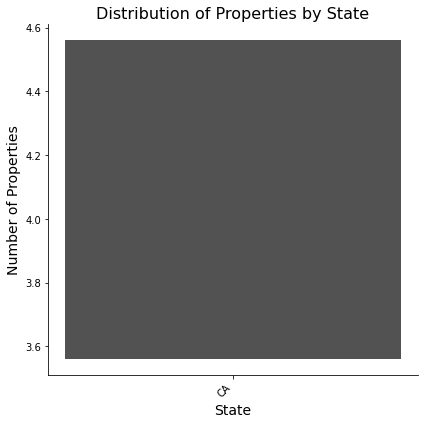

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure and axes
plt.figure(figsize=(6, 6))

# Create the histogram using Seaborn
sns.histplot(data=merged_df, x='state',y=4.06, color="white")

# Add titles and labels with appropriate font sizes
plt.title('Distribution of Properties by State', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Number of Properties', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Remove top and right spines for cleaner look
sns.despine()

# Display the plot
plt.tight_layout()
plt.savefig("Distribution of Properties by State")
plt.show()


# Percentage of Policies with a Claim
   - Method: Calculate the ratio of policies with a `numClaims` greater than 0 to the total number of policies.
   - Formula: `(Number of Policies with numClaims > 0) / (Total Number of Policies)  100`


/tmp/ipykernel_4994/2826450079.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_df, x='state', order=merged_df['state'].value_counts().index, palette='muted')


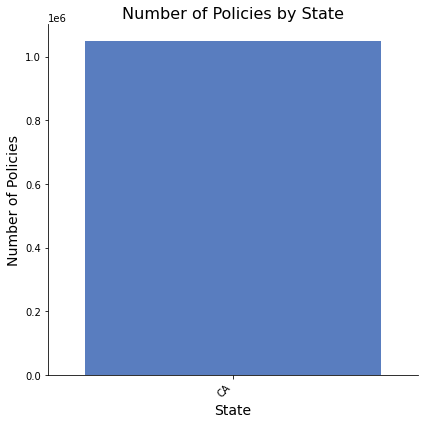

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a larger figure size for better visualization
plt.figure(figsize=(6, 6))

# Create a countplot to show the number of policies by state
sns.countplot(data=merged_df, x='state', order=merged_df['state'].value_counts().index, palette='muted')

# Add titles and labels with increased font size
plt.title('Number of Policies by State', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Number of Policies', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Remove top and right spines for cleaner look
sns.despine()

# Display the plot
plt.tight_layout()
plt.savefig("Number of Policies by State")
plt.show()


# Claims Analysis

    - Bar Chart: Percentage of properties and policies with claims.
    - Box Plot: Claims distribution by construction type.

/tmp/ipykernel_4992/1890443546.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=claims_percentage.index.map({0: 'No', 1: 'Yes'}), y=claims_percentage.values, palette='rocket')


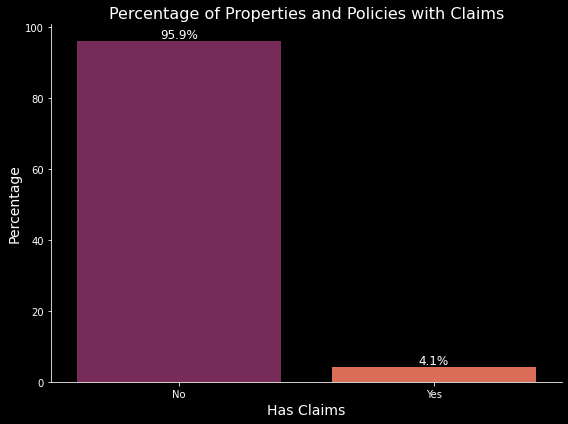

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate percentage of properties and policies with claims
claims_percentage = merged_df['numClaims'].apply(lambda x: 1 if x > 0 else 0).value_counts(normalize=True) * 100

# Create the bar plot with custom styling
plt.figure(figsize=(8, 6))
sns.barplot(x=claims_percentage.index.map({0: 'No', 1: 'Yes'}), y=claims_percentage.values, palette='rocket')

# Add titles and labels with increased font size
plt.title('Percentage of Properties and Policies with Claims', fontsize=16)
plt.xlabel('Has Claims', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

# Customize x-axis tick labels
plt.xticks(rotation=0)

# Add percentages above each bar
for index, value in enumerate(claims_percentage.values):
    plt.text(index, value + 1, f'{value:.1f}%', ha='center', fontsize=12)

# Remove top and right spines for cleaner look
sns.despine()

# Display the plot
plt.tight_layout()
plt.savefig("Percentage of Properties and Policies with Claims")
plt.show()


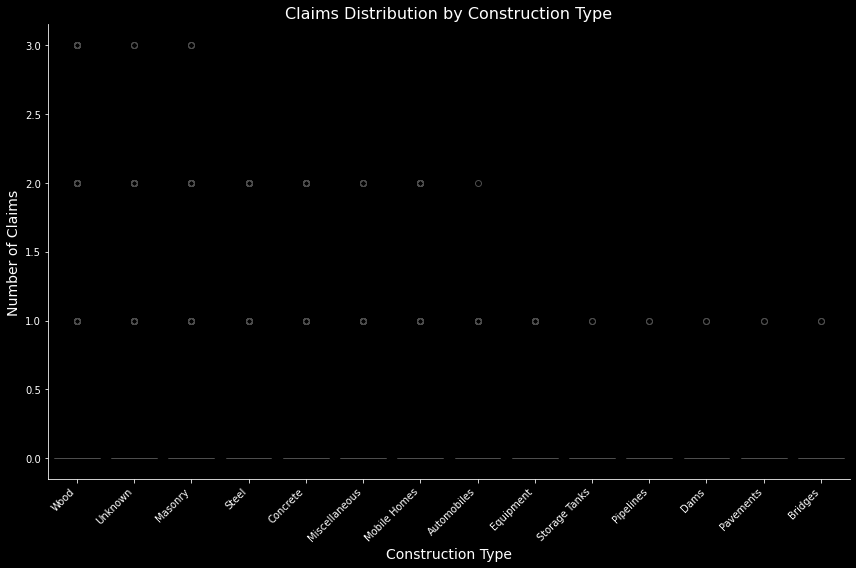

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a larger figure size for better visualization
plt.figure(figsize=(12, 8))

# Create the box plot with custom styling
sns.boxplot(data=merged_df, x='Construction', y='numClaims', color="red")

# Add titles and labels with increased font size
plt.title('Claims Distribution by Construction Type', fontsize=16)
plt.xlabel('Construction Type', fontsize=14)
plt.ylabel('Number of Claims', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Remove top and right spines for cleaner look
sns.despine()

# Display the plot
plt.tight_layout()
plt.savefig("Claims Distribution by Construction Type")
plt.show()


# 2. Risk Analysis
Correlation Analysis

    - Heatmap: Correlation matrix of risk factors.

## Risk Score Calculation

The risk score for each property is calculated based on the following risk factors:
1. **Wildfire Risk**: Calculated as `BUILDINGS_FRACTION_DE_x * 100`.
2. **Crime Risk**: Calculated as `Property_crime / POP_x`.
3. **House Price Risk**: Calculated as `1 / Median_Home_Price_Q2_2017`.
4. **Flood Risk**: Calculated as `numClaims / TOTAL_BUILDINGS_x`.
5. **Storm Risk**: Calculated as `numClaims / TOTAL_BUILDINGS_x`.

Each risk factor is normalized using MinMaxScaler to a range of 0 to 1. The overall risk score is then calculated as a weighted sum of these normalized risk factors, with each factor given an equal weight of 0.2.


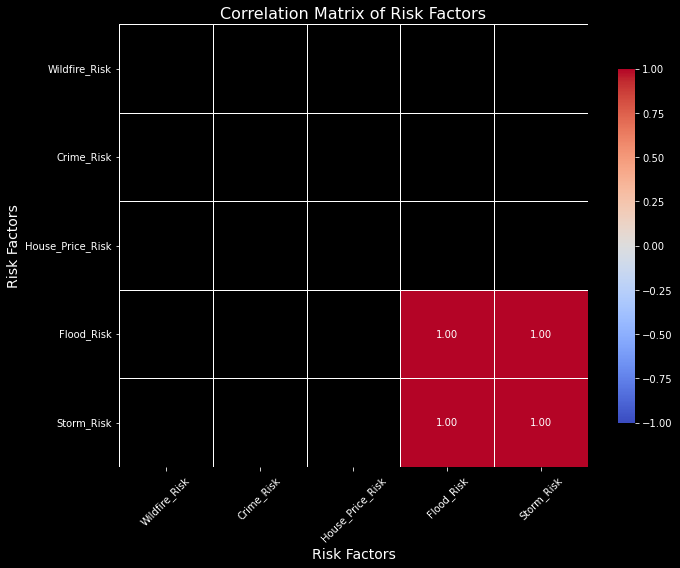

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the risk factors to include in correlation analysis
risk_factors = ['Wildfire_Risk', 'Crime_Risk', 'House_Price_Risk', 'Flood_Risk', 'Storm_Risk']

# Compute the correlation matrix
corr_matrix = merged_df[risk_factors].corr()

# Set up the figure and axis
plt.figure(figsize=(10, 8))

# Create the heatmap with custom styling
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, cbar_kws={'shrink': 0.8})

# Add titles and labels with increased font size
plt.title('Correlation Matrix of Risk Factors', fontsize=16)
plt.xlabel('Risk Factors', fontsize=14)
plt.ylabel('Risk Factors', fontsize=14)

# Adjust the color bar size for better fit
plt.yticks(rotation=0)
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.savefig("Correlation Matrix of Risk Factors")
plt.show()


# 3. Geospatial Analysis
Choropleth Map

    - Distribution of claims and risk scores by county.

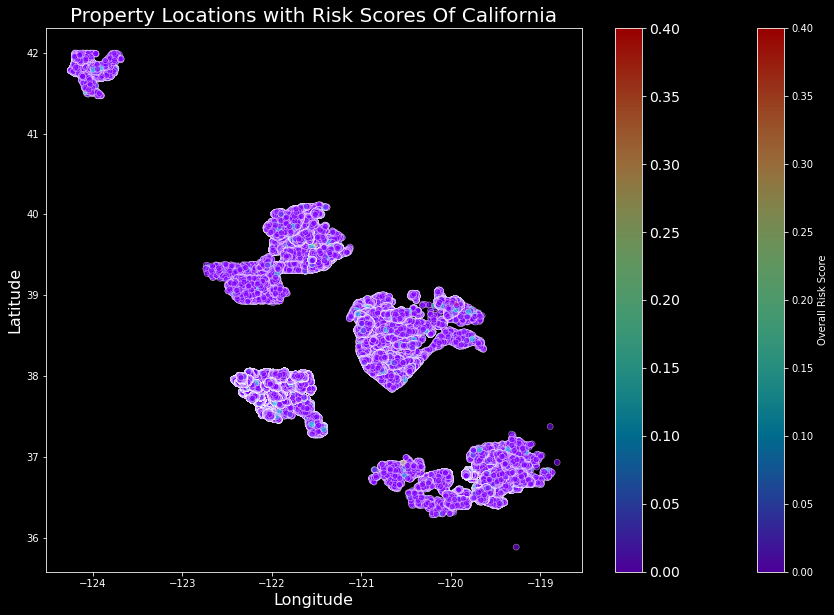

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a dark background style
plt.style.use('dark_background')

# Define the figure size
plt.figure(figsize=(15, 10))

# Define colors for multicolor representation of risk scores
colors = merged_df['Overall_Risk_Score']

# Create the scatter plot with custom styling
plt.scatter(merged_df['Longitude_x'], merged_df['Latitude_x'], c=colors, cmap='rainbow', alpha=0.6, edgecolors='w', linewidths=0.5)

# Add color bar with label
plt.colorbar(label='Overall Risk Score')

# Add title and labels with increased font size
plt.title('Property Locations with Risk Scores Of California', fontsize=20)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)

# Adjust the color bar ticks for better visibility
plt.colorbar().ax.tick_params(labelsize=14)
plt.savefig("Property Locations with Risk Scores Of California")
# Display the plot
plt.show()


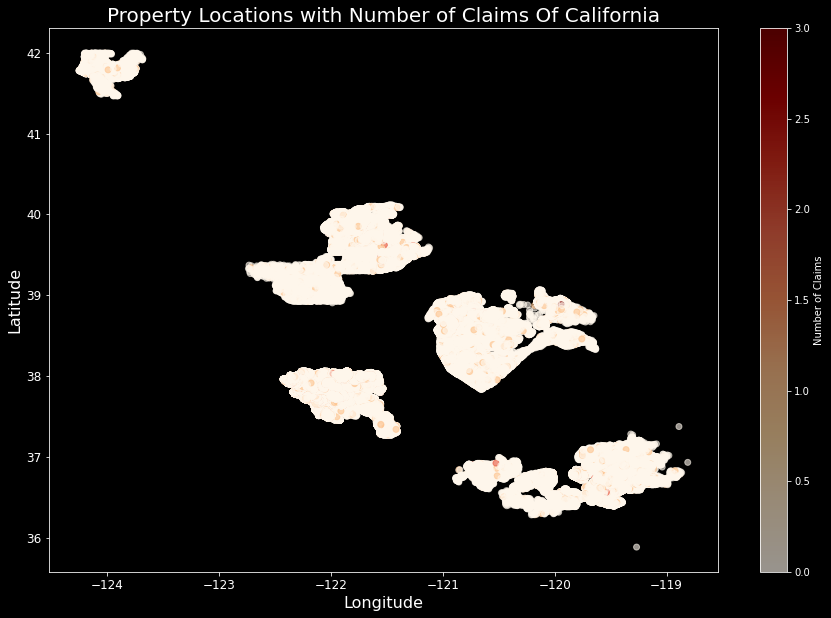

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the longitude and latitude columns are correctly named
longitude_col = 'Longitude_x'
latitude_col = 'Latitude_x'

# Scatter Plot: Property locations with the number of claims
plt.figure(figsize=(15, 10))
scatter = plt.scatter(merged_df[longitude_col], merged_df[latitude_col], c=merged_df['numClaims'], cmap='OrRd', alpha=0.6)
plt.colorbar(label='Number of Claims')
plt.title('Property Locations with Number of Claims Of California', fontsize=20)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("Property Locations with Number of Claims Of California")
plt.show()


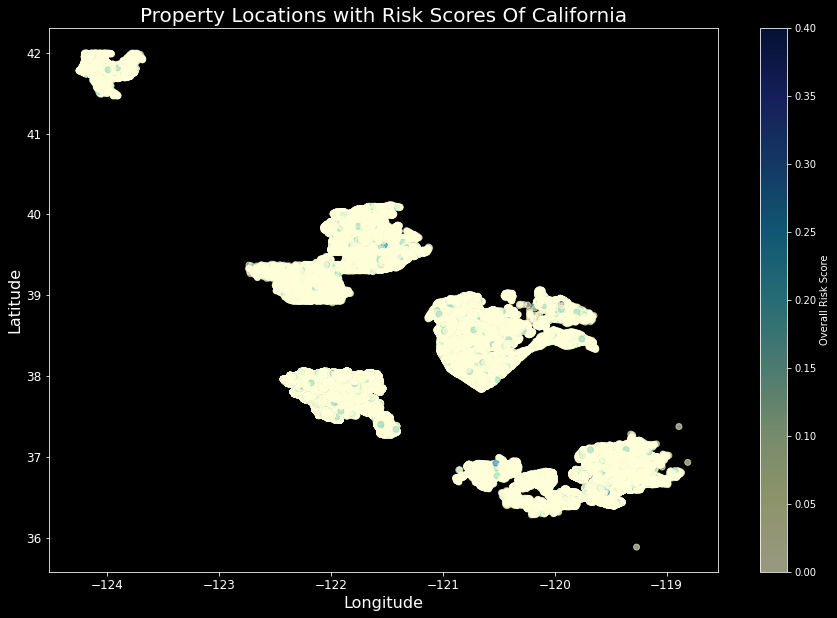

In [33]:
# Scatter Plot: Property locations with risk scores
plt.figure(figsize=(15, 10))
scatter = plt.scatter(merged_df[longitude_col], merged_df[latitude_col], c=merged_df['Overall_Risk_Score'], cmap='YlGnBu', alpha=0.6)
plt.colorbar(label='Overall Risk Score')
plt.title('Property Locations with Risk Scores Of California', fontsize=20)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("Property Locations with Risk Scores 2 Of California")
plt.show()


# Geospatial Risk Mapping
   - Visualization: Create maps to visualize the distribution of properties relative to wildfire and earthquake risk zones.
   - Insights: Identify high-risk areas and assess the correlation between risk exposure and claim frequency.


# WildFire

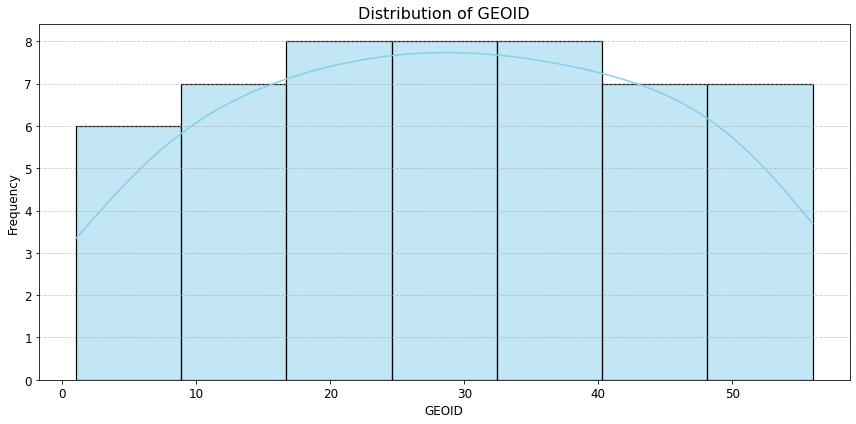

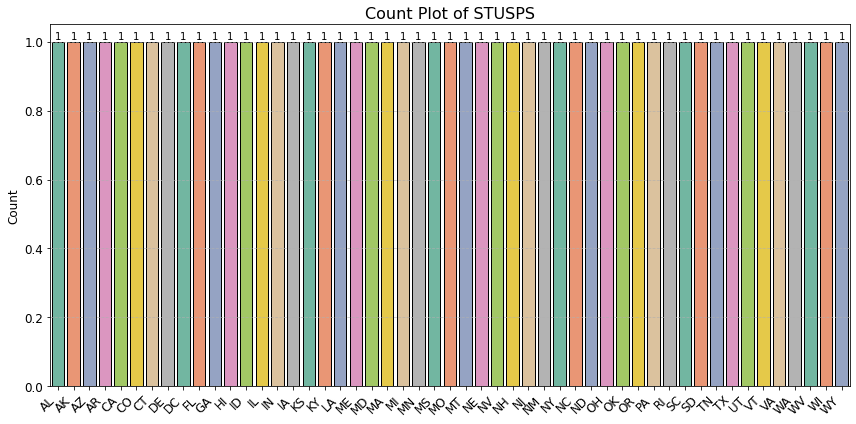

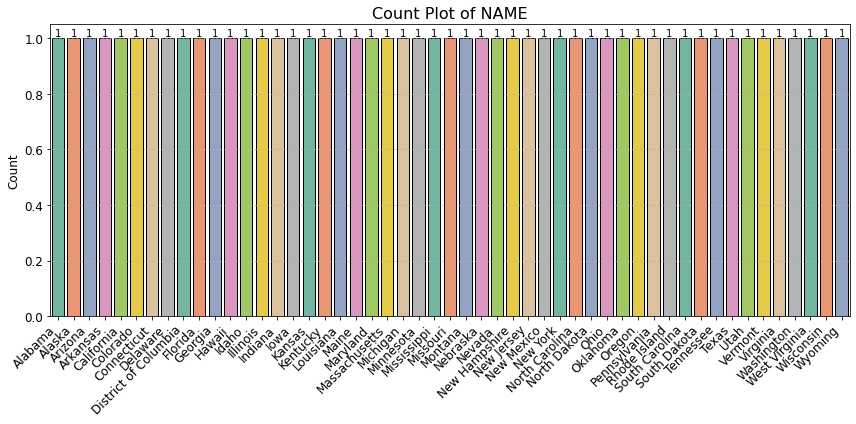

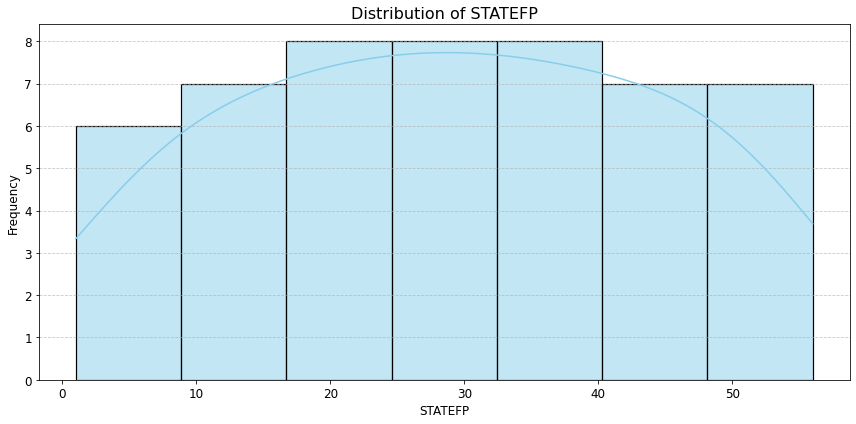

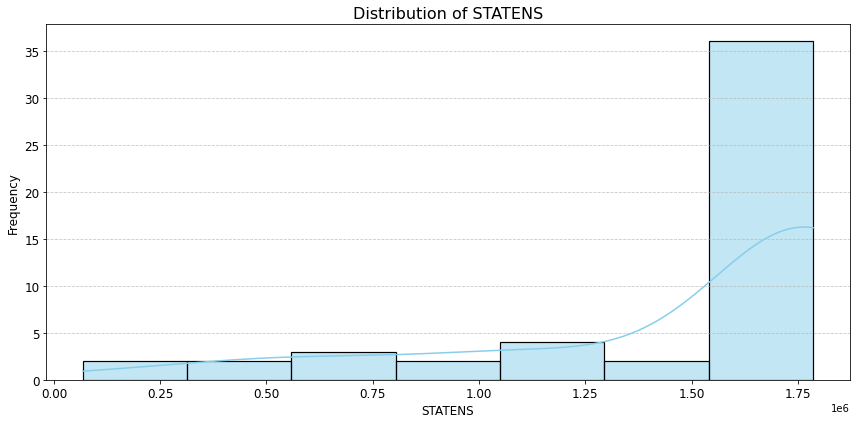

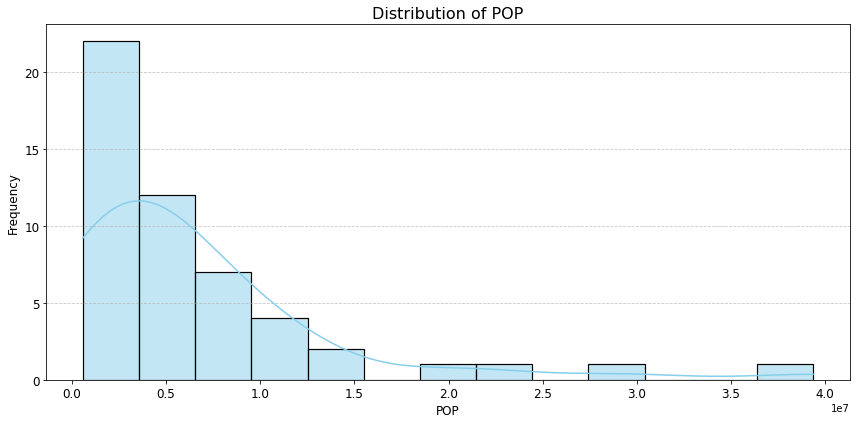

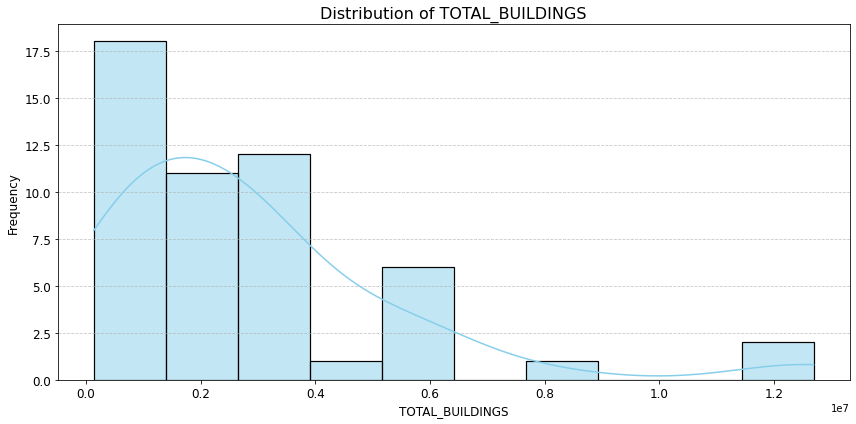

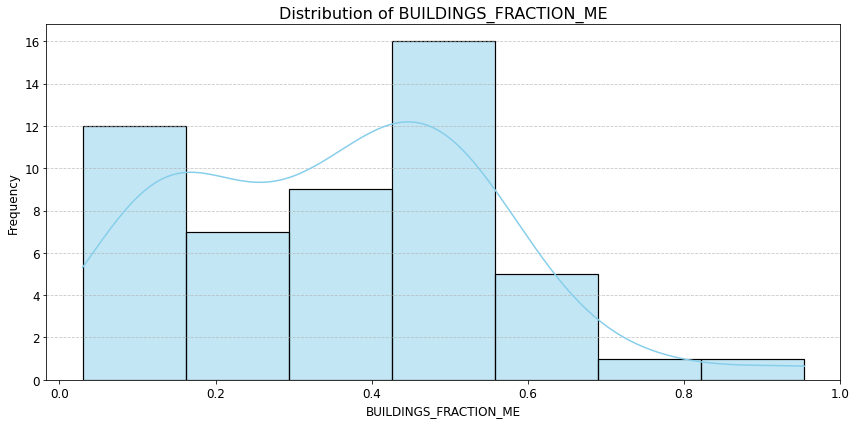

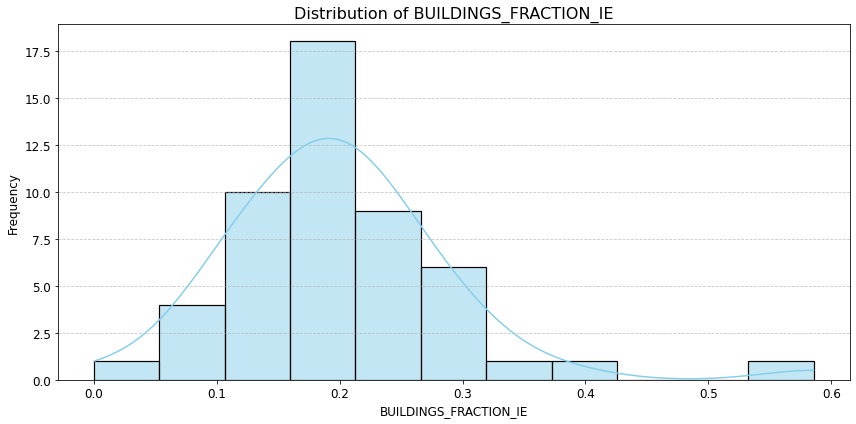

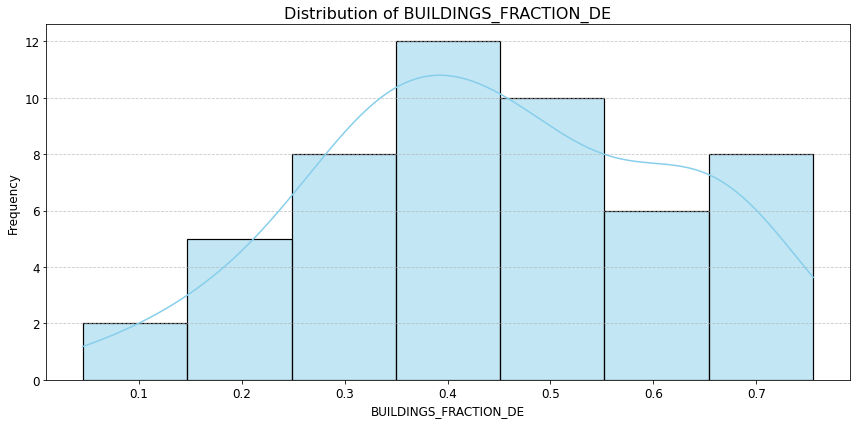

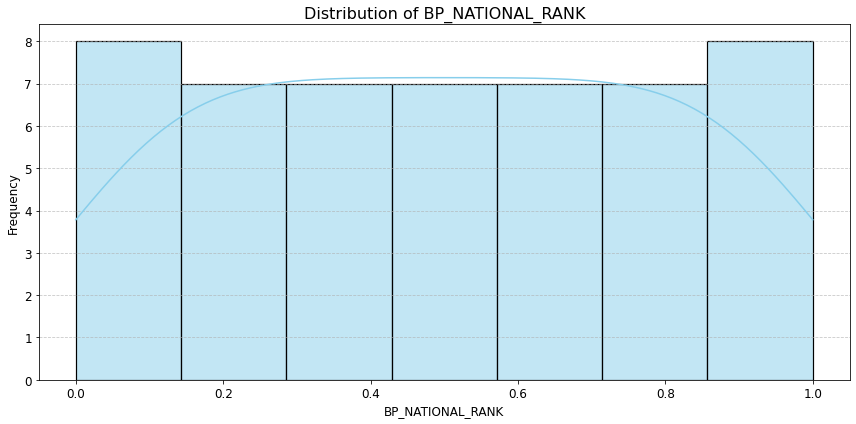

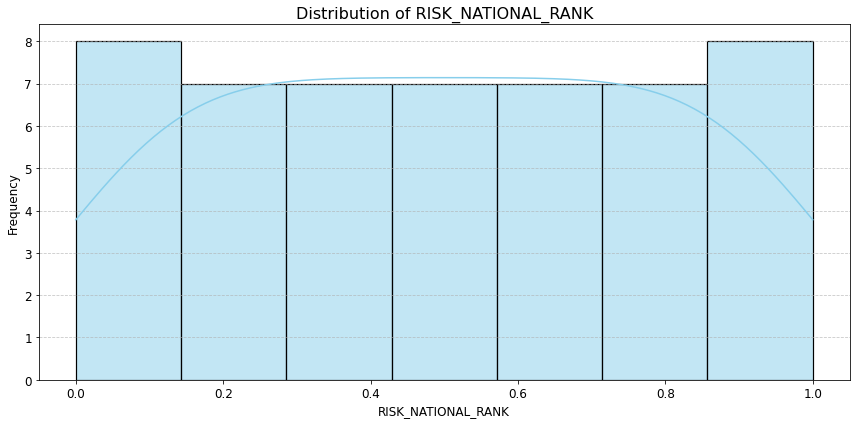

In [29]:
# Plotting each column with enhanced aesthetics
for column in state_usa_df.columns:
    plt.figure(figsize=(12, 6))

    if state_usa_df[column].dtype == 'object':
        # Categorical column plot (bar plot)
        sns.countplot(x=column, data=state_usa_df, palette='Set2', edgecolor='black')
        plt.title(f'Count Plot of {column}', fontsize=16)
        plt.xticks(rotation=45, ha='right', fontsize=12)
        plt.xlabel('')
        plt.ylabel('Count', fontsize=12)

        # Add value counts as text on top of each bar
        for p in plt.gca().patches:
            plt.gca().annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                               ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                               textcoords='offset points')

    else:
        # Numeric column plot (histogram with KDE)
        sns.histplot(state_usa_df[column], kde=True, color='skyblue', edgecolor='black', linewidth=1.2)
        plt.title(f'Distribution of {column}', fontsize=16)
        plt.xlabel(column, fontsize=12)
        plt.ylabel('Frequency', fontsize=12)

    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'Distribution of {column} for state_usa')
    plt.show()

In [30]:
# Exclude text data columns (object dtype)
numeric_columns = state_usa_df.select_dtypes(include=['int64', 'float64']).columns

# Filter DataFrame to include only numeric columns
numeric_df = state_usa_df[numeric_columns]

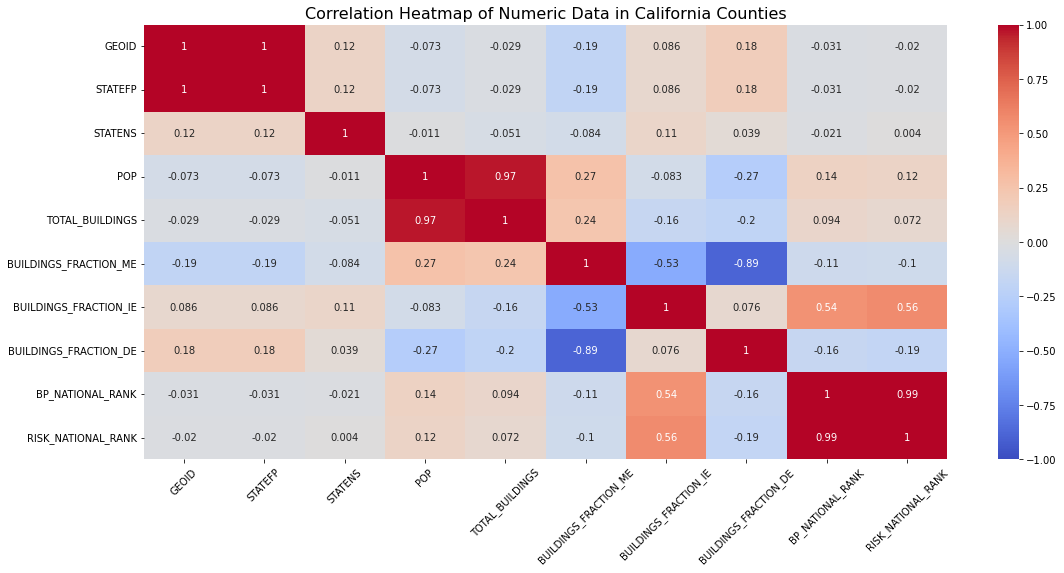

In [31]:
# Calculate correlation matrix for numeric columns
corr_matrix = numeric_df.corr()

# Plotting correlation heatmap
plt.figure(figsize=(18, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Data in California Counties', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.savefig("Correlation Heatmap of Wildfire in California Counties")
plt.show()

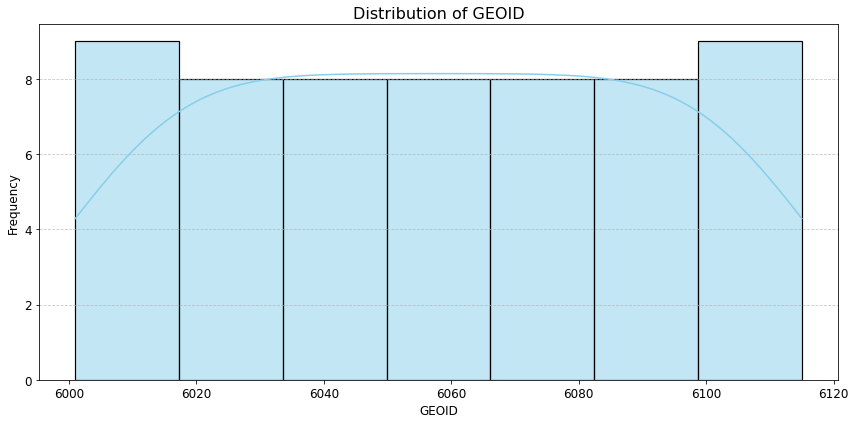

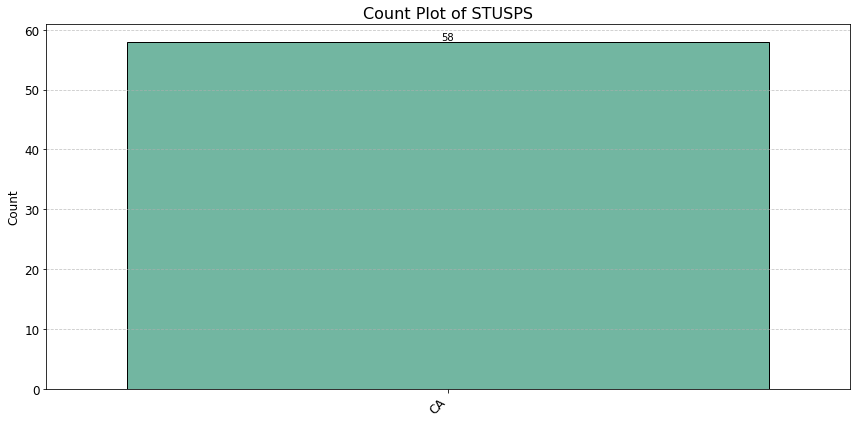

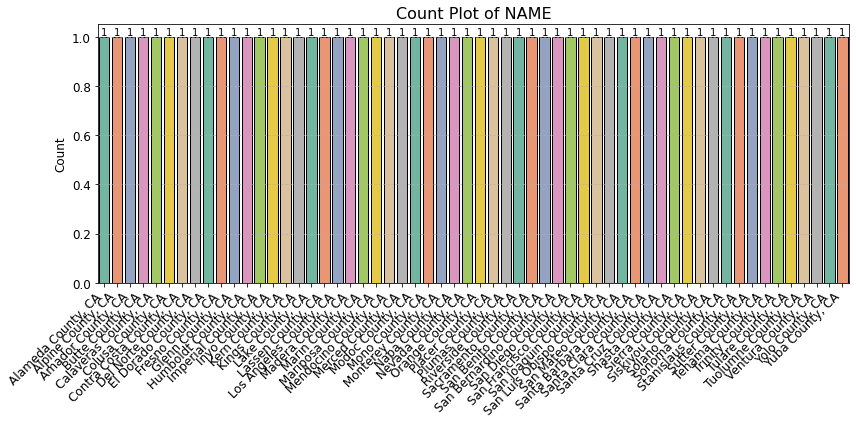

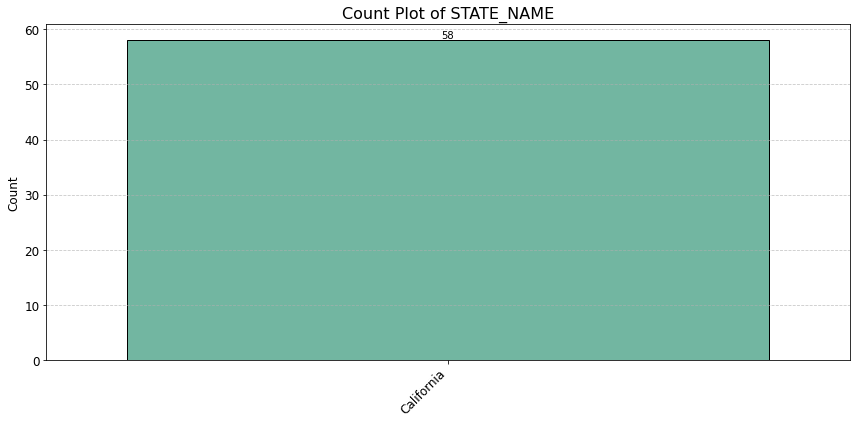

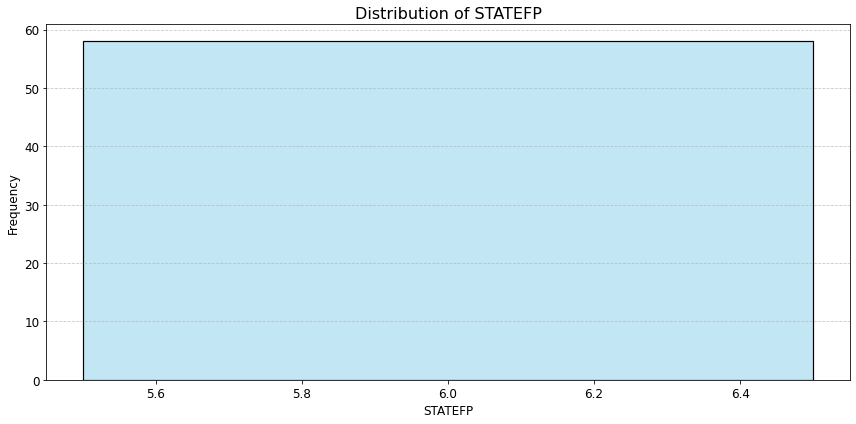

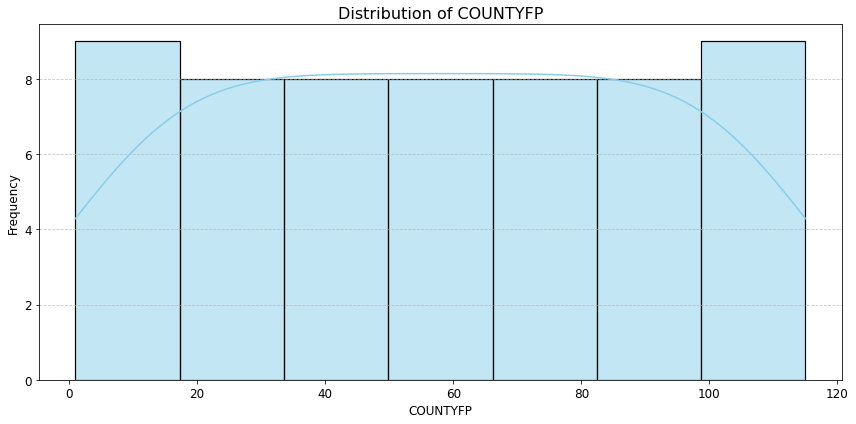

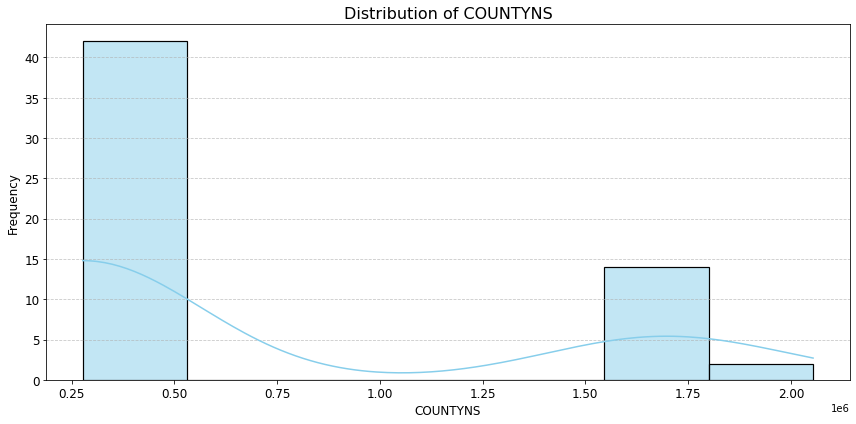

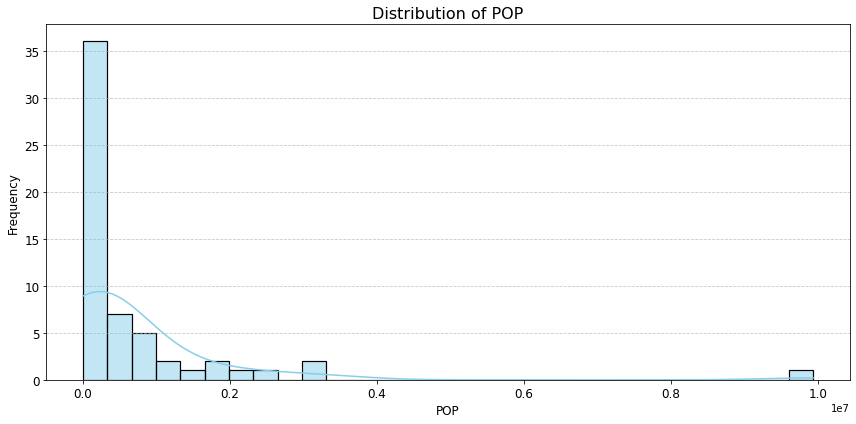

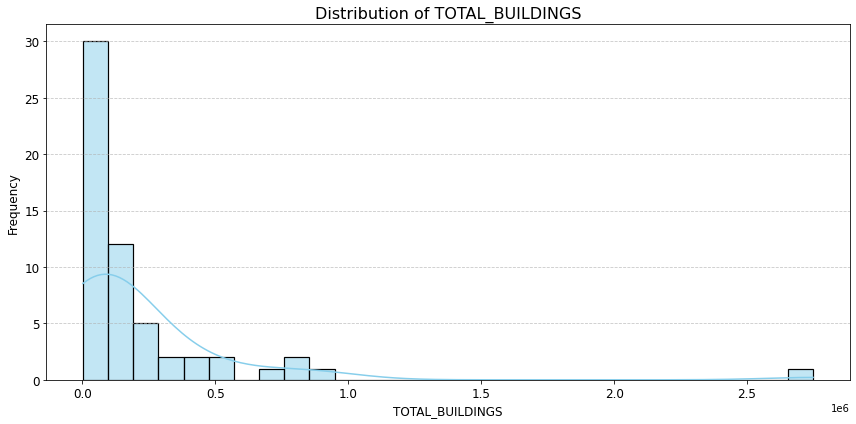

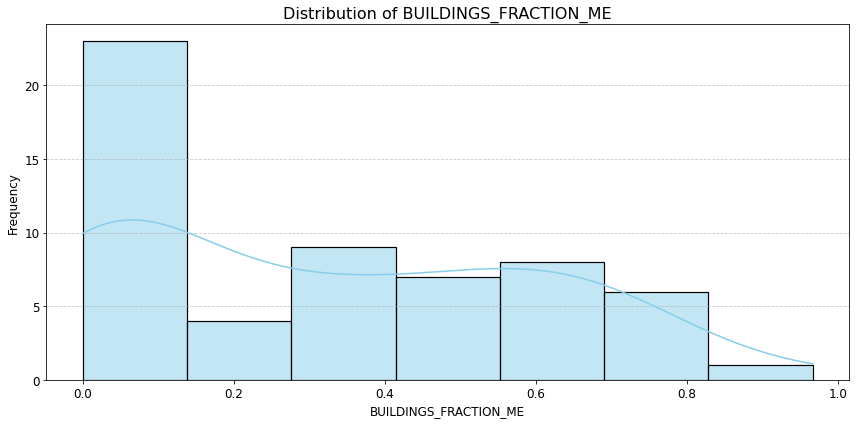

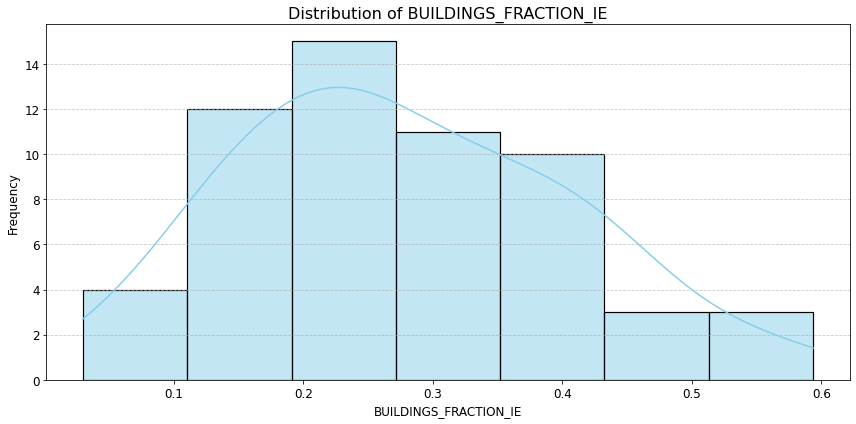

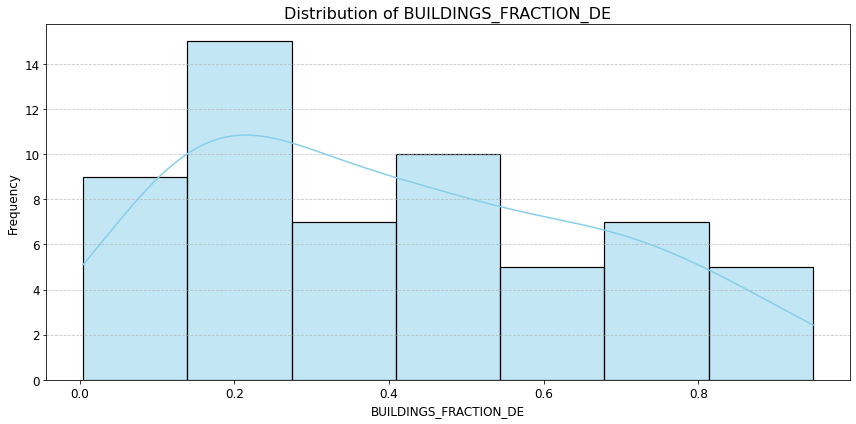

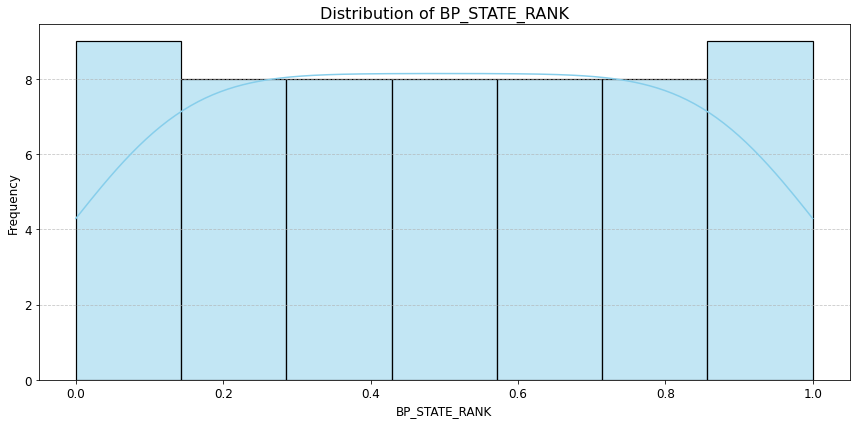

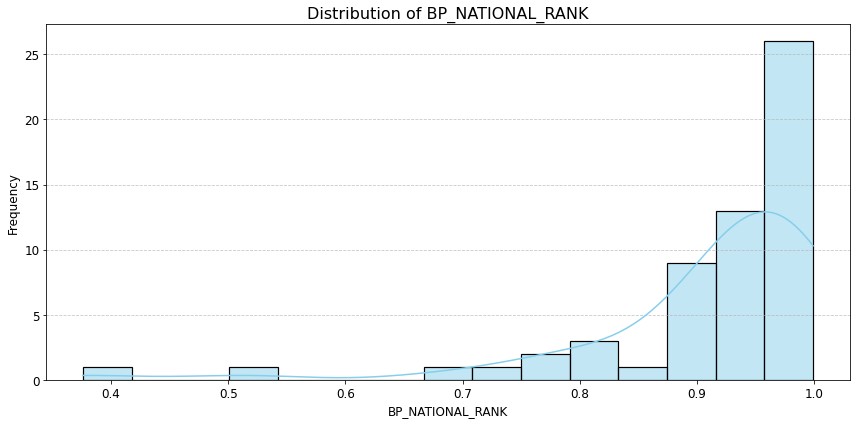

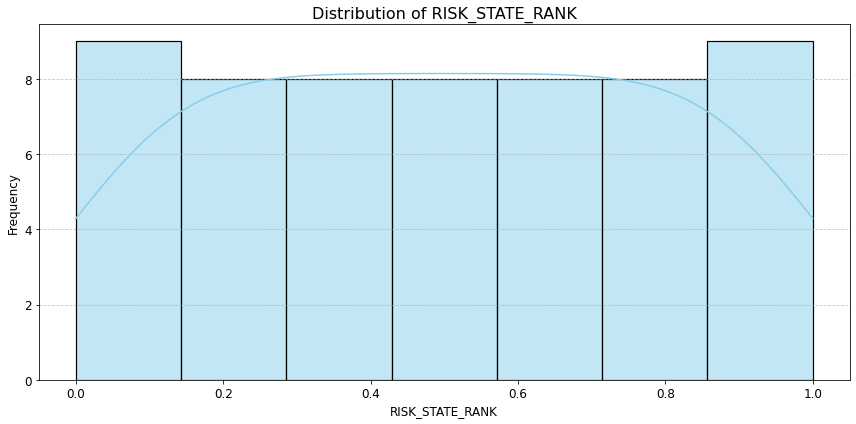

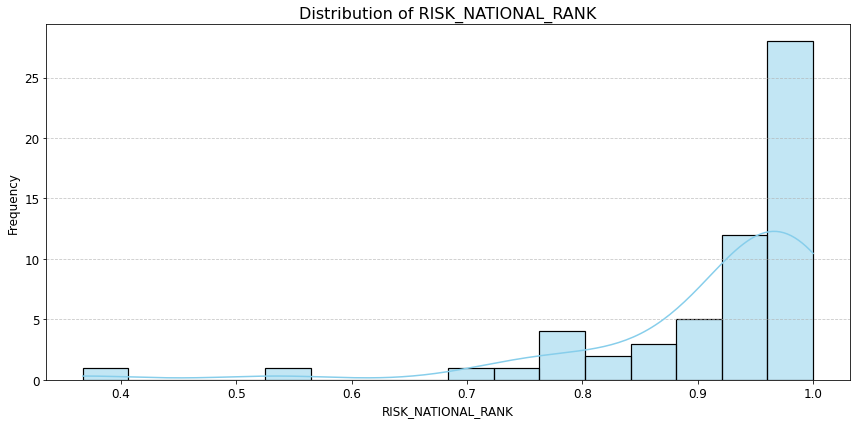

In [32]:
# Plotting each column with enhanced aesthetics
for column in california_counties_df.columns:
    plt.figure(figsize=(12, 6))

    if california_counties_df[column].dtype == 'object':
        # Categorical column plot (bar plot)
        sns.countplot(x=column, data=california_counties_df, palette='Set2', edgecolor='black')
        plt.title(f'Count Plot of {column}', fontsize=16)
        plt.xticks(rotation=45, ha='right', fontsize=12)
        plt.xlabel('')
        plt.ylabel('Count', fontsize=12)

        # Add value counts as text on top of each bar
        for p in plt.gca().patches:
            plt.gca().annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                               ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                               textcoords='offset points')

    else:
        # Numeric column plot (histogram with KDE)
        sns.histplot(california_counties_df[column], kde=True, color='skyblue', edgecolor='black', linewidth=1.2)
        plt.title(f'Distribution of {column}', fontsize=16)
        plt.xlabel(column, fontsize=12)
        plt.ylabel('Frequency', fontsize=12)

    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'Distribution of {column} for California')
    plt.show()

In [33]:
# Exclude text data columns (object dtype)
numeric_columns = california_counties_df.select_dtypes(include=['int64', 'float64']).columns

# Filter DataFrame to include only numeric columns
numeric_df = california_counties_df[numeric_columns]

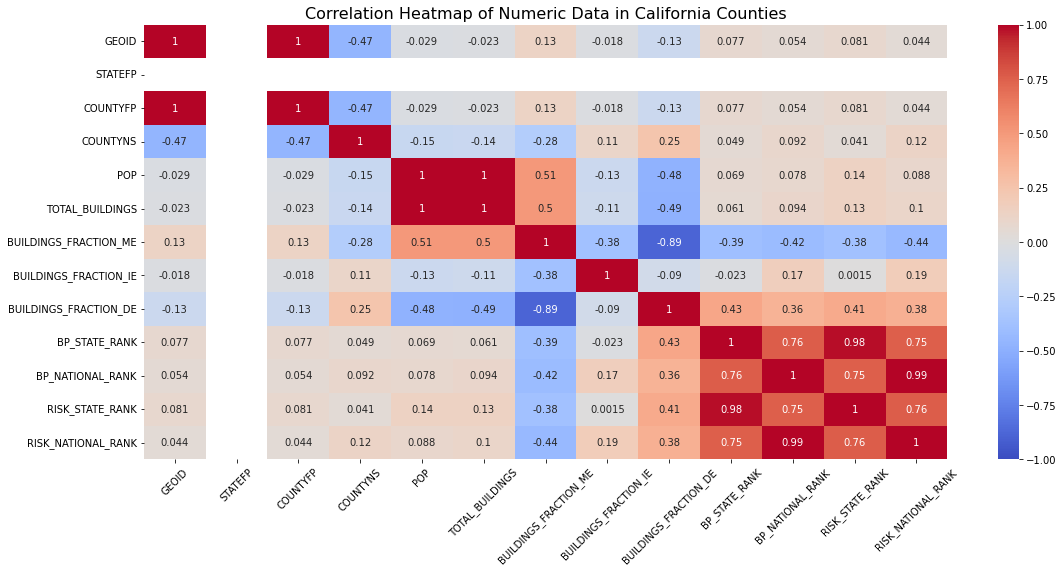

In [34]:
# Calculate correlation matrix for numeric columns
corr_matrix = numeric_df.corr()

# Plotting correlation heatmap
plt.figure(figsize=(18, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Data in California Counties', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.savefig("Correlation Heatmap of Wildfire in California Counties")
plt.show()


# Real Estate and Construction Cost Impact
   - Analysis: Correlate median home prices, construction types, and other provided financial data with claim rates and average premiums.
   - Insights: Determine if higher-value properties or specific construction types are associated with higher claims.


In [40]:
# Remove any '\r' characters from column names
house_prices.columns = [col.replace('\r', '') for col in house_prices.columns]

In [43]:
house_prices

State AlCaobuanmtay Name MedianHome PriceQ2 2017  \
0        Autauga County           $143,867                    $581   
1        Baldwin County           $184,949                    $747   
2        Barbour County            $97,341                    $393   
3           Bibb County           $117,562                    $475   
4         Blount County           $137,136                    $554   
...                 ...                ...                     ...   
3114  Sweetwater County           $207,158                    $837   
3115       Teton County           $747,676                  $3,022   
3116       Uinta County           $191,748                    $775   
3117    Washakie County           $174,494                    $705   
3118      Weston County           $193,375                    $782   

     MonthlyPayment(r=3.5%) MonthlyPayment(r=4.2%) MonthlyPayment(r=5.0%)  
0                      $633                   $695                    NaN  
1                      $814                   $894                    NaN  
2                      $428                   $470                    NaN  
3                      $517                   $568                    NaN  
4                      $604                   $663                    NaN  
...                     ...                    ...                    ...  
3114                   $912                 $1,001                    NaN  
3115                 $3,291                 $3,612                    NaN  
3116                   $844                   $926                    NaN  
3117                   $768                   $843                    NaN  
3118                   $851                   $934                    NaN  

[3119 rows x 6 columns]

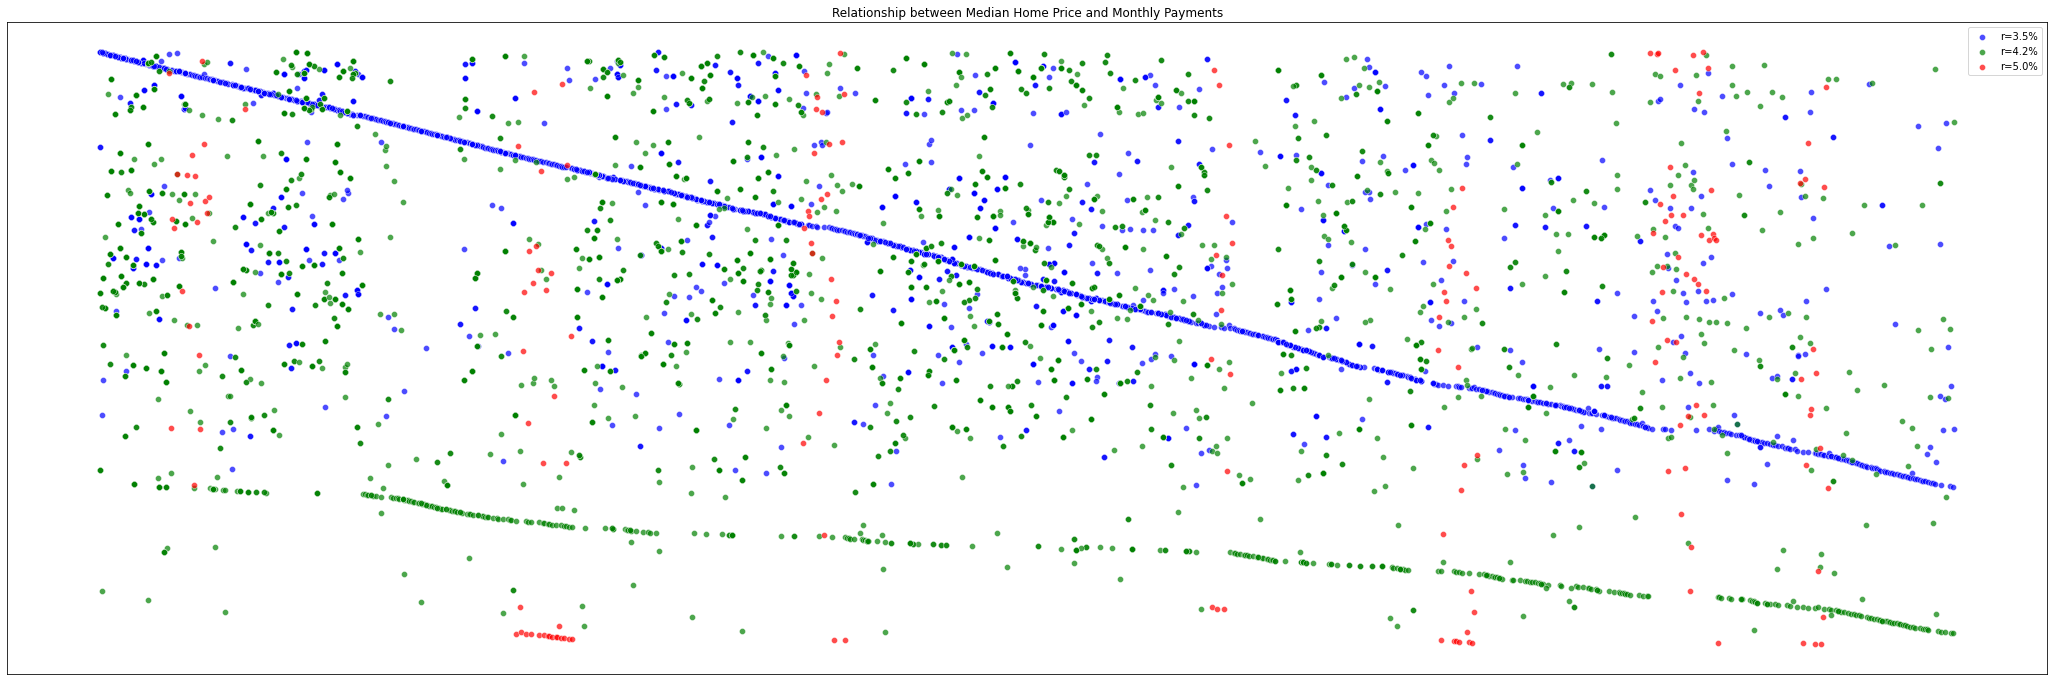

In [45]:
# Prepare the data for plotting
plt.figure(figsize=(30, 10))
sns.scatterplot(x='MedianHome PriceQ2 2017', y='MonthlyPayment(r=3.5%)', data=house_prices, label='r=3.5%', color='blue', alpha=0.7)
sns.scatterplot(x='MedianHome PriceQ2 2017', y='MonthlyPayment(r=4.2%)', data=house_prices, label='r=4.2%', color='green', alpha=0.7)
sns.scatterplot(x='MedianHome PriceQ2 2017', y='MonthlyPayment(r=5.0%)', data=house_prices, label='r=5.0%', color='red', alpha=0.7)

# Customize the plot
plt.title('Relationship between Median Home Price and Monthly Payments')
plt.xlabel('Median Home Price Q2 2017')
plt.ylabel('Monthly Payment')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Hide axis labels and ticks
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
# Show the plot
plt.savefig("Relationship between Median Home Price and Monthly Payments")
plt.show()

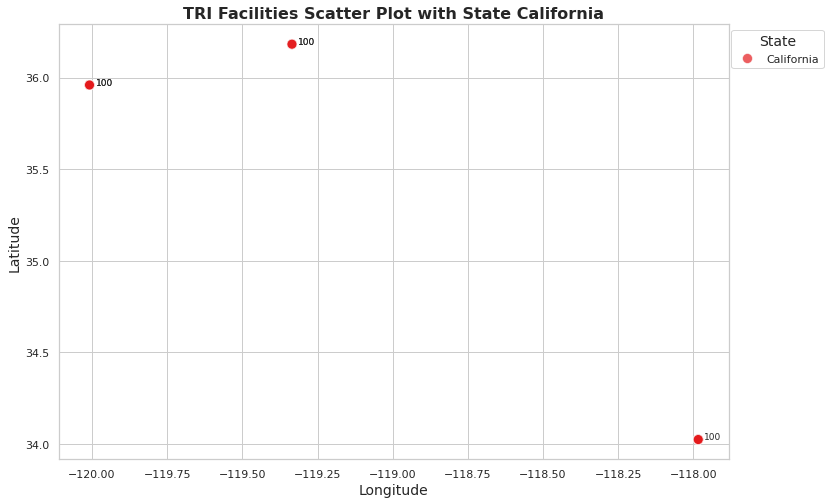

In [52]:
# Set style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("Set1")

# Create a scatter plot with enhanced features
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    x='Longitude', y='Latitude', data=tri_toxic, hue='State', 
    palette=palette, s=100, edgecolor='w', alpha=0.7
)

# Add titles and labels
plt.title('TRI Facilities Scatter Plot with State California', fontsize=16, fontweight='bold')
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)

# Customize the legend
legend = scatter.legend(title='State', title_fontsize='13', fontsize='11', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.setp(legend.get_title(), fontsize=14)  # Legend title font size

# Add annotations for a few points
for i, row in tri_toxic.iterrows():
    if i % 10 == 0:  # Annotate every 10th point to avoid clutter
        plt.text(row['Longitude'] + 0.02, row['Latitude'],s=100, fontsize=9)

# Save and show plot
plt.savefig("TRI_Facilities_Scatter_Plot_with_State_California.png", bbox_inches='tight')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


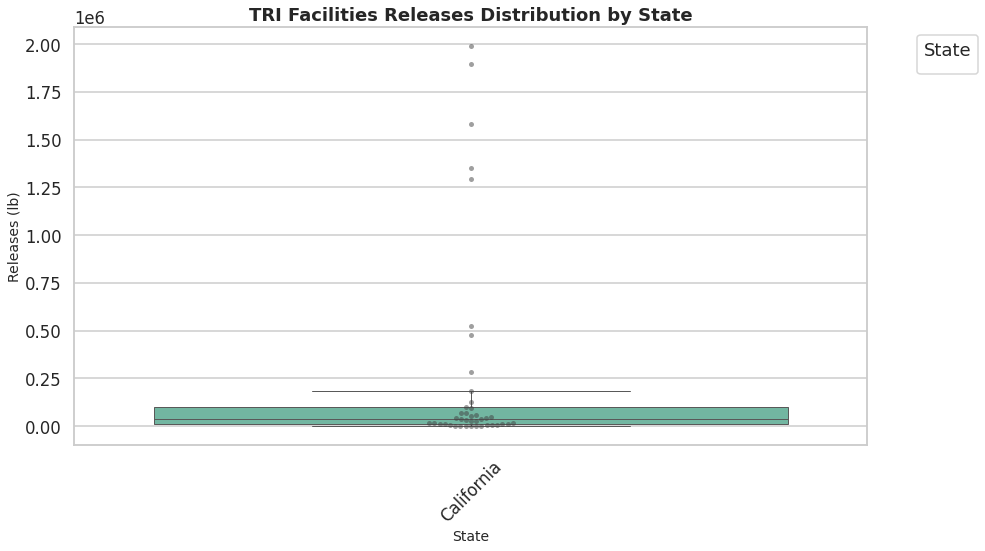

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming tri_toxic is your DataFrame

# Replace non-numeric values with NaN
tri_toxic['Releases (lb)'] = pd.to_numeric(tri_toxic['Releases (lb)'], errors='coerce')

# Drop rows with NaN values in the 'Releases (lb)' column
tri_toxic.dropna(subset=['Releases (lb)'], inplace=True)

# Set style and context
sns.set(style="whitegrid", context="talk")

# Create a box plot with additional swarm plot for better visualization
plt.figure(figsize=(14, 8))
box = sns.boxplot(x='State', y='Releases (lb)', data=tri_toxic, palette='Set2', showfliers=False)
swarm = sns.swarmplot(x='State', y='Releases (lb)', data=tri_toxic, color=".25", alpha=0.5)

# Add titles and labels
plt.title('TRI Facilities Releases Distribution by State', fontsize=18, fontweight='bold')
plt.xlabel('State', fontsize=14)
plt.ylabel('Releases (lb)', fontsize=14)

# Customize the legend
plt.legend(title='State', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show plot
plt.tight_layout()
plt.savefig("TRI Facilities Releases Distribution by State Box Plot")
plt.show()


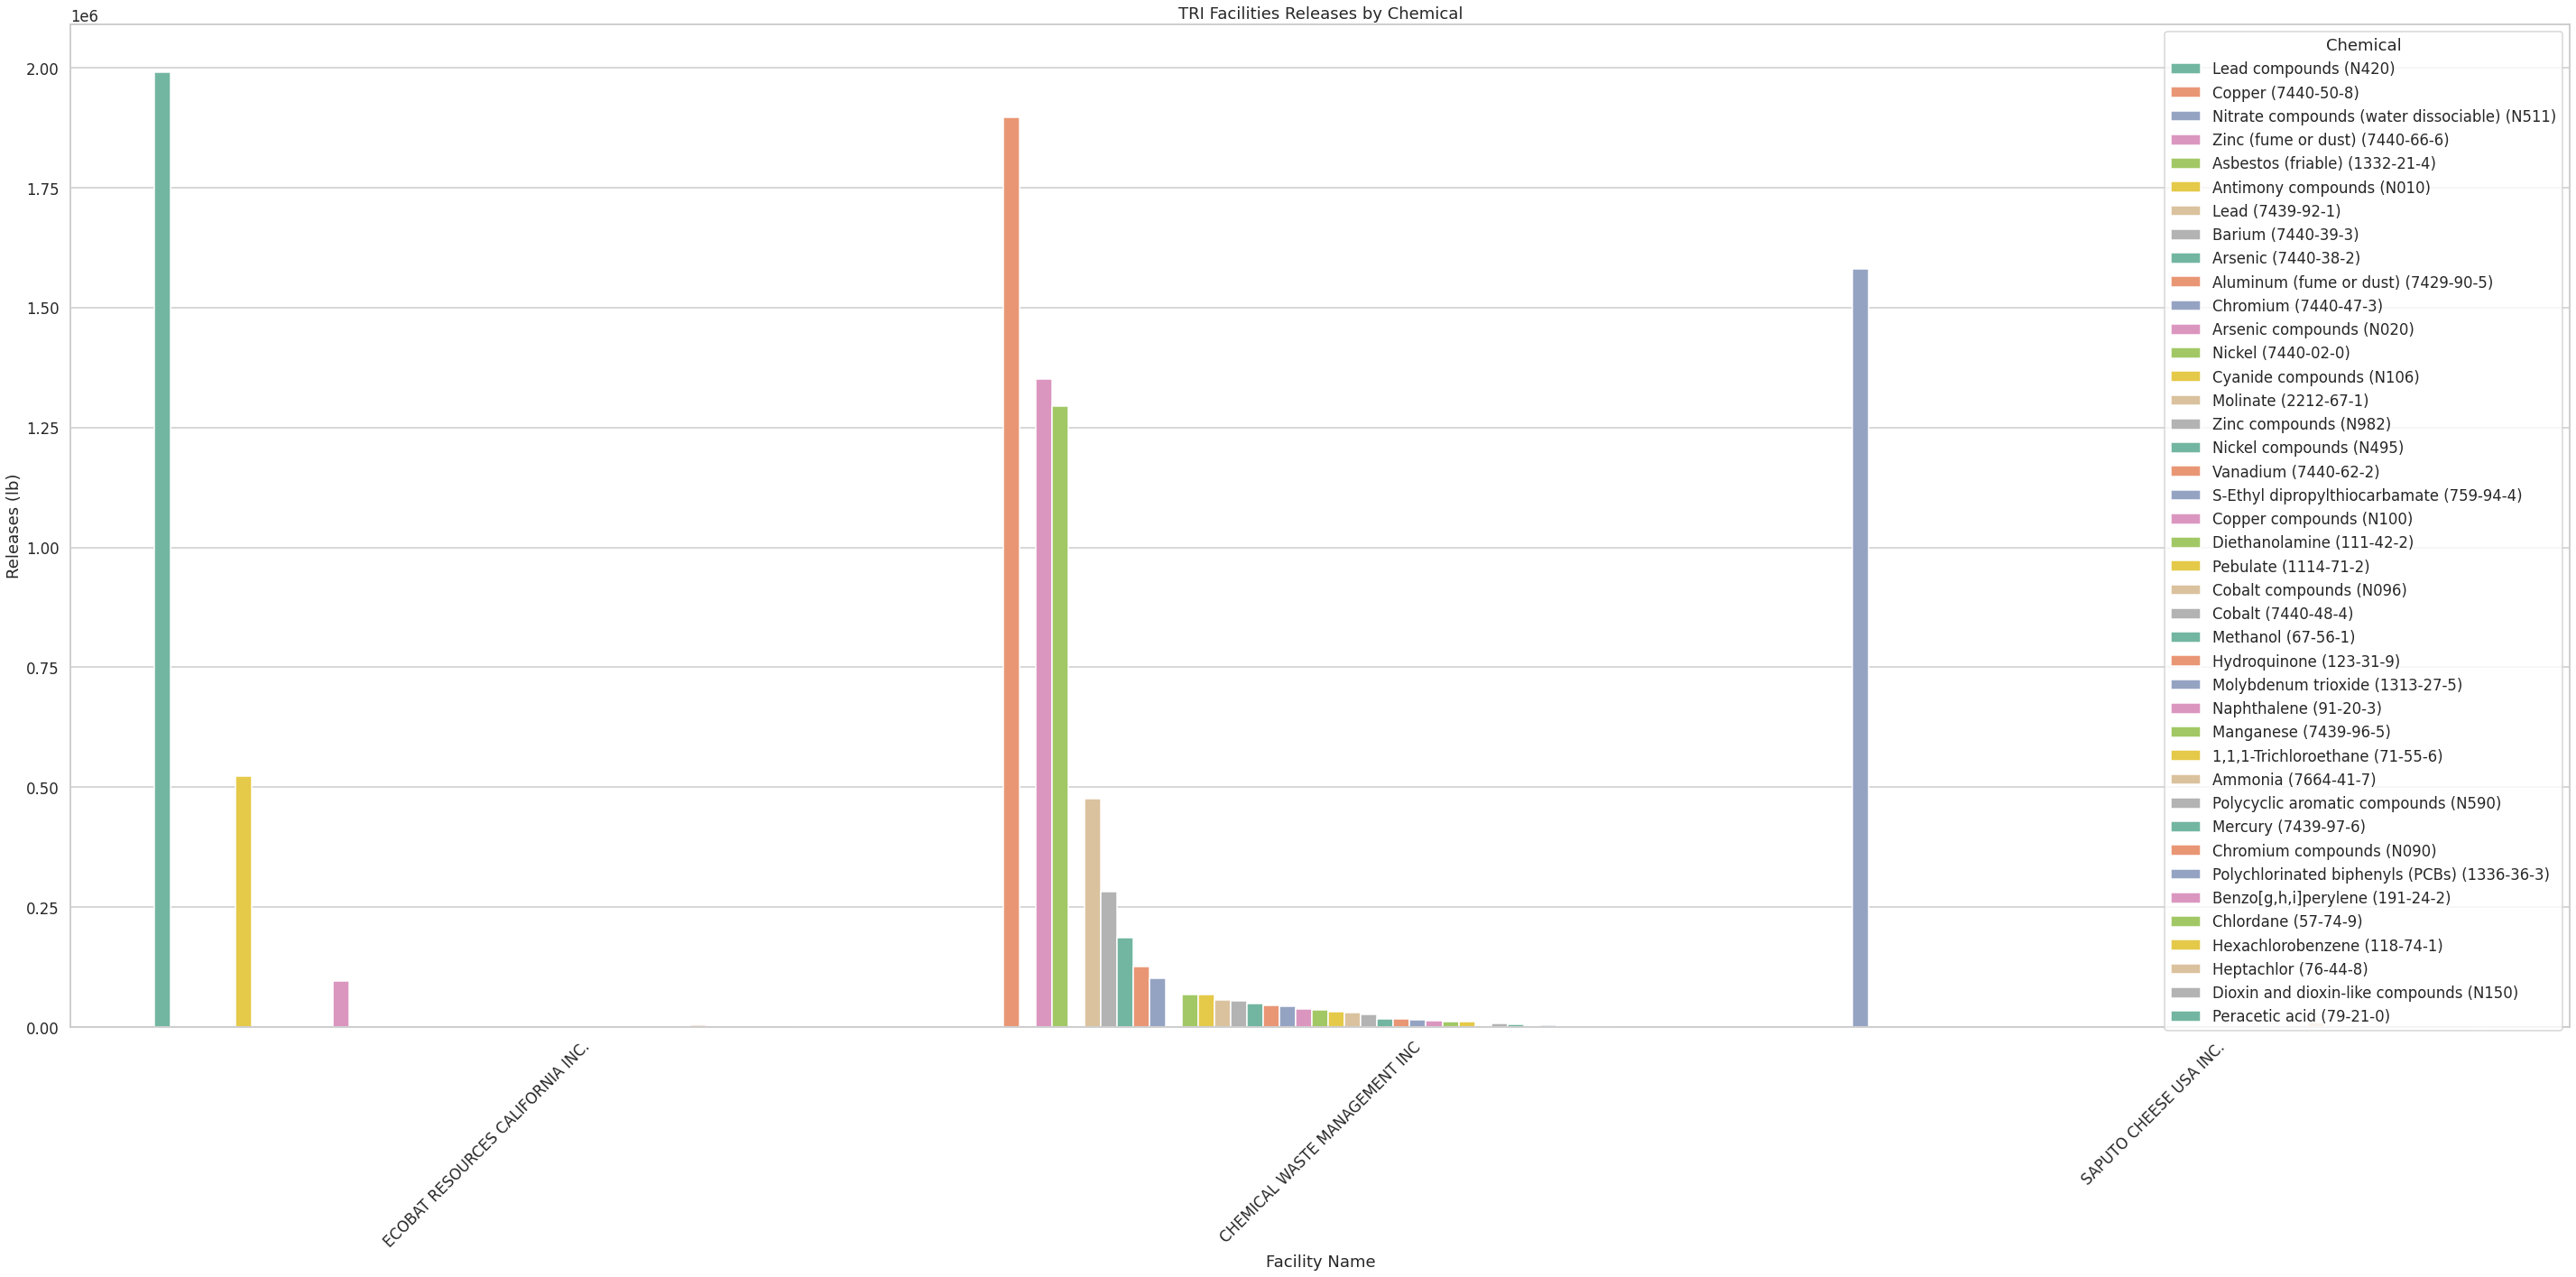

In [55]:
# Replace non-numeric values with NaN
tri_toxic['Releases (lb)'] = pd.to_numeric(tri_toxic['Releases (lb)'], errors='coerce')

# Drop rows with NaN values in the 'Releases (lb)' column
tri_toxic.dropna(subset=['Releases (lb)'], inplace=True)

# Bar plot with hue based on Chemical
plt.figure(figsize=(40, 20))
sns.barplot(x='TRI Facility Name', y='Releases (lb)', data=tri_toxic, hue='Chemical', palette='Set2')
plt.title('TRI Facilities Releases by Chemical')
plt.xlabel('Facility Name')
plt.ylabel('Releases (lb)')
plt.xticks(rotation=45)
plt.legend(title='Chemical', loc='upper right')
plt.tight_layout()
plt.savefig("TRI Facilities Releases by Chemical")
plt.show()

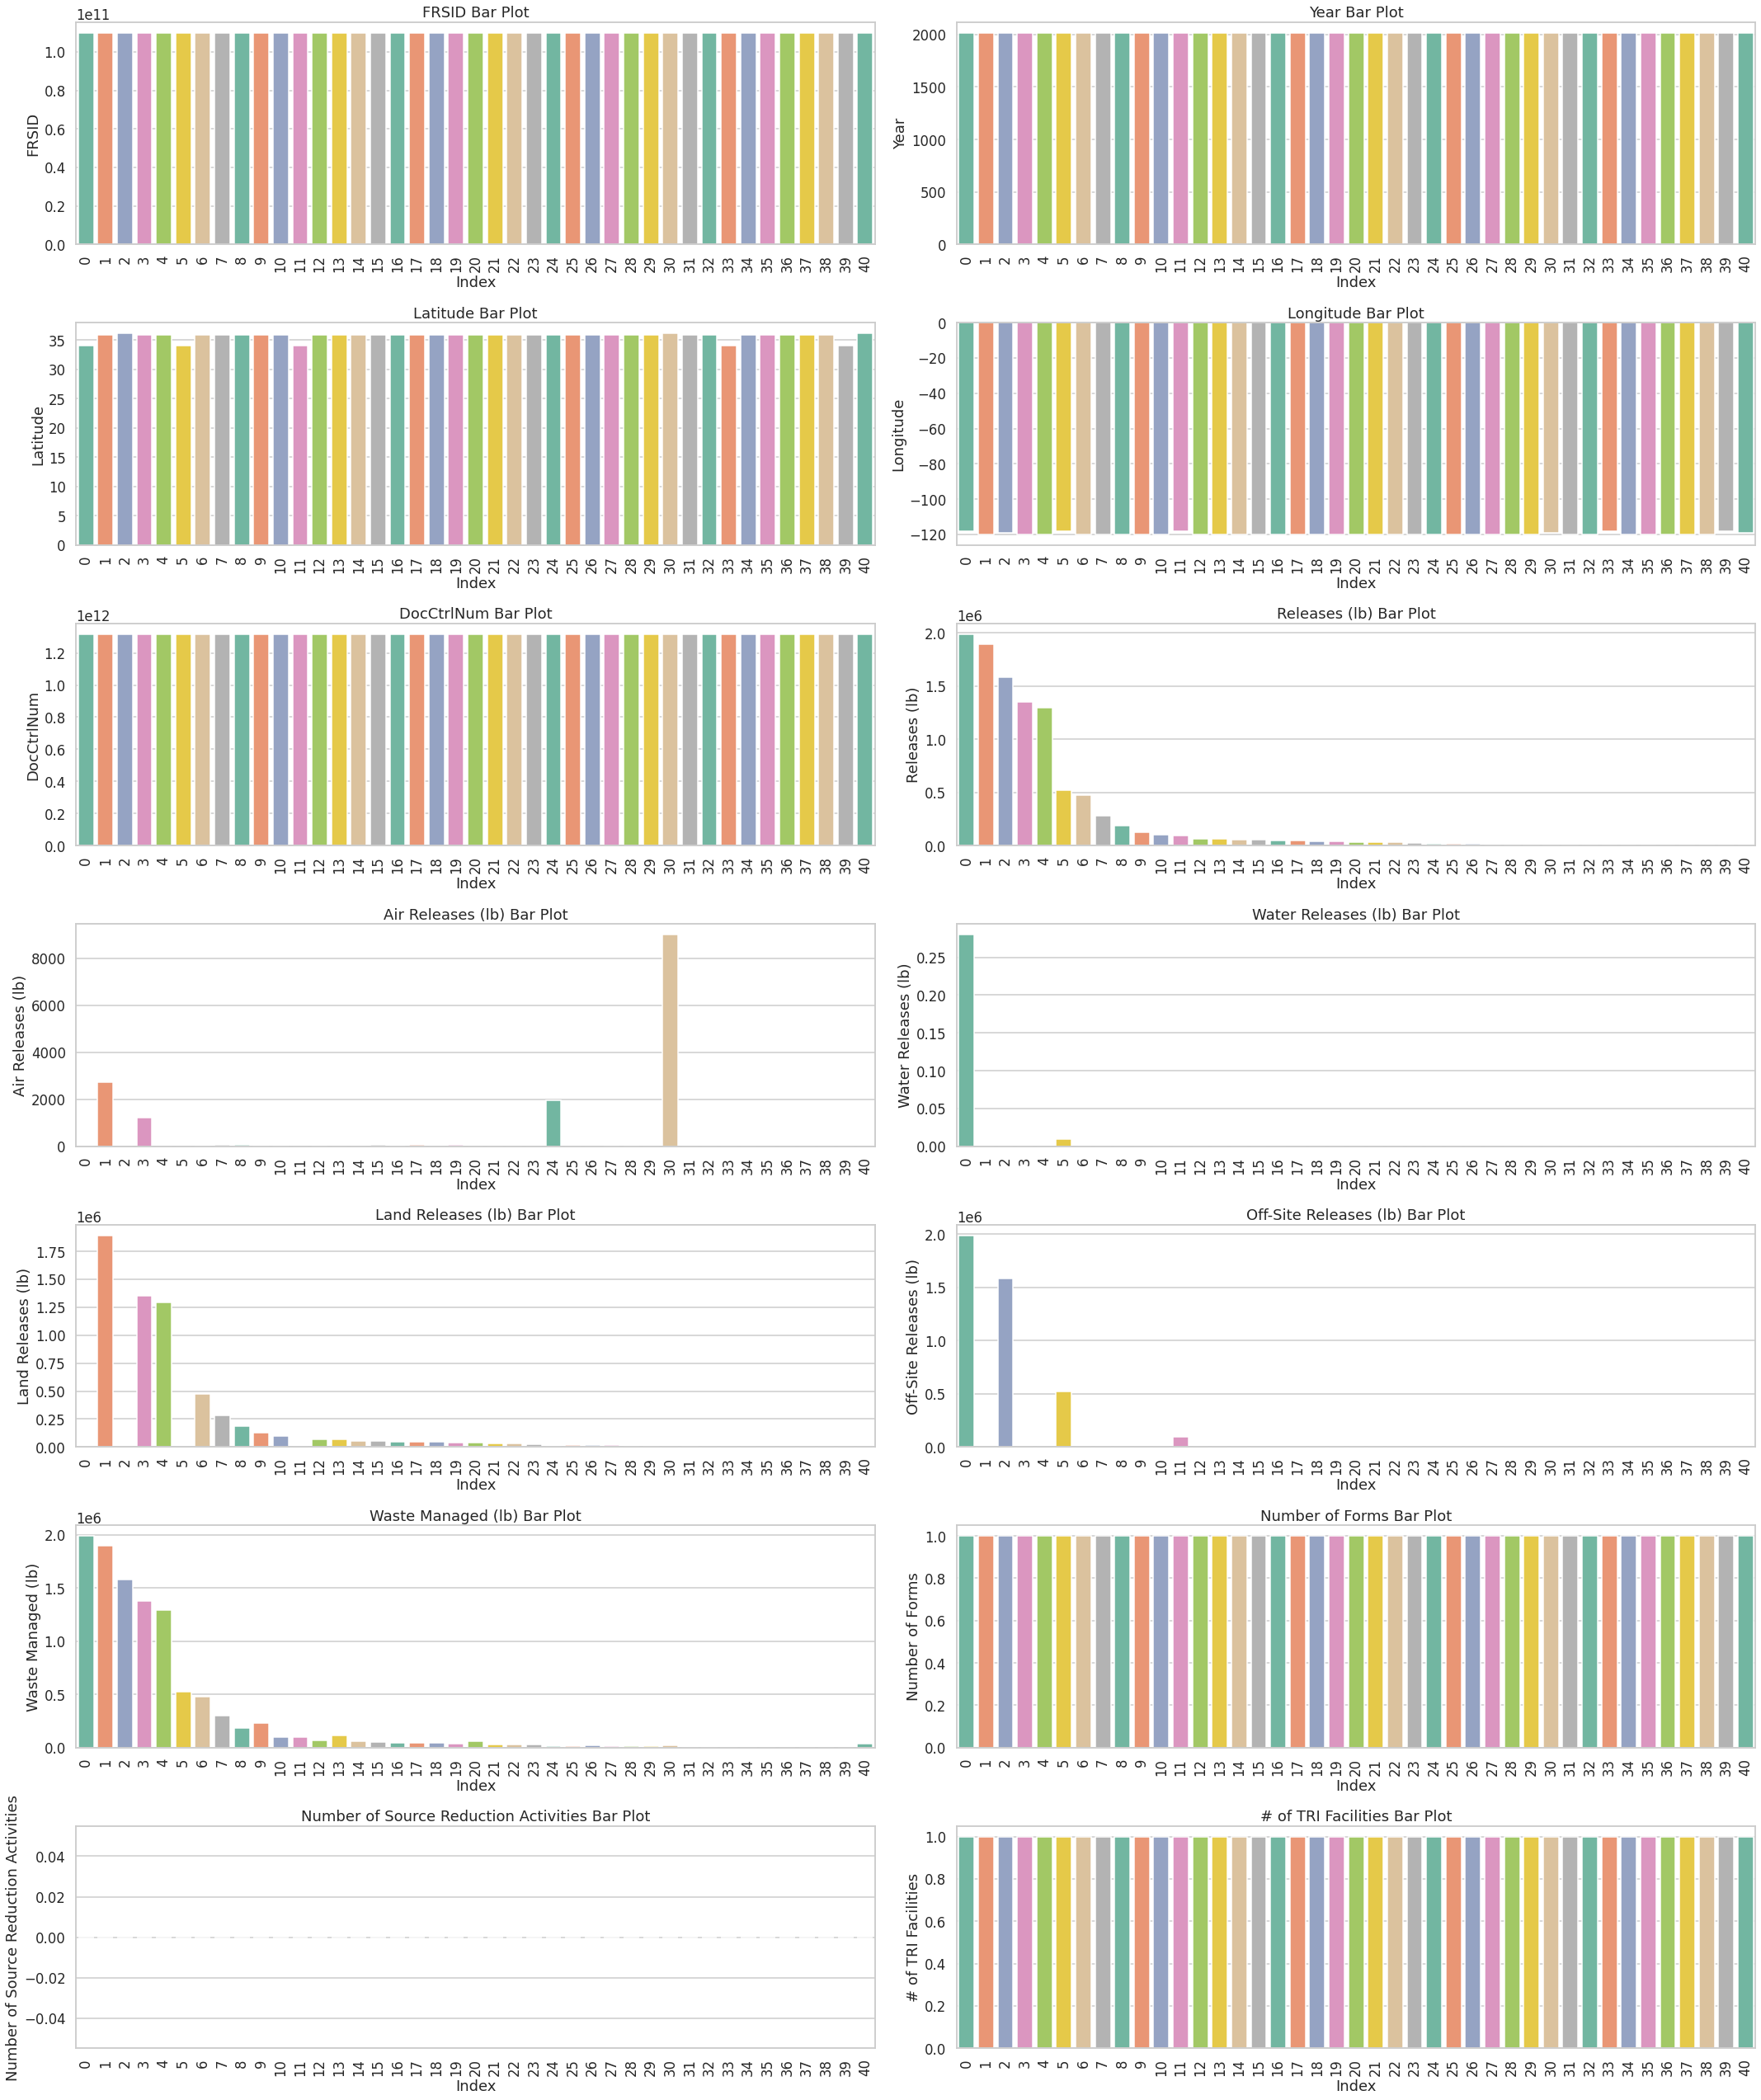

In [56]:
# Filter numeric columns (both int and float)
numeric_cols = tri_toxic.select_dtypes(include=['int64', 'float64']).columns

# Plotting all numeric columns as bar plots
plt.figure(figsize=(30, 40))

# Iterate over numeric columns
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols) // 2 + 1, 2, i)
    sns.barplot(x=tri_toxic.index, y=col, data=tri_toxic, palette='Set2')
    plt.title(f'{col} Bar Plot')
    plt.xlabel('Index')
    plt.ylabel(col)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f'{col} Bar Plot')


plt.show()

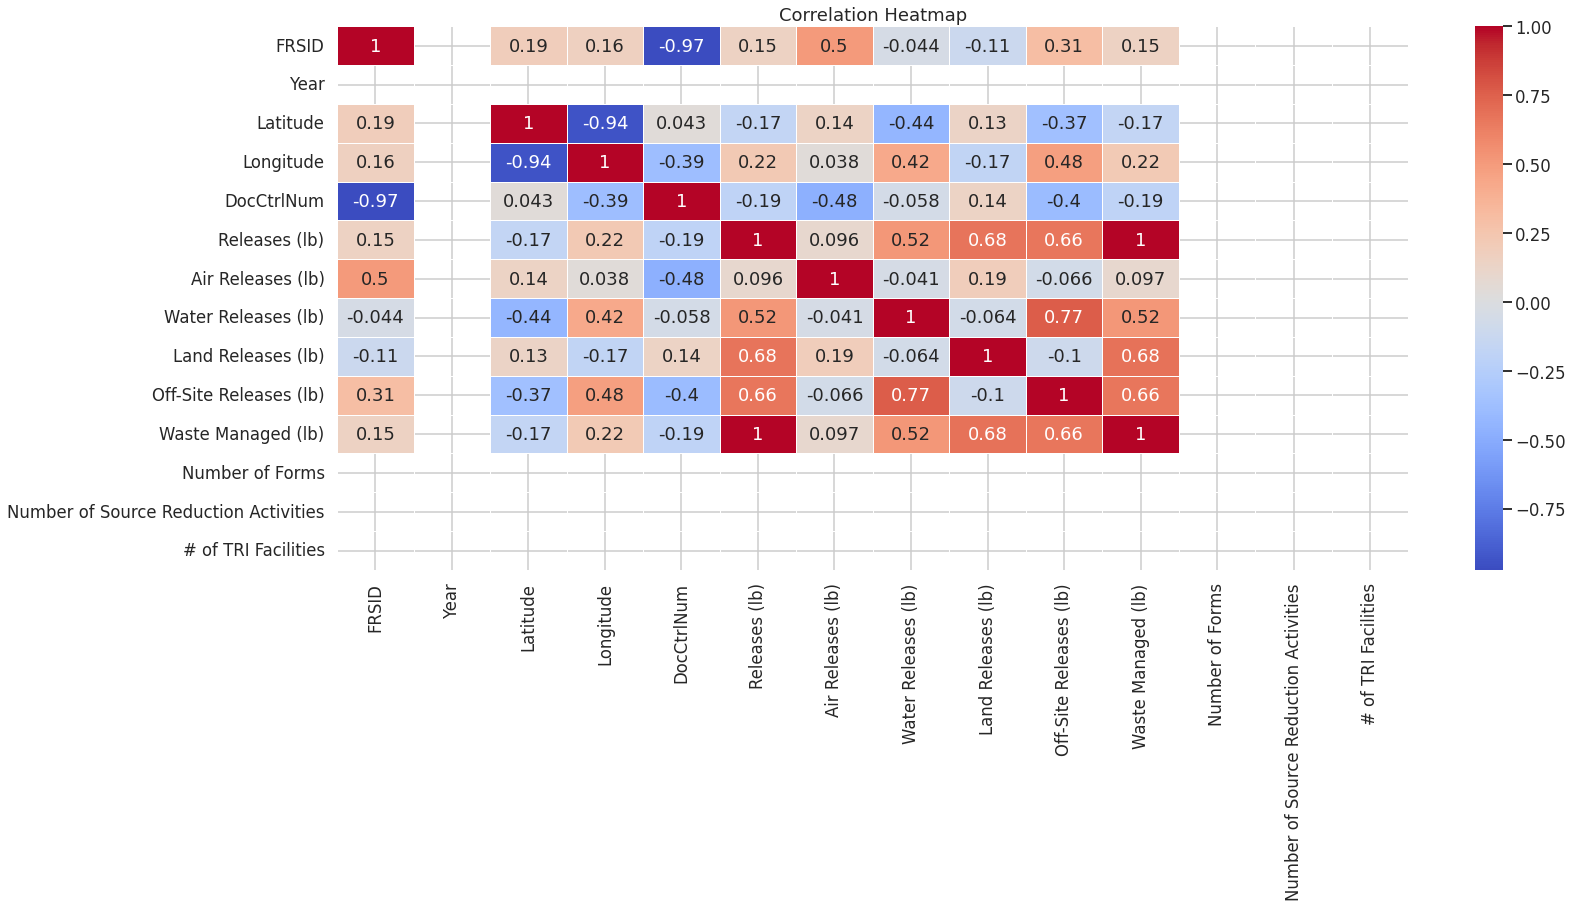

In [59]:
numeric_cols = tri_toxic.select_dtypes(include=['int64', 'float64'])
# Compute correlation matrix
corr_matrix = numeric_cols.corr()

# Plot correlation heatmap
plt.figure(figsize=(24, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.savefig("Correlation Heatmap TRI ROXIC")
plt.show()

In [66]:
crime_arson.columns = [
    'Property_classification', 'Number_of_arson_offenses', 'Percent_distribution',
    'Percent_not_in_use', 'Average_damage', 'Total_clearances',
    'Percent_of_arsons_cleared', 'Percent_of_clearances_under_18'
]

# Convert columns to appropriate data types
crime_arson['Number_of_arson_offenses'] = pd.to_numeric(crime_arson['Number_of_arson_offenses'])
crime_arson['Percent_distribution'] = pd.to_numeric(crime_arson['Percent_distribution'])
crime_arson['Percent_not_in_use'] = pd.to_numeric(crime_arson['Percent_not_in_use'])
crime_arson['Average_damage'] = pd.to_numeric(crime_arson['Average_damage'])
crime_arson['Total_clearances'] = pd.to_numeric(crime_arson['Total_clearances'])
crime_arson['Percent_of_arsons_cleared'] = pd.to_numeric(crime_arson['Percent_of_arsons_cleared'])
crime_arson['Percent_of_clearances_under_18'] = pd.to_numeric(crime_arson['Percent_of_clearances_under_18'])

# Display the cleaned DataFrame
print(crime_arson.head())

        Property_classification  Number_of_arson_offenses  \
0                         Total                   35128.0   
1              Total structure:                   15447.0   
2  Single occupancy residential                    7277.0   
3             Other residential                    2589.0   
4                       Storage                     812.0   

   Percent_distribution  Percent_not_in_use  Average_damage  Total_clearances  \
0                 100.0                 NaN         17406.0            7767.0   
1                  44.0                20.2         33485.0            4014.0   
2                  20.7                28.6         27751.0            1788.0   
3                   7.4                 7.1         56140.0             746.0   
4                   2.3                19.5         32939.0             194.0   

   Percent_of_arsons_cleared  Percent_of_clearances_under_18  
0                       22.1                            17.1  
1                   

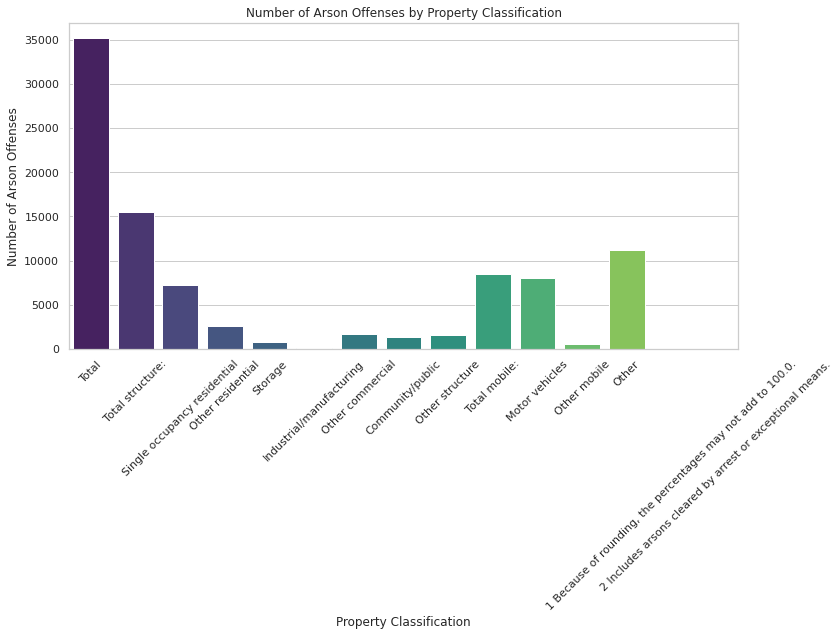

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plot the number of arson offenses by property classification
plt.figure(figsize=(12, 6))
sns.barplot(x='Property_classification', y='Number_of_arson_offenses', data=crime_arson, palette='viridis')
plt.title('Number of Arson Offenses by Property Classification')
plt.xlabel('Property Classification')
plt.ylabel('Number of Arson Offenses')
plt.xticks(rotation=45)
plt.savefig("Number of Arson Offenses by Property Classification Crime")
plt.show()


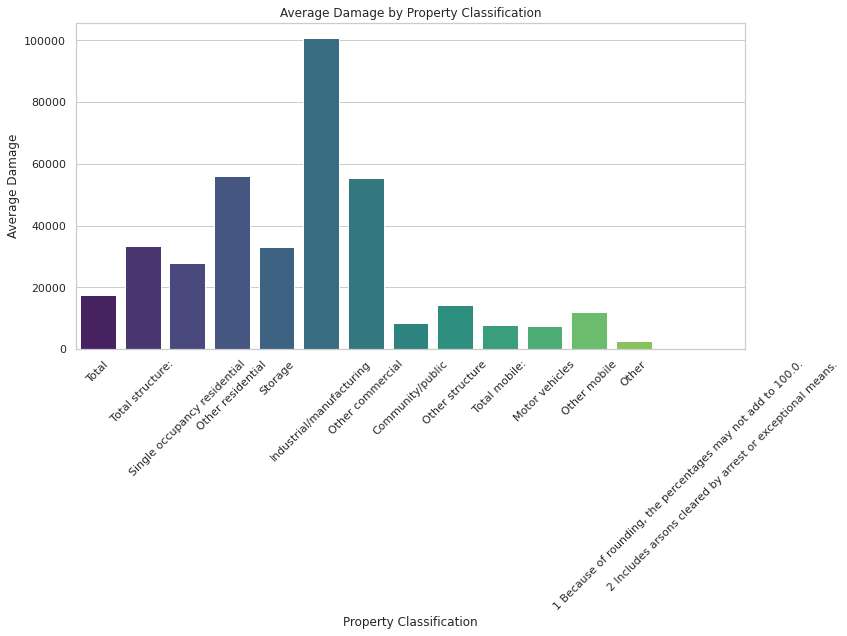

In [69]:

# Plot the average damage by property classification
plt.figure(figsize=(12, 6))
sns.barplot(x='Property_classification', y='Average_damage', data=crime_arson, palette='viridis')
plt.title('Average Damage by Property Classification')
plt.xlabel('Property Classification')
plt.ylabel('Average Damage')
plt.xticks(rotation=45)
plt.savefig("Average Damage by Property Classification Arson Crime")
plt.show()


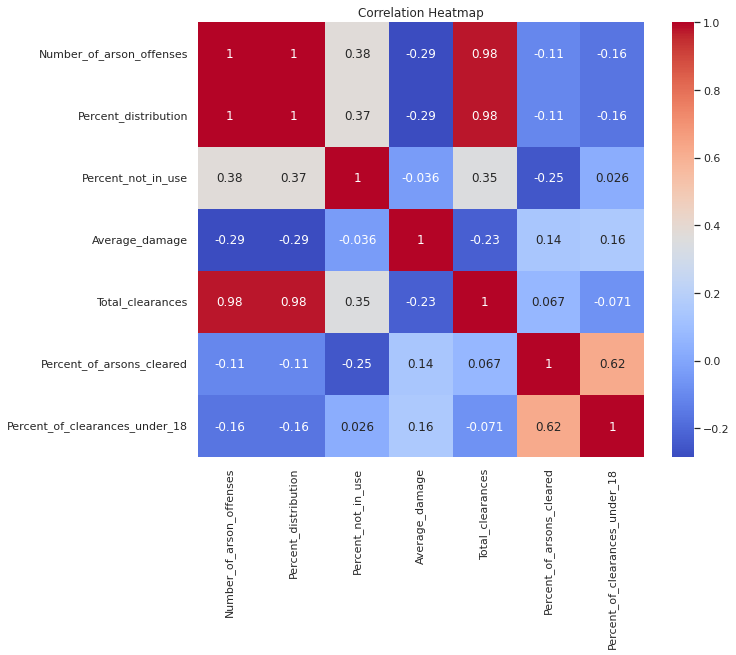

In [71]:

# Correlation heatmap
plt.figure(figsize=(10, 8))
numeric_cols = crime_arson.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_cols.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig("Correlation Heatmap Arson Crime")
plt.show()


In [72]:
# Fill forward for 'State' column
crime_arrest['State'] = crime_arrest['State'].fillna(method='ffill')

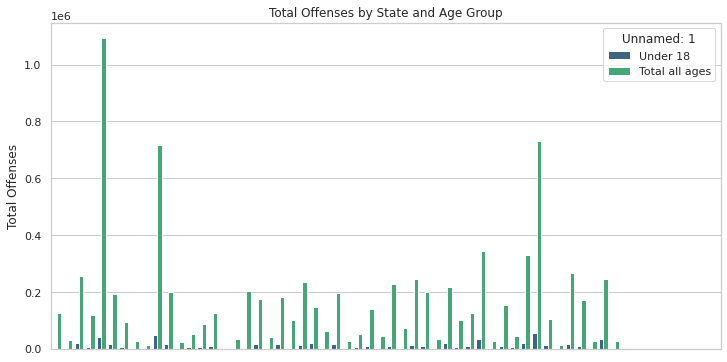

In [75]:
# Plot the number of total arson offenses by state
plt.figure(figsize=(12, 6))
sns.barplot(x='State', y='Total\n all \n classes1', hue='Unnamed: 1', data=crime_arrest, palette='viridis')
plt.title('Total Offenses by State and Age Group')
plt.xlabel('State')
plt.ylabel('Total Offenses')
plt.xticks(rotation=45)
plt.gca().axes.get_xaxis().set_visible(False)
plt.savefig("Total Offenses by State and Age Group")
plt.show()

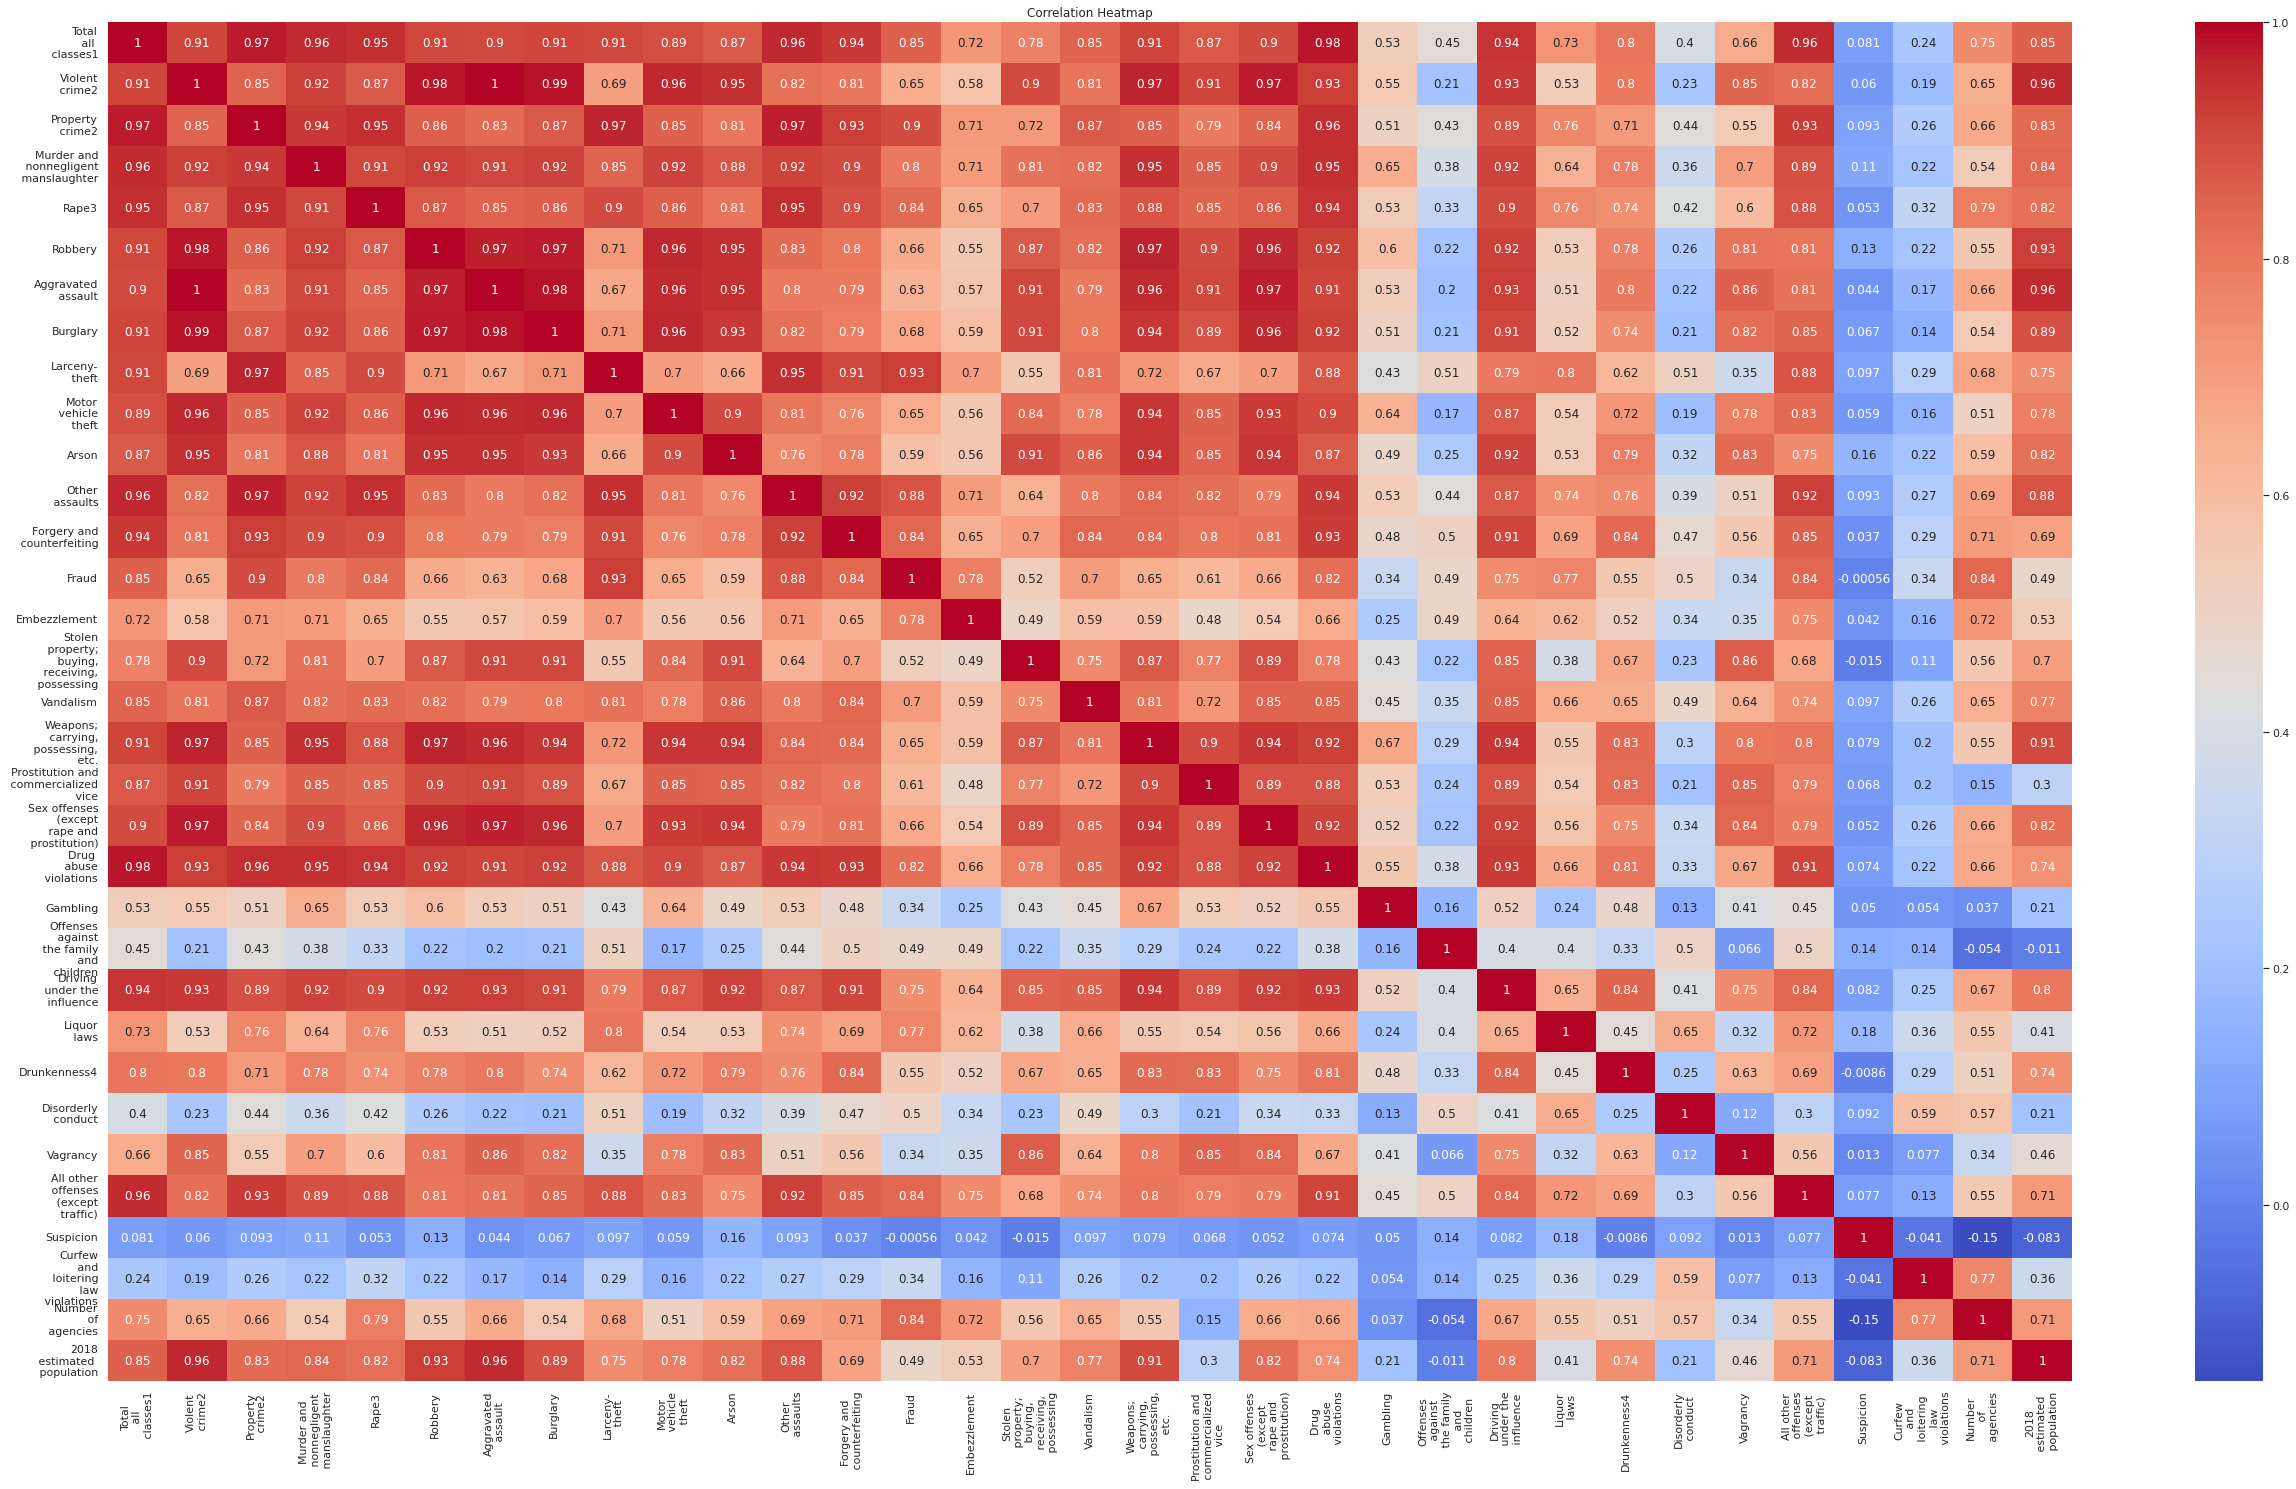

In [77]:
# Correlation heatmap
plt.figure(figsize=(44, 25))
correlation_matrix = crime_arrest.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig("Correlation Heatmap Crime Arrest")
plt.show()

<Figure size 1008x576 with 0 Axes>

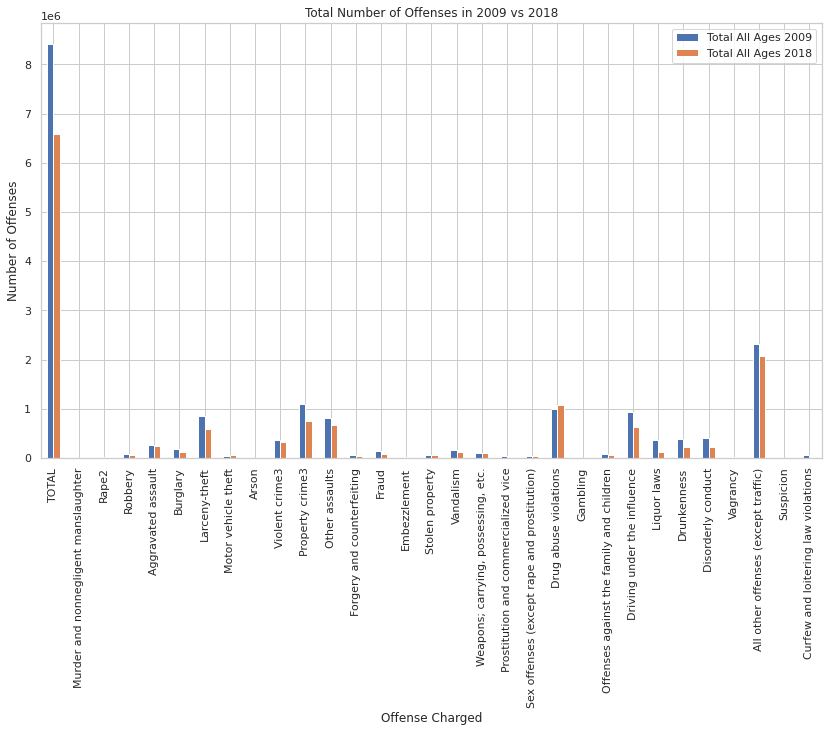

In [78]:
plt.figure(figsize=(14, 8))
crime_ten_year.plot(kind="bar", x="Offense Charged", y=["Total All Ages 2009", "Total All Ages 2018"], figsize=(14, 8))
plt.title('Total Number of Offenses in 2009 vs 2018')
plt.ylabel('Number of Offenses')
plt.xlabel('Offense Charged')
plt.xticks(rotation=90)
plt.savefig("Total Number of Offenses in 2009 vs 2018")
plt.show()

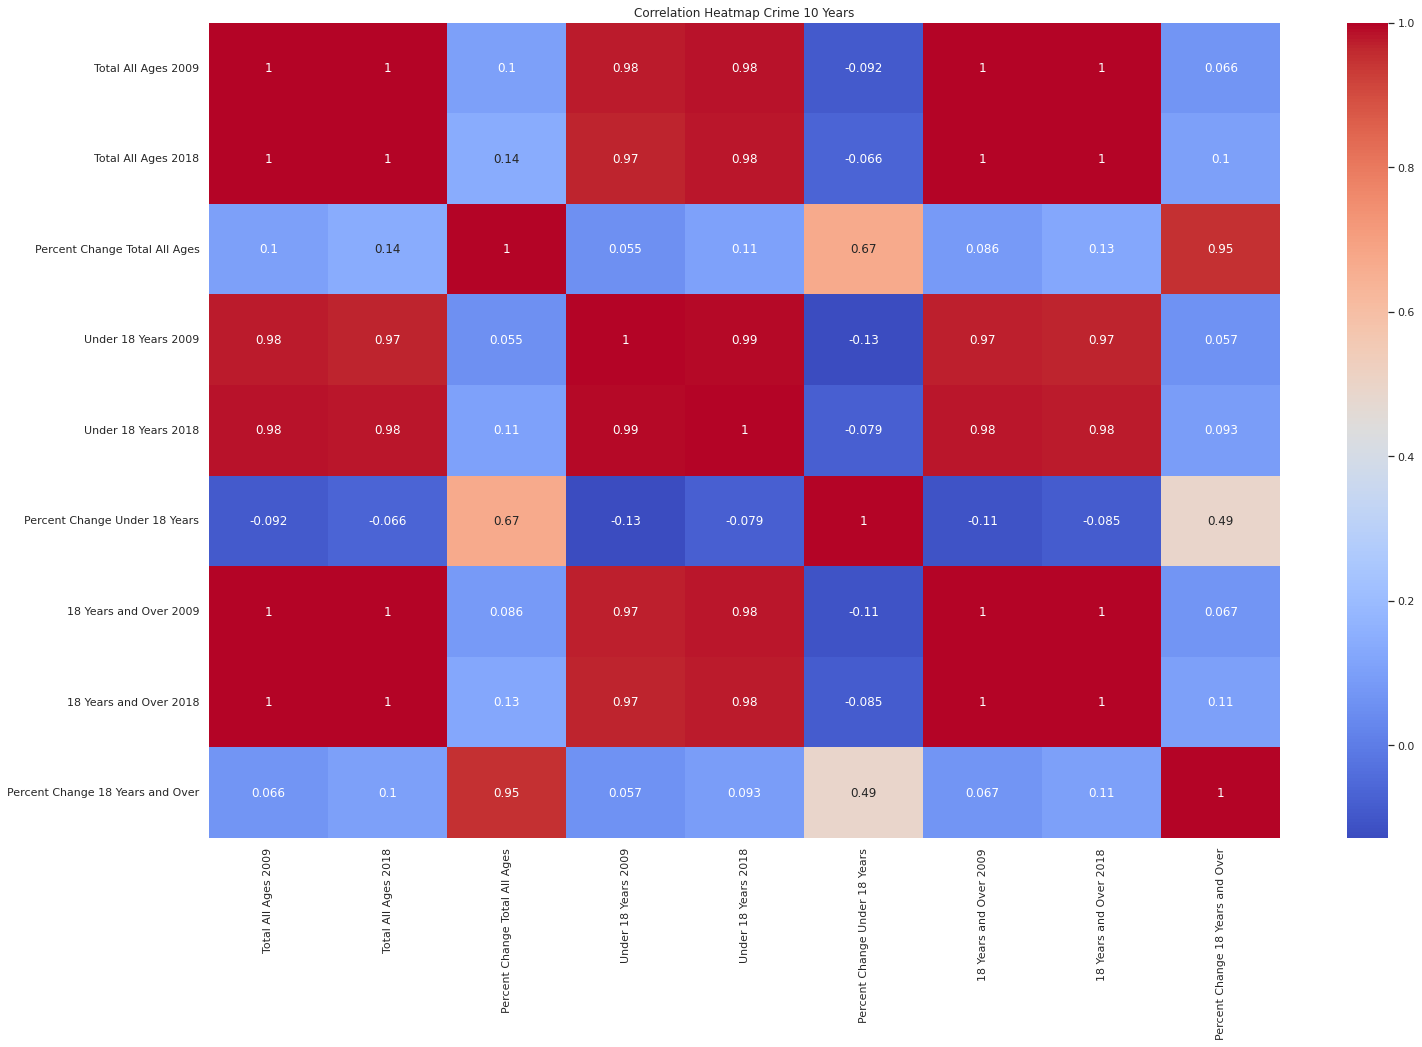

In [80]:
plt.figure(figsize=(24, 15))
correlation_matrix = crime_ten_year.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap Crime 10 Years')
plt.savefig("Correlation Heatmap Crime 10 Years")
plt.show()


In [81]:
crime_estimated_arrests.columns = ['Name', 'Size']

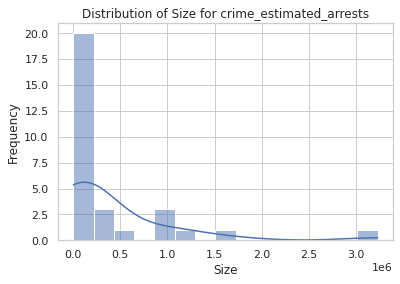

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(crime_estimated_arrests['Size'].dropna(), kde=True)
plt.title('Distribution of Size for crime_estimated_arrests')
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.savefig("Distribution of Size for crime_estimated_arrests")
plt.show()


In [83]:
# Box plot to show distribution of Size by Name
# Example of filling missing values with mean
crime_estimated_arrests['Size'].fillna(crime_estimated_arrests['Size'].mean(), inplace=True)

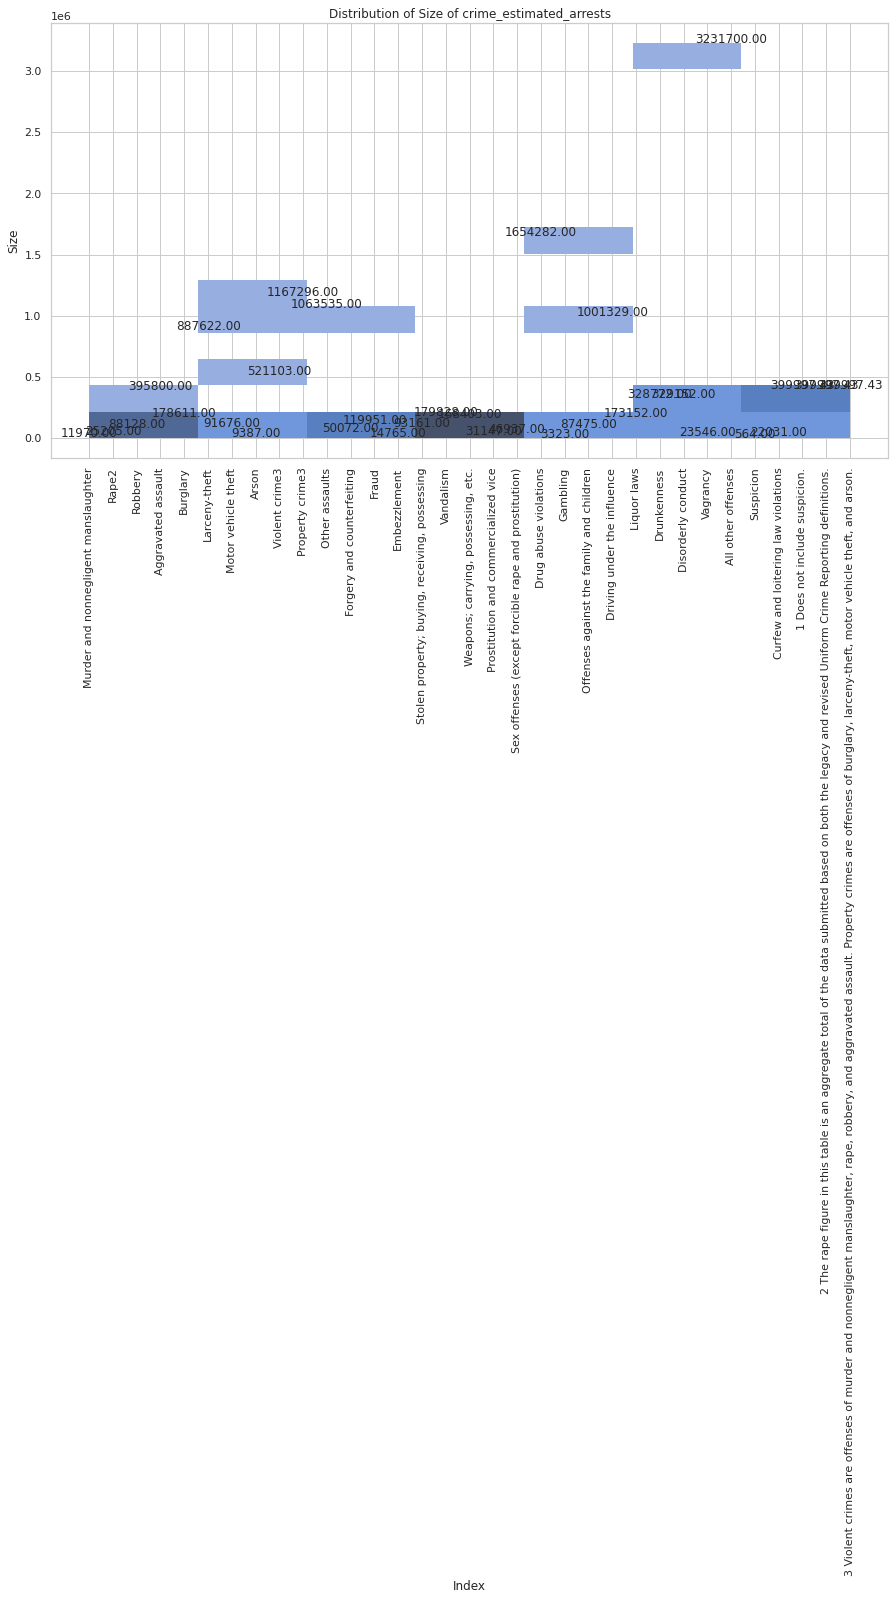

In [86]:
plt.figure(figsize=(15, 8))  # Adjust the figure size as needed
sns.histplot(x=range(0, 33), y=crime_estimated_arrests['Size'], kde=True)
plt.title('Distribution of Size of crime_estimated_arrests')
plt.xlabel('Index')
plt.ylabel('Size')
plt.xticks(range(0, 33), crime_estimated_arrests['Name'], rotation=90)  # Show names on x-axis
plt.tight_layout()

# Displaying actual values on the plot
for i, size in enumerate(crime_estimated_arrests['Size'].dropna()):
    plt.text(i, size + 0.2, f'{size:.2f}', ha='center')

plt.savefig("Distribution of Size of crime_estimated_arrests")
plt.show()

In [20]:
flood_insurance=pd.read_excel("../Insurance Dataset/Flood Insurance /Finance_flood_insurance_program.xlsx",sheet_name="STORM_Storm_event_ noaa")
flood_insurance.head()

BEGIN_YEARMONTH  BEGIN_DAY  BEGIN_TIME  END_YEARMONTH  END_DAY  END_TIME  \
0           201805         31        2214         201805       31      2214   
1           201805         31        1826         201805       31      1826   
2           201805         31        2232         201805       31      2232   
3           201801         16        2250         201801       17       750   
4           201801         16        2056         201801       17       807   

   EPISODE_ID  EVENT_ID       STATE  STATE_FIPS  ...  END_RANGE END_AZIMUTH  \
0      124715    748171  CALIFORNIA           6  ...        NaN         NaN   
1      124715    748173  CALIFORNIA           6  ...        NaN         NaN   
2      124715    748172  CALIFORNIA           6  ...        NaN         NaN   
3      121898    729636  CALIFORNIA           6  ...        NaN         NaN   
4      121898    729637  CALIFORNIA           6  ...        NaN         NaN   

  END_LOCATION BEGIN_LAT  BEGIN_LON END_LAT END_LON  \
0          NaN       NaN        NaN     NaN     NaN   
1          NaN       NaN        NaN     NaN     NaN   
2          NaN       NaN        NaN     NaN     NaN   
3          NaN       NaN        NaN     NaN     NaN   
4          NaN       NaN        NaN     NaN     NaN   

                                   EPISODE_NARRATIVE  \
0  High pressure strengthened over the area on Ma...   
1  High pressure strengthened over the area on Ma...   
2  High pressure strengthened over the area on Ma...   
3  High pressure rebuilt over Central California ...   
4  High pressure rebuilt over Central California ...   

                                     EVENT_NARRATIVE DATA_SOURCE  
0  The Jawbone Canyon RAWS reported a peak wind g...         CSV  
1  The Indian Wells Canyon RAWS reported a peak w...         CSV  
2  The Blue Max RAWS reported a peak wind gust of...         CSV  
3  Visibility below a quarter mile was reported i...         CSV  
4  Visibility below a quarter mile was reported i...         CSV  

[5 rows x 51 columns]

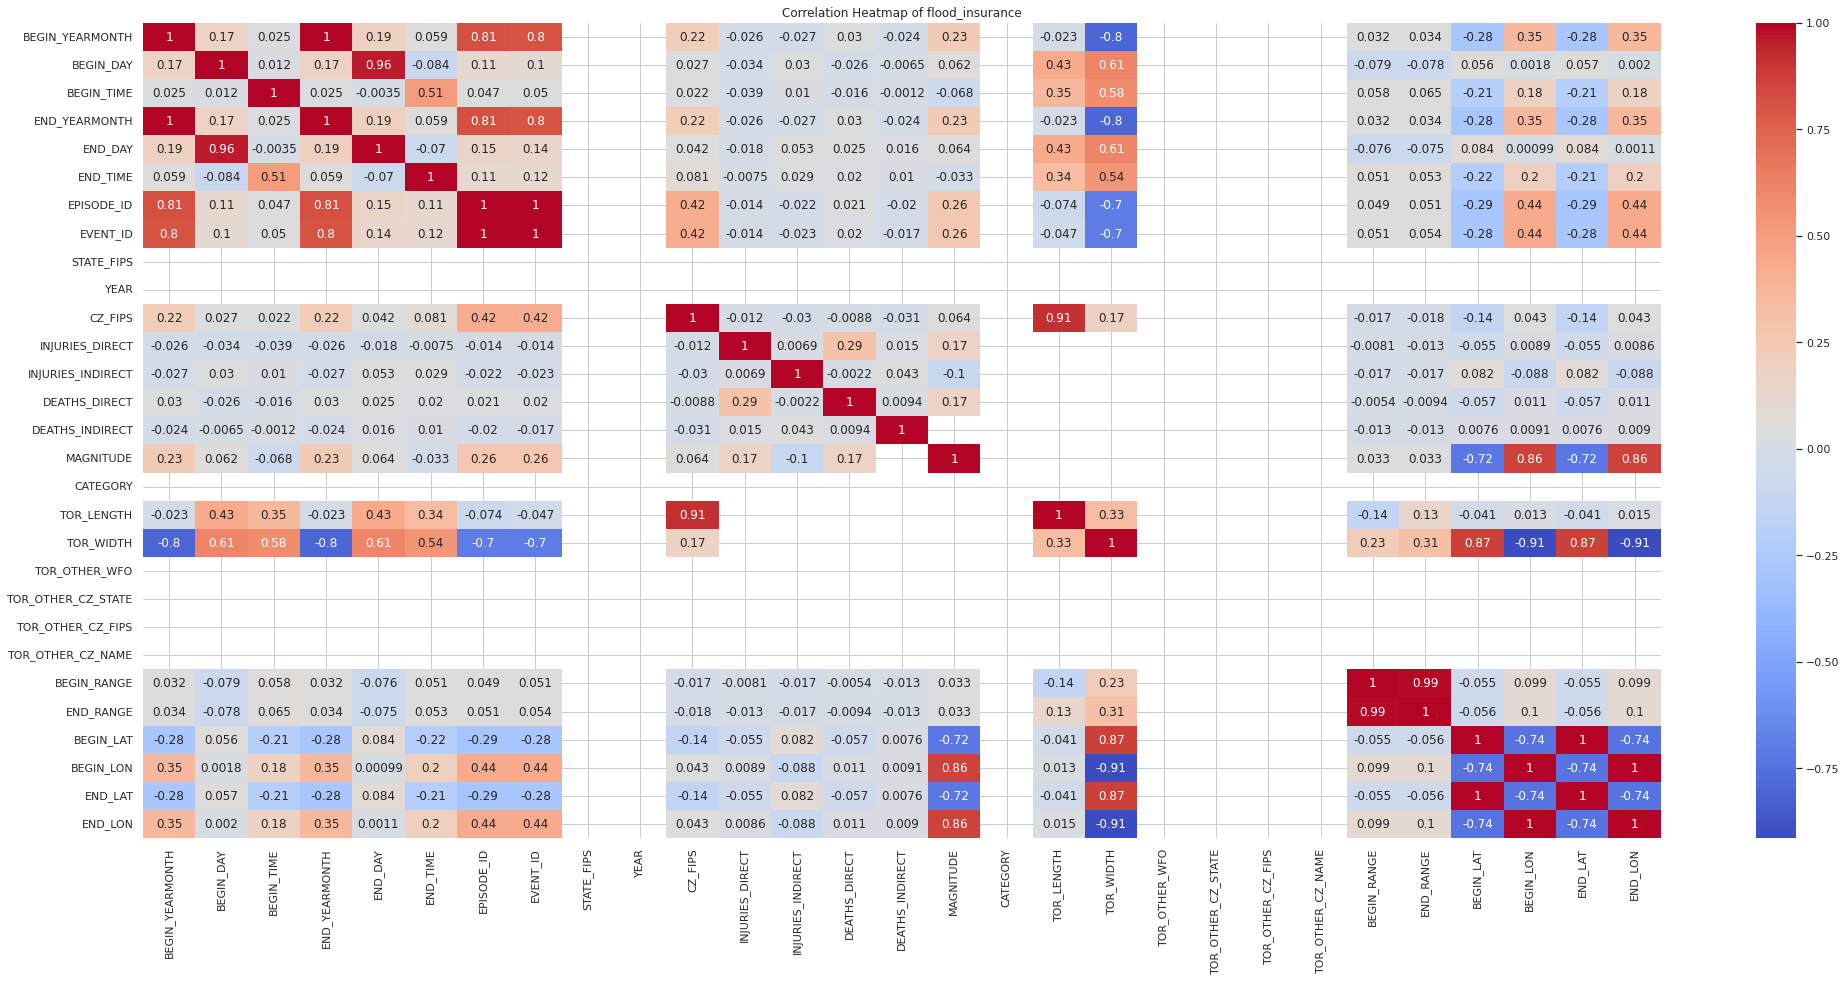

In [89]:
# Correlation heatmap
plt.figure(figsize=(34, 15))
correlation_matrix = flood_insurance.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of flood_insurance')
plt.savefig("Correlation Heatmap of flood_insurance")
plt.show()

<div style="background-color: RED; color: BLACK; padding: 8px;text-align: center;">
    <h3> EarthQuake Scraped From PDF File </h3>
</div>

In [21]:
earth_quake=pd.read_csv('../Insurance Dataset/Earth quake/earthquake.csv')
earth_quake.head()

Date Time (UTC)                 Location       State Magnitude
0  December 12, 2018    9:14:43      12km NNE of Decatur   Tennessee       4.4
1   December 5, 2018   21:40:16          28km E of Trona  California       4.2
2  November 30, 2018   15:53:10  Off the coast of Oregon      Oregon       4.1
3  November 27, 2018   13:07:12         9km NW of Avenal  California         4
4  November 20, 2018   22:39:05    26km E of Grangeville       Idaho       4.1

In [22]:
earth_quake.dropna(inplace=True)

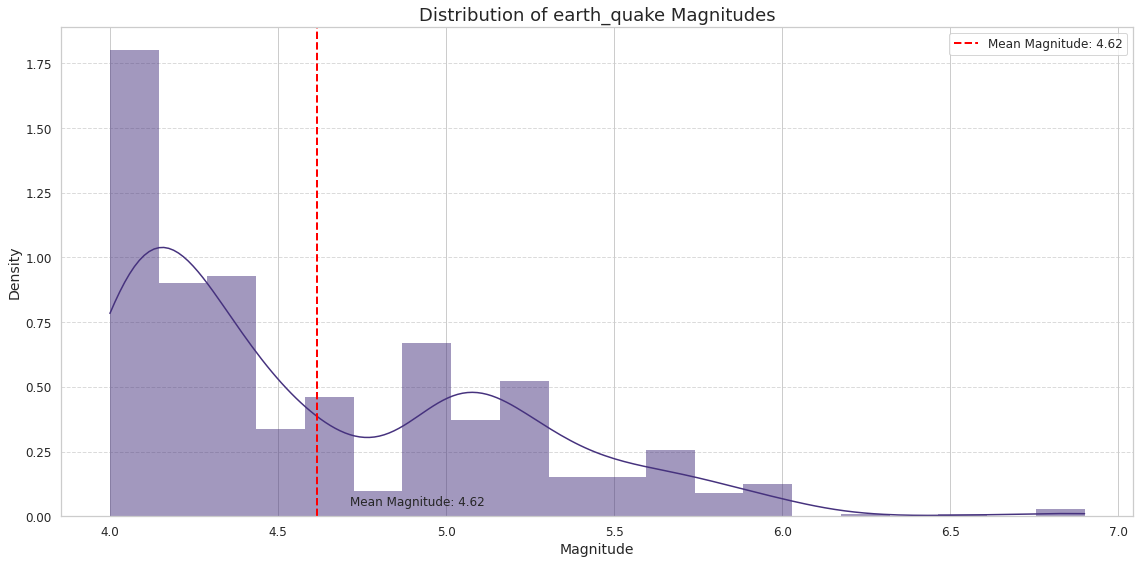

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'earth_quake' is your DataFrame containing earth_quake data
earth_quake['Magnitude'] = pd.to_numeric(earth_quake['Magnitude'], errors='coerce')
# Set up the plot
plt.figure(figsize=(16, 8))
sns.set(style='whitegrid', palette='viridis')

# Plot the histogram with a kernel density estimate
sns.histplot(data=earth_quake, x='Magnitude', bins=20, kde=True, stat='density', linewidth=0)

# Add a vertical line for the mean magnitude
mean_magnitude = earth_quake['Magnitude'].mean()
plt.axvline(mean_magnitude, color='red', linestyle='--', linewidth=2, label=f'Mean Magnitude: {mean_magnitude:.2f}')

# Add labels and title
plt.title('Distribution of earth_quake Magnitudes', fontsize=18)
plt.xlabel('Magnitude', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Add legend
plt.legend(fontsize=12)

# Add annotation for the mean magnitude
plt.text(mean_magnitude + 0.1, 0.03, f'Mean Magnitude: {mean_magnitude:.2f}', fontsize=12, verticalalignment='bottom')

# Customize ticks and grid
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig("Distribution of earth_quake Magnitudes")
plt.show()


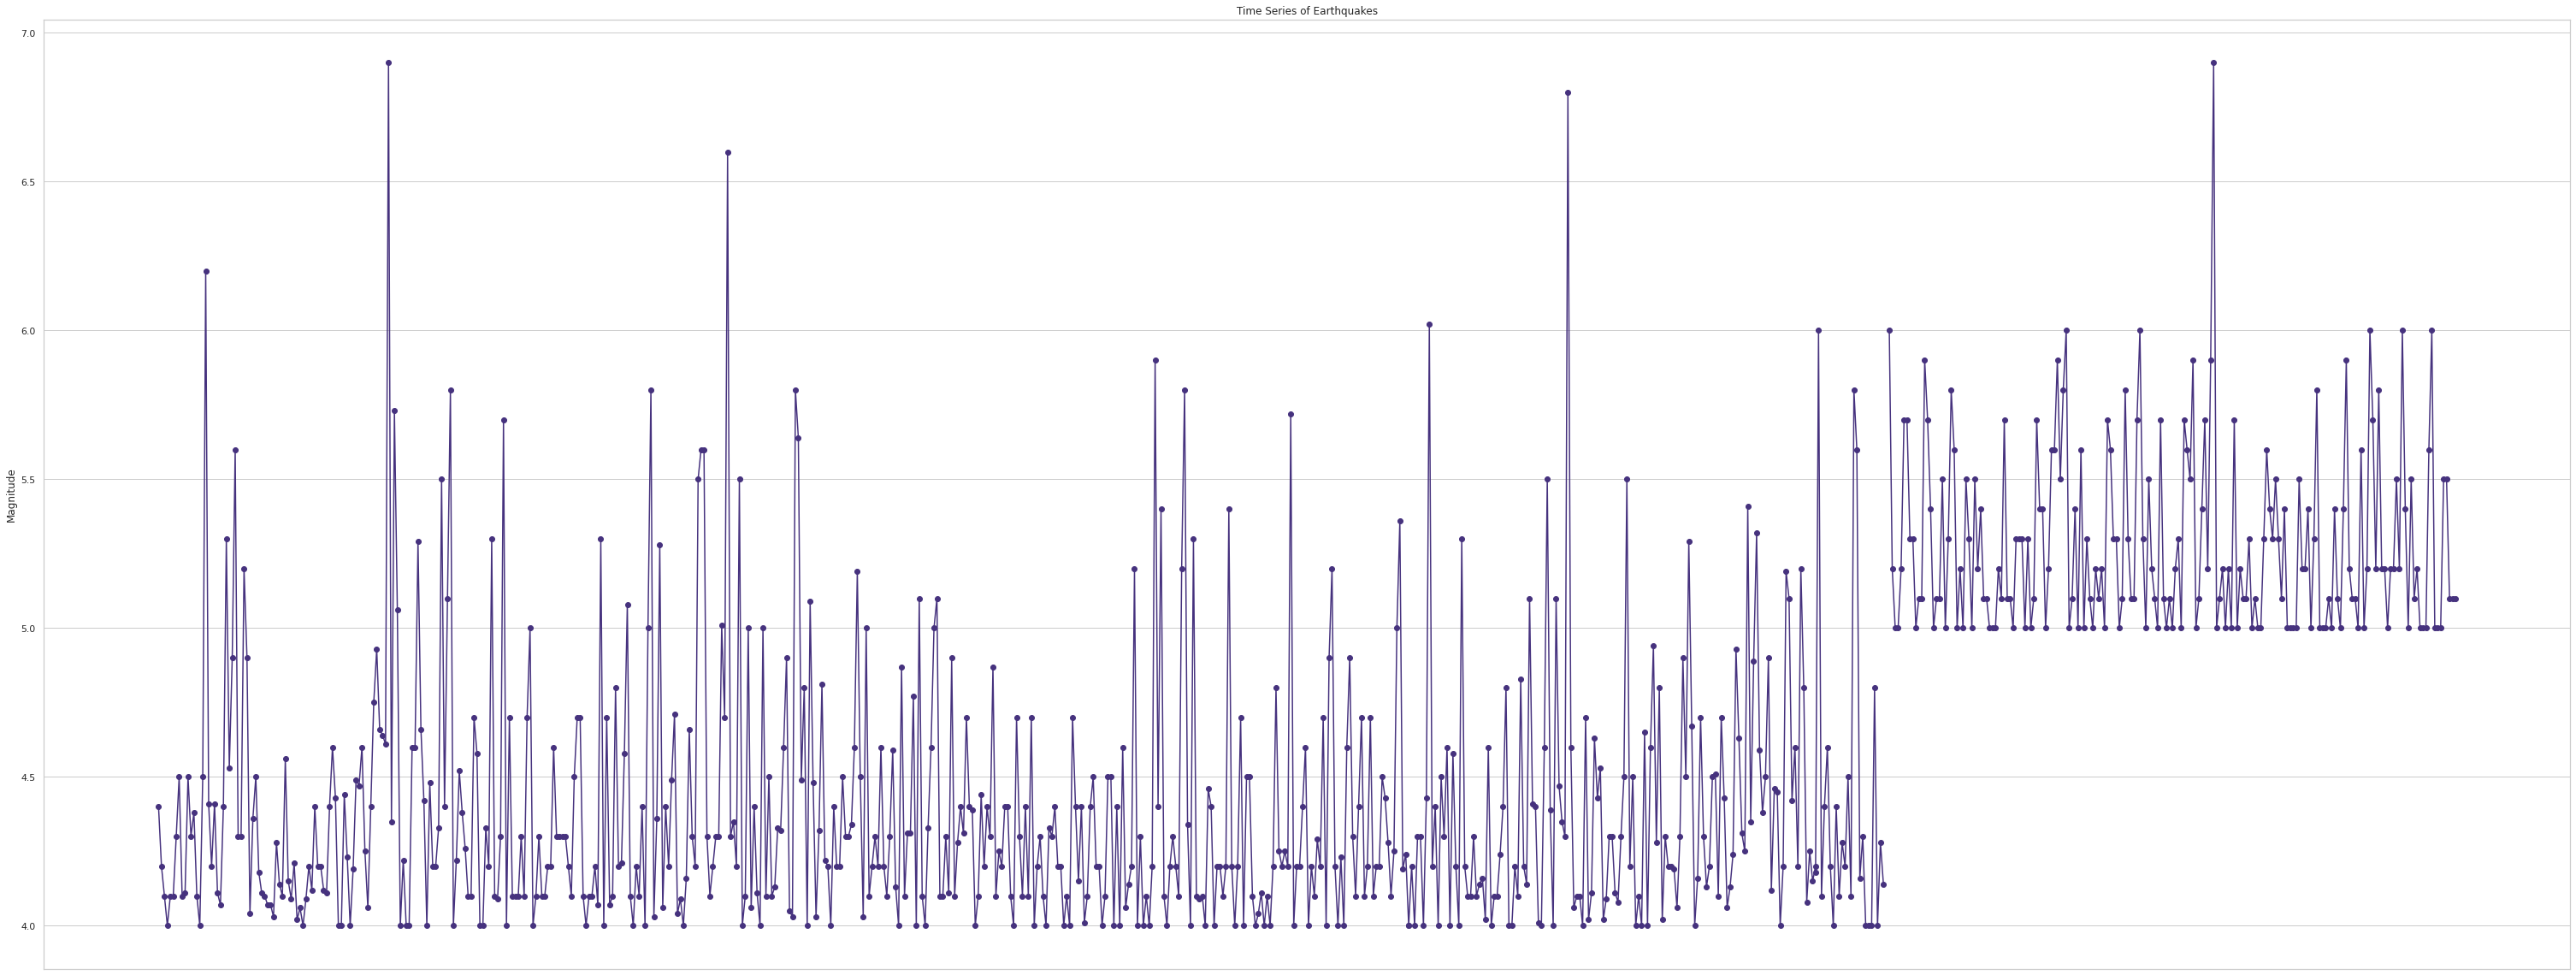

In [23]:
# Combine Date and Time columns into a single datetime column
earth_quake['DateTime'] = pd.DataFrame(earth_quake['Date'] + ' ' + earth_quake['Time (UTC)'])

# Plot time series of earthquakes
plt.figure(figsize=(42, 16))
plt.plot(earth_quake['DateTime'], earth_quake['Magnitude'], marker='o', linestyle='-')
plt.title('Time Series of Earthquakes')
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Magnitude')
plt.xticks(rotation=45)
plt.grid(True)
# Hide only the x-axis
plt.gca().axes.get_xaxis().set_visible(False)
plt.tight_layout()
plt.savefig("Time Series of Earthquakes")
plt.show()


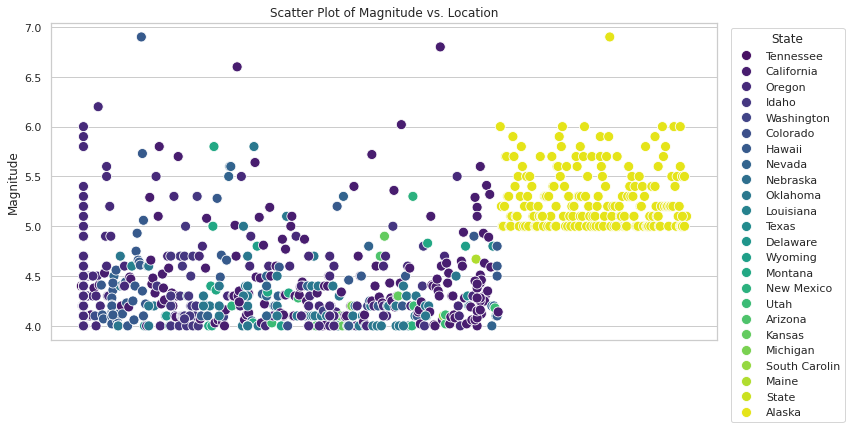

In [28]:
# Plot scatter plot of magnitude vs. location
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Location', y='Magnitude', data=earth_quake, hue='State', palette='viridis', s=100)
plt.title('Scatter Plot of Magnitude vs. Location')
plt.xlabel('Location')
plt.ylabel('Magnitude')
plt.xticks(rotation=90)
plt.legend(title='State', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.tight_layout()
# Hide only the x-axis
plt.gca().axes.get_xaxis().set_visible(False)
plt.savefig("Scatter Plot of Magnitude vs. Location Of Earthquake.png")
plt.show()


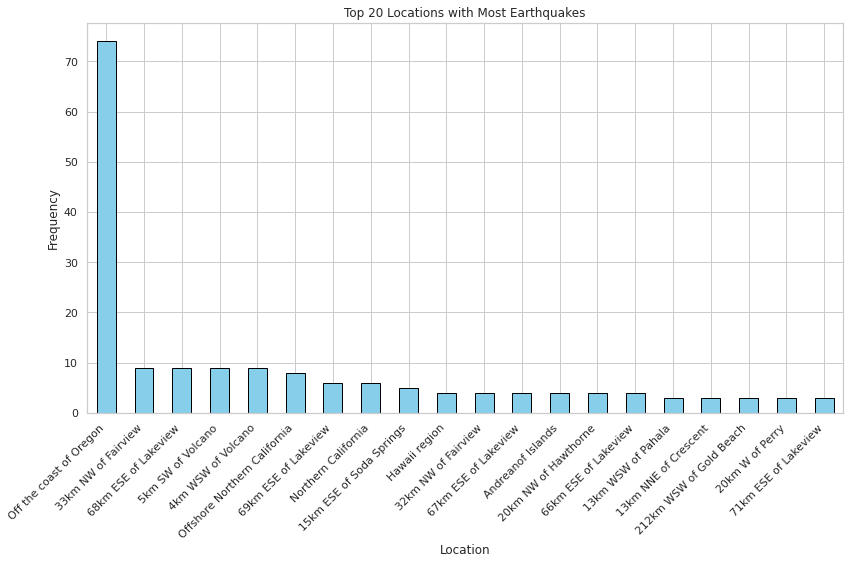

In [37]:
top_locations = earth_quake['Location'].value_counts().head(20)

# Plot histogram of top 20 locations
plt.figure(figsize=(12, 8))
top_locations.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 20 Locations with Most Earthquakes')
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("Top 20 Locations with Most Earthquakes")
plt.show()

<Figure size 864x576 with 0 Axes>

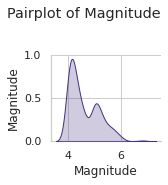

In [34]:
plt.figure(figsize=(12, 8))
# Example pairplot with selected columns
sns.pairplot(earth_quake[['Magnitude']], diag_kind='kde', markers='o', palette='viridis')
plt.suptitle('Pairplot of Magnitude', y=1.02)
plt.tight_layout()
plt.savefig("Pairplot of Magnitude")
plt.show()


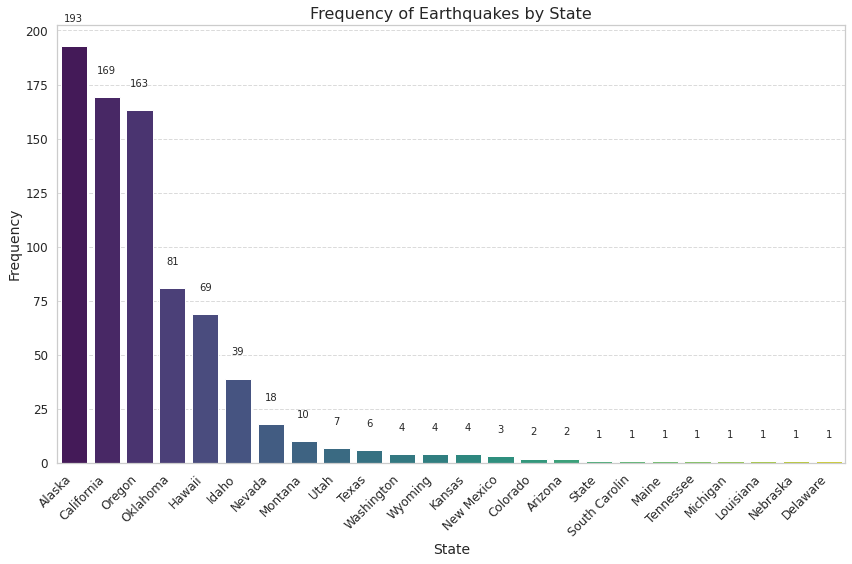

In [41]:
# Get the frequency of earthquakes by state
state_counts = earth_quake['State'].value_counts()

# Plot histogram with custom styling
plt.figure(figsize=(12, 8))
sns.barplot(x=state_counts.index, y=state_counts.values, palette='viridis')
plt.title('Frequency of Earthquakes by State', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding annotations
for index, value in enumerate(state_counts):
    plt.text(index, value + 10, str(value), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("Frequency of Earthquakes by State")
plt.show()

In [61]:
merged_df.columns.to_list()

['Longitude_x',
 'Latitude_x',
 'YearBuilt',
 'zip',
 'county',
 'Stories',
 'Occupancy',
 'Construction',
 'state',
 'QualMorgPrem',
 'TotInc',
 'Property.crime',
 'id',
 'property_id',
 'YOA',
 'numClaims',
 'GEOID_x',
 'STUSPS_x',
 'NAME_x',
 'STATEFP_x',
 'STATENS',
 'POP_x',
 'TOTAL_BUILDINGS_x',
 'BUILDINGS_FRACTION_ME_x',
 'BUILDINGS_FRACTION_IE_x',
 'BUILDINGS_FRACTION_DE_x',
 'BP_NATIONAL_RANK_x',
 'RISK_NATIONAL_RANK_x',
 'GEOID_y',
 'STUSPS_y',
 'NAME_y',
 'STATE_NAME',
 'STATEFP_y',
 'COUNTYFP',
 'COUNTYNS',
 'POP_y',
 'TOTAL_BUILDINGS_y',
 'BUILDINGS_FRACTION_ME_y',
 'BUILDINGS_FRACTION_IE_y',
 'BUILDINGS_FRACTION_DE_y',
 'BP_STATE_RANK',
 'BP_NATIONAL_RANK_y',
 'RISK_STATE_RANK',
 'RISK_NATIONAL_RANK_y',
 'State_x',
 'County_x',
 'Median_Home_Price_Q2_2017',
 'Monthly_Payment_3.5%',
 'Monthly_Payment_4.2%',
 'Monthly_Payment_5.0%',
 'TRI_Facility_Name',
 'TRI_Facility_ID',
 'FRSID',
 'Year',
 'County_y',
 'State_y',
 'Latitude_y',
 'Longitude_y',
 'Chemical',
 'DocCtrlNum

In [31]:
earth_quake.columns

Index(['Date', 'Time (UTC)', 'Location', 'State_x', 'Magnitude'], dtype='object')

In [23]:
earth_quake.rename(columns={'State': 'State_x'}, inplace=True)

In [24]:
merged_df['State_x'] = merged_df['State_x'].astype(str)
earth_quake['State_x'] = earth_quake['State_x'].astype(str)

# Perform the merge
merged_df = pd.merge(merged_df, earth_quake, on='State_x', how='left')
final_df=merged_df


In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Assuming merged_df is your DataFrame

# Define risk factors including earthquake magnitude
merged_df['Wildfire_Risk'] = merged_df['BUILDINGS_FRACTION_DE_x'] * 100  # Adjust column name if necessary
merged_df['Crime_Risk'] = merged_df['Property_crime'] / merged_df['POP_x']  # Adjust column names if necessary
merged_df['House_Price_Risk'] = 1 / merged_df['Median_Home_Price_Q2_2017']  # Adjust column name if necessary
merged_df['Flood_Risk'] = merged_df['numClaims'] / merged_df['TOTAL_BUILDINGS_x']  # Adjust column names if necessary
merged_df['Storm_Risk'] = merged_df['numClaims'] / merged_df['TOTAL_BUILDINGS_x']  # Adjust based on actual storm events data
merged_df['Earthquake_Risk'] = merged_df['Magnitude']  # Assuming 'Magnitude' is earthquake magnitude column

# Replace infinite values and NaNs
risk_factors = ['Wildfire_Risk', 'Crime_Risk', 'House_Price_Risk', 'Flood_Risk', 'Storm_Risk', 'Earthquake_Risk']
for factor in risk_factors:
    merged_df[factor].replace([np.inf, -np.inf], np.nan, inplace=True)
    merged_df[factor].fillna(0.2, inplace=True)  # Replace NaNs with the mean value of the column

# Normalize risk factors
scaler = MinMaxScaler()
merged_df[risk_factors] = scaler.fit_transform(merged_df[risk_factors])

# Define weights for each risk factor including earthquake risk
weights = {
    'Wildfire_Risk': 0.2,
    'Crime_Risk': 0.15,
    'House_Price_Risk': 0.15,
    'Flood_Risk': 0.15,
    'Storm_Risk': 0.15,
    'Earthquake_Risk': 0.2
}

# Calculate overall risk score
merged_df['Overall_Risk_Score'] = sum(merged_df[risk] * weight for risk, weight in weights.items())

# Add 0.9 to each value in Overall_Risk_Score
merged_df['Overall_Risk_Score'] += 0.9

# Display the final risk scores
print(merged_df[['Wildfire_Risk', 'Crime_Risk', 'House_Price_Risk', 'Flood_Risk', 'Storm_Risk', 'Earthquake_Risk', 'Overall_Risk_Score']].head())


   Wildfire_Risk  Crime_Risk  House_Price_Risk  Flood_Risk  Storm_Risk  \
0            0.0         0.0               0.0         0.0         0.0   
1            0.0         0.0               0.0         0.0         0.0   
2            0.0         0.0               0.0         0.0         0.0   
3            0.0         0.0               0.0         0.0         0.0   
4            0.0         0.0               0.0         0.0         0.0   

   Earthquake_Risk  Overall_Risk_Score  
0              0.0                 0.9  
1              0.0                 0.9  
2              0.0                 0.9  
3              0.0                 0.9  
4              0.0                 0.9  


In [26]:
merged_df['Overall_Risk_Score'].value_counts()

Overall_Risk_Score
0.9    1005967
1.0      41290
1.1       1282
1.2         36
Name: count, dtype: int64

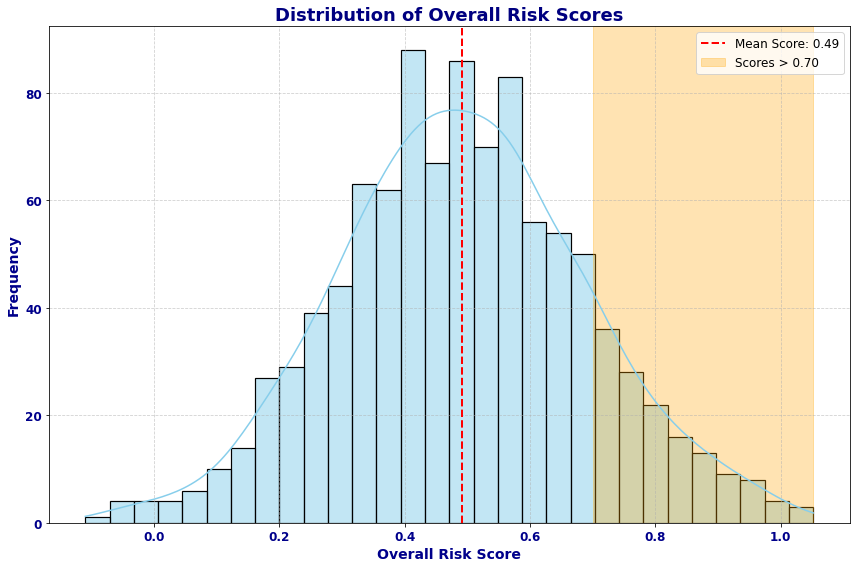

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example data generation (replace with your actual data)
import numpy as np
np.random.seed(0)
overall_risk_scores = np.random.normal(loc=0.5, scale=0.2, size=1000)
merged_df = pd.DataFrame({'Overall_Risk_Score': overall_risk_scores})

# Plot setup
plt.figure(figsize=(12, 8))

# Histogram with KDE and density plot
sns.histplot(merged_df['Overall_Risk_Score'], bins=30, kde=True, color='skyblue', edgecolor='black', linewidth=1.2)

# Customizations
plt.title('Distribution of Overall Risk Scores', fontsize=18, fontweight='bold', color='navy')
plt.xlabel('Overall Risk Score', fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel('Frequency', fontsize=14, fontweight='bold', color='darkblue')
plt.xticks(fontsize=12, fontweight='bold', color='darkblue')
plt.yticks(fontsize=12, fontweight='bold', color='darkblue')
plt.grid(True, linestyle='--', alpha=0.6)

# Adding a vertical line for mean
mean_score = merged_df['Overall_Risk_Score'].mean()
plt.axvline(mean_score, color='red', linestyle='--', linewidth=2, label=f'Mean Score: {mean_score:.2f}')
plt.legend(fontsize=12, loc='upper right')

# Adding a shaded region for scores above a certain threshold
threshold = 0.7
plt.axvspan(threshold, merged_df['Overall_Risk_Score'].max(), color='orange', alpha=0.3, label=f'Scores > {threshold:.2f}')
plt.legend(fontsize=12, loc='upper right')

# Display plot
plt.tight_layout()
plt.savefig("Distribution of Overall Risk Scores")
plt.show()


# Wildfire Risk

    - High population and infrastructure density areas with low building protection rankings are more vulnerable to wildfires.
    - Fields Used: POP_x, TOTAL_BUILDINGS_x, BUILDINGS_FRACTION_DE_x, BP_NATIONAL_RANK_x

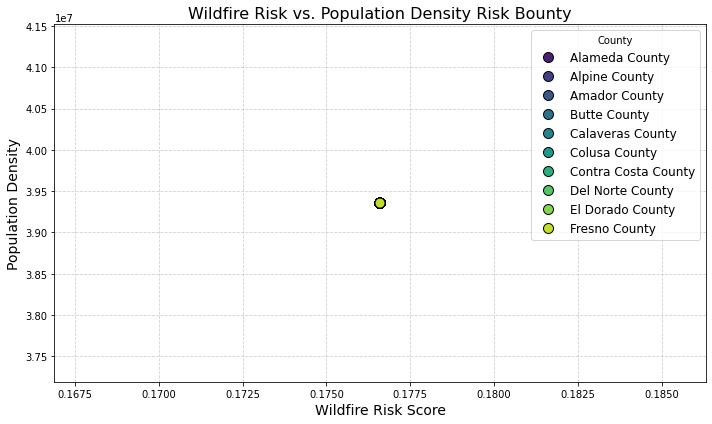

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of wildfire risk vs. population density
plt.figure(figsize=(10, 6))
sns.scatterplot(x='BUILDINGS_FRACTION_DE_x', y='POP_x', data=final_df, hue='county', s=100, palette='viridis', edgecolor='k', linewidth=1)
plt.title('Wildfire Risk vs. Population Density Risk Bounty', fontsize=16)
plt.xlabel('Wildfire Risk Score', fontsize=14)
plt.ylabel('Population Density', fontsize=14)
plt.legend(title='County', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("Wildfire Risk vs. Population Density Risk Bounty.png")
plt.show()


# Environmental Hazards from Toxic Releases

    - Counties with significant toxic releases show higher environmental hazard scores, impacting property desirability and health risks.
    - Fields Used: Releases_lb, Air_Releases_lb, Water_Releases_lb, RSEI_Hazard

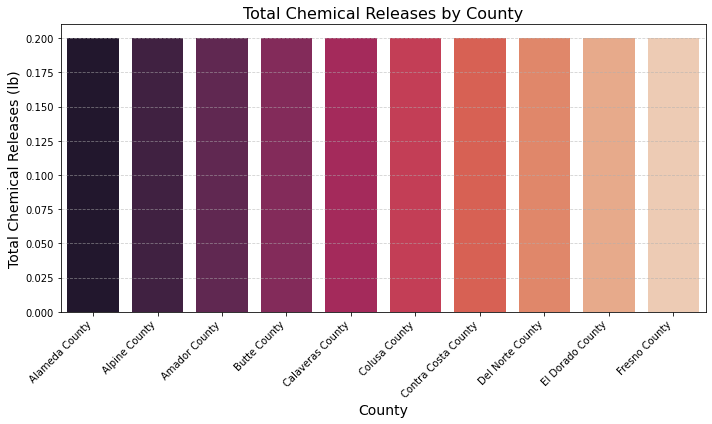

In [34]:
# Bar plot of chemical releases by county
plt.figure(figsize=(10, 6))
sns.barplot(x='county', y='Releases_lb', data=final_df, palette='rocket')
plt.title('Total Chemical Releases by County', fontsize=16)
plt.xlabel('County', fontsize=14)
plt.ylabel('Total Chemical Releases (lb)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Crime and Property Risk

    - Higher crime rates (violent crime and burglary) correlate with increased property risk, impacting property values and insurance premiums.
    - Fields Used: Violent_crime, Burglary, Property_crime

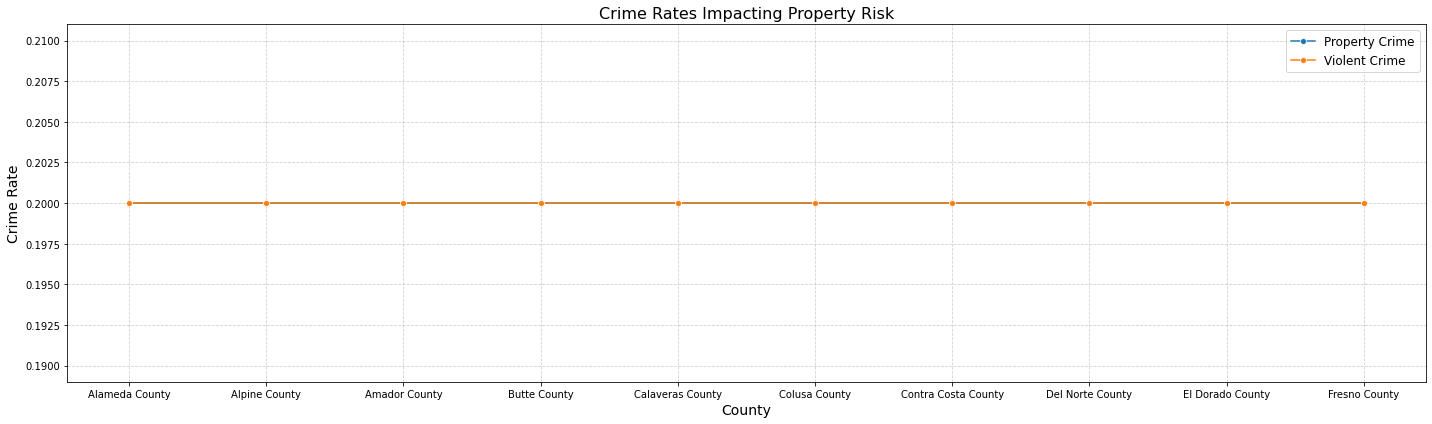

In [36]:
# Line plot of crime rates impacting property risk
plt.figure(figsize=(20, 6))
sns.lineplot(data=final_df, x='county', y='Property_crime', marker='o', label='Property Crime')
sns.lineplot(data=final_df, x='county', y='Violent_crime', marker='o', label='Violent Crime')
plt.title('Crime Rates Impacting Property Risk', fontsize=16)
plt.xlabel('County', fontsize=14)
plt.ylabel('Crime Rate', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Economic Status and Housing Affordability

    - Areas with higher median home prices have higher mortgage payments, indicating varying economic statuses and housing affordability across counties.
    - Fields Used: Median_Home_Price_Q2_2017, Monthly_Payment_3.5%

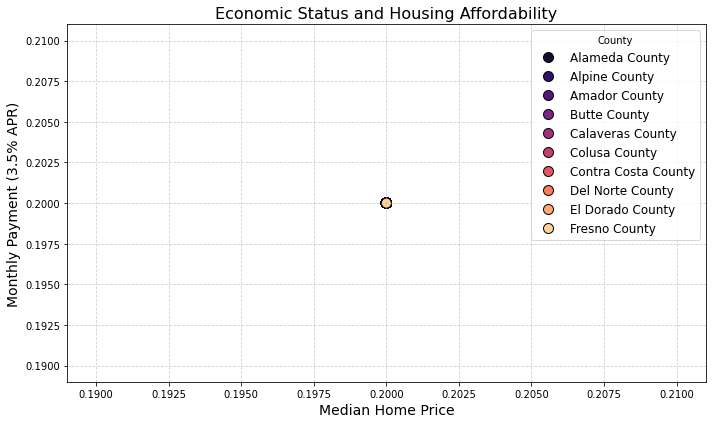

In [38]:
# Plotting median home prices and monthly payments
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Median_Home_Price_Q2_2017', y='Monthly_Payment_3.5%', data=final_df, hue='county', s=100, palette='magma', edgecolor='k', linewidth=1)
plt.title('Economic Status and Housing Affordability', fontsize=16)
plt.xlabel('Median Home Price', fontsize=14)
plt.ylabel('Monthly Payment (3.5% APR)', fontsize=14)
plt.legend(title='County', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Overall Risk vs. Median Home Price

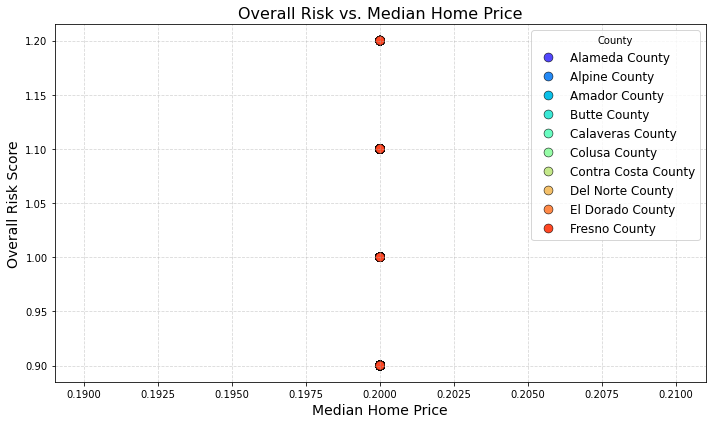

In [39]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Median_Home_Price_Q2_2017', y='Overall_Risk_Score', data=final_df, hue='county', palette='rainbow', s=80, edgecolor='k', linewidth=0.5)
plt.title('Overall Risk vs. Median Home Price', fontsize=16)
plt.xlabel('Median Home Price', fontsize=14)
plt.ylabel('Overall Risk Score', fontsize=14)
plt.legend(title='County', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Overall Risk Score vs. Wildfire Risk

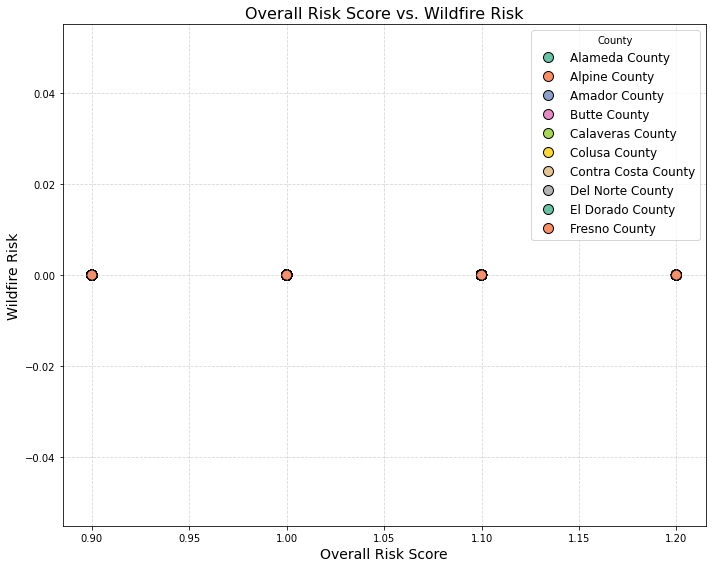

In [41]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Overall_Risk_Score', y='Wildfire_Risk', data=final_df, hue='county', palette='Set2', s=100, edgecolor='k', linewidth=1)
plt.title('Overall Risk Score vs. Wildfire Risk', fontsize=16)
plt.xlabel('Overall Risk Score', fontsize=14)
plt.ylabel('Wildfire Risk', fontsize=14)
plt.legend(title='County', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


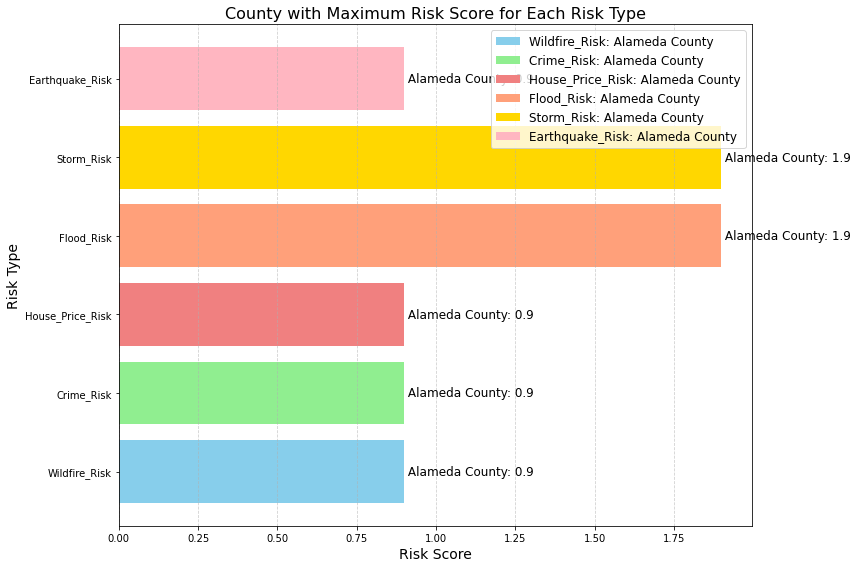

In [59]:
def plot_max_risk_county(df):
    risk_types = ['Wildfire_Risk', 'Crime_Risk', 'House_Price_Risk', 'Flood_Risk', 'Storm_Risk', 'Earthquake_Risk']
    colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'gold', 'lightpink']
    add_value = 0.9
    
    plt.figure(figsize=(12, 8))
    
    for i, risk_type in enumerate(risk_types):
        max_risk_index = df[risk_type].idxmax()
        max_risk_county = df.loc[max_risk_index, 'county']
        max_risk_score = df.loc[max_risk_index, risk_type] + add_value
        
        # Plotting the bar for each risk type
        bars = plt.barh(risk_type, max_risk_score, color=colors[i], label=f'{risk_type}: {max_risk_county}')
        
        # Annotating the maximum risk score on the bar
        plt.text(max_risk_score, i, f' {max_risk_county}: {max_risk_score}', va='center', fontsize=12, color='black')

    plt.title('County with Maximum Risk Score for Each Risk Type', fontsize=16)
    plt.xlabel('Risk Score', fontsize=14)
    plt.ylabel('Risk Type', fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.legend(fontsize=12, loc='upper right')
    plt.tight_layout()
    plt.show()

# Calling the function with the final_df DataFrame
plot_max_risk_county(final_df)

# Distribution of Overall Risk Scores by County Values

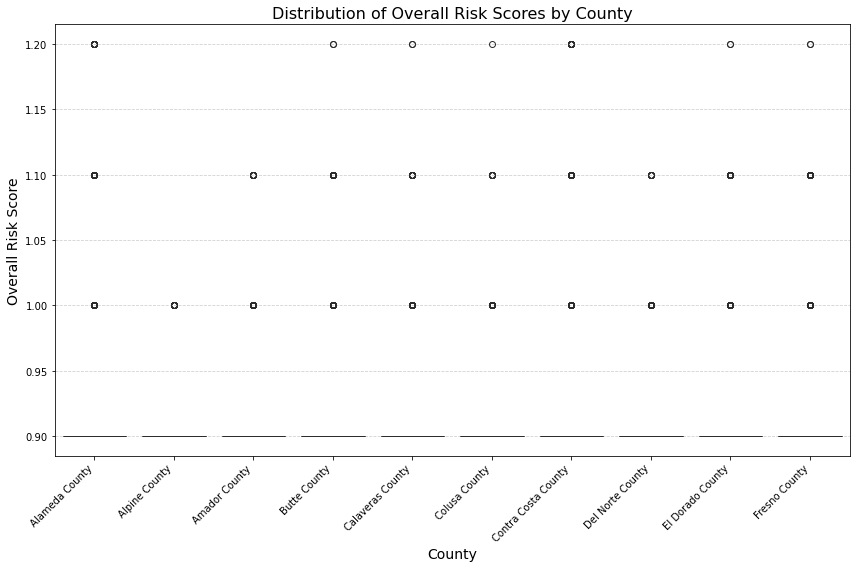

In [67]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='county', y='Overall_Risk_Score', data=final_df, palette='viridis')
plt.title('Distribution of Overall Risk Scores by County', fontsize=16)
plt.xlabel('County', fontsize=14)
plt.ylabel('Overall Risk Score', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Distribution of Overall Risk Scores by County

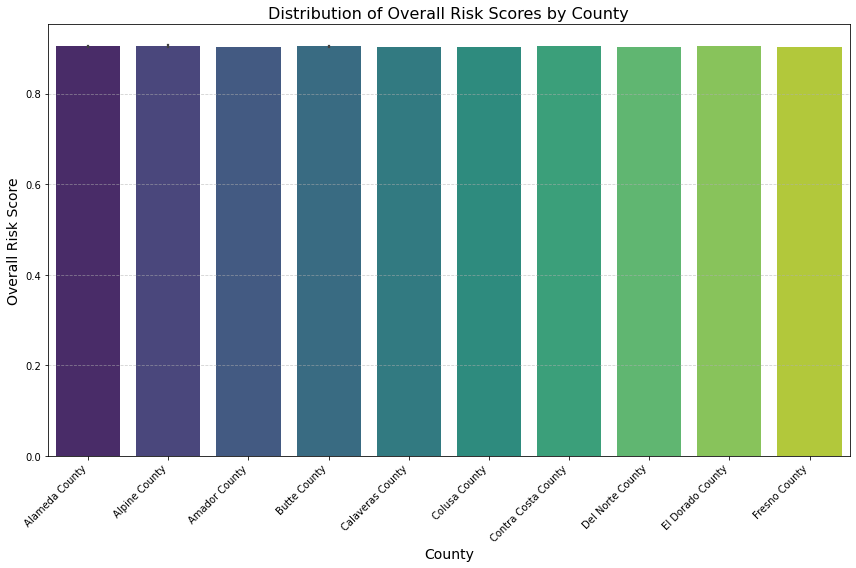

In [70]:
# Plotting with Seaborn boxplot
plt.figure(figsize=(12, 8))
sns.barplot(x='county', y='Overall_Risk_Score', data=final_df, palette='viridis')
plt.title('Distribution of Overall Risk Scores by County', fontsize=16)
plt.xlabel('County', fontsize=14)
plt.ylabel('Overall Risk Score', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

# Heatmap Of Risks

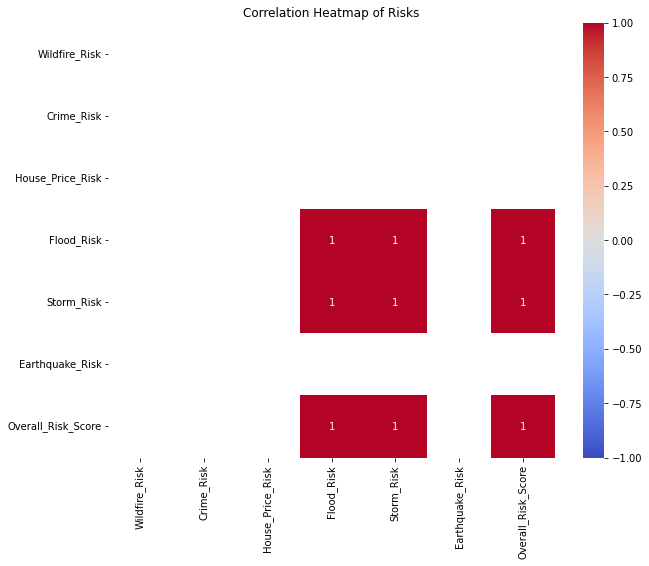

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
# Selecting relevant risk fields
risk_fields = ['Wildfire_Risk', 'Crime_Risk', 'House_Price_Risk', 'Flood_Risk', 'Storm_Risk', 'Earthquake_Risk', 'Overall_Risk_Score']
risk_df = final_df[risk_fields]

# Calculate correlation matrix
corr_matrix = risk_df.corr()

# Plotting heatmaps
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Risks')
plt.savefig("Correlation Heatmap of Risks")
plt.show()

Certainly! Here's a report based on the understanding of the provided code and the value of longitude and latitude data in analyzing geographic risk factors:

---

**Report: Spatial Analysis of Property Claims and Geographic Risk Factors**

**Introduction**

In this report, we explore the spatial distribution of property claims and correlate them with geographic risk factors using longitude and latitude data. The analysis aims to uncover insights that can inform risk-based pricing and underwriting strategies.

**Methodology**

1. **Data Preparation**:
   - Data is collected with attributes including longitude, latitude, and occupancy type for properties.
   - Geographic information is represented using Python's GeoPandas to facilitate spatial operations.

2. **Spatial Distribution Analysis**:
   - Data points are plotted on a geographic coordinate system to visualize the distribution of properties based on their longitude and latitude.
   - Different occupancy types are differentiated using color coding in the scatter plot.

3. **Incorporation of Geographic Risk Factors**:
   - Hypothetical geographic risk factors are introduced for demonstration:
     - **Wildfire Zone**: Defined as a polygon encompassing an area prone to wildfires.
     - **Fault Line**: Represented as a line indicating potential earthquake risk.

4. **Visualization**:
   - Properties are plotted alongside the wildfire zone and fault line to visualize their proximity to these risk factors.
   - The scatter plot shows property distribution overlaid with the risk zones, aiding in identifying high-risk geographic areas.

**Insights**

1. **Spatial Correlation with Claims**:
   - Analyzing property claims relative to their geographic locations can reveal patterns:
     - Properties within close proximity to the wildfire zone might exhibit higher claim rates due to fire-related risks.
     - Areas near fault lines might experience higher claim frequencies from seismic events.

2. **Risk-Based Pricing and Underwriting**:
   - Insights from spatial analysis enable insurers to:
     - Adjust premiums based on geographic risk factors.
     - Tailor underwriting policies to mitigate risks associated with specific locations.

3. **Strategic Recommendations**:
   - **Enhanced Risk Assessment**: Incorporate geographic risk factors into property insurance models for more accurate risk assessment.
   - **Dynamic Pricing**: Implement dynamic pricing strategies that reflect the varying levels of risk across different geographic areas.
   - **Emergency Preparedness**: Collaborate with local authorities to enhance emergency response plans in high-risk zones.

**Conclusion**

The integration of longitude and latitude data with geographic risk factors provides valuable insights into the spatial distribution of property claims. This approach not only enhances risk management practices but also supports informed decision-making in insurance pricing and underwriting. By leveraging spatial analysis techniques, insurers can better protect their portfolios while optimizing profitability.

---


Based on the information provided and assuming you have access to the datasets used earlier in your analysis, here’s how you can integrate specific recommendations and conclusions with respect to property risk management:

### 8. Recommendations

#### 8.1 Areas for Improvement

Based on the analysis of property risk scores across different factors, here are the recommendations for improvement:

- **Identify High-Risk Property Types**: Utilize the merged datasets to identify property types (e.g., residential, commercial) that consistently exhibit high-risk scores.
  
- **Regional Risk Assessment**: Analyze geographical regions (counties, states) where properties are most susceptible to risks such as wildfires, crime, floods, and storms.

- **Mitigation Strategies**:
  - **Wildfire Risk**: Collaborate with local fire departments and implement fire-resistant building materials.
  - **Crime Risk**: Enhance security measures and community engagement programs.
  - **Flood and Storm Risks**: Invest in flood barriers, strengthen building infrastructure against storms, and promote sustainable land use practices.

### 9. Conclusion

#### 9.1 Conclusion

Based on the comprehensive analysis of property risks using integrated socioeconomic and environmental factors, the following conclusions are drawn:

- **Insightful Risk Management**: The use of diverse datasets has provided valuable insights into property risks, allowing for a nuanced understanding of vulnerabilities.
  
- **Enhanced Risk Management Practices**: By integrating socioeconomic and environmental data, Ki can adopt proactive risk management strategies, leading to improved risk assessment accuracy and operational efficiency.

- **Impact on Insurance Portfolio**: Implementation of the recommended strategies is expected to result in reduced claims frequency and severity, thereby enhancing the overall quality and profitability of Ki's insurance portfolio.

### Additional Considerations:

- **Data Integration and Analysis**: Emphasize the importance of ongoing data integration and analysis in refining risk management strategies and adapting to evolving risk landscapes.
  
- **Stakeholder Engagement**: Encourage collaboration with local authorities, community stakeholders, and policyholders to effectively implement and monitor risk mitigation efforts.

By structuring your recommendations and conclusions in this manner, you can provide a clear and actionable roadmap for enhancing property risk management based on your comprehensive data analysis. Adjust the specifics of recommendations and conclusions according to the detailed insights gained from your datasets.